# Emission model
Author: Wenbo Yu

Data: 5/27/20

In [2]:
import os
import numpy as np
import torch.nn as nn
import pickle
import random
import pandas as pd6
import torch
from torch.autograd import Variable
from pandas_ods_reader import read_ods
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy import stats

import matplotlib.pyplot as plt
% matplotlib inline

## Data structure

In [3]:
class dataset:
    def __init__(self, df, lower_bound, upper_bound):
        self.df = df
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.lower_df = self.lower_bound_filtering()
        self.upper_df = self.upper_bound_filtering()
        self.lower_np = self.lower_df.to_numpy()
        self.upper_np = self.upper_df.to_numpy()
        self.numpy = np.concatenate([self.lower_np, self.upper_np])
        
    def lower_bound_filtering(self):
        filter = self.df['xHCOcI'] < self.lower_bound
        return df.loc[filter]
    
    def upper_bound_filtering(self):
        filter = self.df['xHCOcI'] > self.lower_bound
        df = self.df.loc[filter]
        filter = df['xHCOcI'] < self.upper_bound
        return df.loc[filter]
    
    def scaler(self, scalerX):
        self.lower_np[:, 1:] = scalerX.transform(self.lower_np[:, 1:])
        if self.upper_np.shape[0] > 0:
            self.upper_np[:, 1:] = scalerX.transform(self.upper_np[:, 1:])
            
    def split(self):
        length = self.lower_np.shape[0]
        index_list = [i for i in range(length)]
        random.shuffle(index_list)
        self.l1 = self.lower_np[index_list[:length//3], :]
        self.l2 = self.lower_np[index_list[length//3:length//3*2], :]
        self.l3 = self.lower_np[index_list[length//3*2:], :]
        self.l = self.lower_np
        
        self.l1 = torch.from_numpy(self.l1).to(dtype=torch.float32)
        self.l2 = torch.from_numpy(self.l2).to(dtype=torch.float32)
        self.l3 = torch.from_numpy(self.l3).to(dtype=torch.float32)
        self.l = torch.from_numpy(self.lower_np).to(dtype=torch.float32)
        
        if self.upper_np.shape[0] > 0:
            length = self.upper_np.shape[0]
            index_list = [i for i in range(length)]
            random.shuffle(index_list)
            self.u1 = self.upper_np[index_list[:length//3], :]
            self.u2 = self.upper_np[index_list[length//3:length//3*2], :]
            self.u3 = self.upper_np[index_list[length//3*2:], :]
            self.u = self.upper_np
            
            self.u1 = torch.from_numpy(self.u1).to(dtype=torch.float32)
            self.u2 = torch.from_numpy(self.u2).to(dtype=torch.float32)
            self.u3 = torch.from_numpy(self.u3).to(dtype=torch.float32)
            self.u = torch.from_numpy(self.upper_np).to(dtype=torch.float32)
        
#                 task_order = [i for i in range(2)]
#         random.shuffle(task_order)
#         self.lower_np[:, 1:], self.lower_np[:, 0:1]
#         if test_size < 1:
#             self.x_train_l, self.x_test_l, self.y_train_l, self.y_test_l = train_test_split(self.lower_np[:, 1:], self.lower_np[:, 0:1], test_size=test_size, random_state=42, shuffle=True)
#             self.x_train_l = torch.from_numpy(self.x_train_l).to(dtype=torch.float32).cuda()
#             self.x_test_l = torch.from_numpy(self.x_test_l).to(dtype=torch.float32).cuda()
#             self.y_train_l = torch.from_numpy(self.y_train_l).to(dtype=torch.float32).cuda()
#             self.y_test_l = torch.from_numpy(self.y_test_l).to(dtype=torch.float32).cuda()
#             if self.upper_np.shape[0] > 0:
#                 self.x_train_u, self.x_test_u, self.y_train_u, self.y_test_u = train_test_split(self.upper_np[:, 1:], self.upper_np[:, 0:1], test_size=test_size, random_state=42, shuffle=True)
#                 self.x_train_u = torch.from_numpy(self.x_train_u).to(dtype=torch.float32).cuda()
#                 self.x_test_u = torch.from_numpy(self.x_test_u).to(dtype=torch.float32).cuda()
#                 self.y_train_u = torch.from_numpy(self.y_train_u).to(dtype=torch.float32).cuda()
#                 self.y_test_u = torch.from_numpy(self.y_test_u).to(dtype=torch.float32).cuda()
#         else:
#             self.x_test_l, self.y_test_l = self.lower_np[:, 1:], self.lower_np[:, 0:1]
#             self.x_test_l = torch.from_numpy(self.x_test_l).to(dtype=torch.float32).cuda()
#             self.y_test_l = torch.from_numpy(self.y_test_l).to(dtype=torch.float32).cuda()
#             if self.upper_np.shape[0] > 0:
#                 self.x_test_u, self.y_test_u = self.upper_np[:, 1:], self.upper_np[:, 0:1]
#                 self.x_test_u = torch.from_numpy(self.x_test_u).to(dtype=torch.float32).cuda()
#                 self.y_test_u = torch.from_numpy(self.y_test_u).to(dtype=torch.float32).cuda()            

## Data preprocessing
Including seleting the features, filtering the data.

In [4]:
#### Hyperparameters needed to be set in advance ####
xHCOcI_lower_bound = 200
xHCOcL_upper_bound = 700
#####################################################

data_set_name = ['HCaltitude', 'HCDOE', 'HCTPA']
flag = 1
dataset_list = []

for set in data_set_name:
    path = 'data/' + set + '.ods'
    sheet_idx = 1
    df = read_ods(path, sheet_idx)
    if flag:
        df = df.drop(columns=['Sno', 'HCUDF', 'HCUDFpolynomial'])
        columns = list(df.columns)
        flag = 0
    df = df[columns]
    dataset_list.append(dataset(df, xHCOcI_lower_bound, xHCOcL_upper_bound))

flag = 1
for set in dataset_list:
    if flag:
        data_all = set.numpy
        flag = 0
    else:
        data_all = np.concatenate([data_all, set.numpy])

scalerX = preprocessing.MinMaxScaler().fit(data_all[:, 1:])
for set in dataset_list:
    set.scaler(scalerX)
for set in dataset_list:
    set.split()

In [37]:

    
# def build_only_upper(dataset_list):
#     flag = 1
#     x_test = []
#     y_test = []
#     for set in dataset_list:
#         if set.upper_np.shape[0]:
#             if flag:
#                 x_training = set.x_train_u
#                 y_training = set.y_train_u
#                 flag = 0
#             else:
#                 x_training = torch.cat([x_training, set.x_train_u])
#                 y_training = torch.cat([y_training, set.y_train_u])
#             x_test.append(set.x_train_u)
#             y_test.append(set.y_train_u)
#     return x_training, y_training, x_test, y_test

# def build_only_lower(dataset_list):
#     flag = 1
#     x_test = []
#     y_test = []
#     for set in dataset_list:
#         if flag:
#             x_training = set.x_train_l
#             y_training = set.y_train_l
#             flag = 0
#         else:
#             x_training = torch.cat([x_training, set.x_train_l])
#             y_training = torch.cat([y_training, set.y_train_l])
#         x_test.append(set.x_train_l)
#         y_test.append(set.y_train_l)
#     return x_training, y_training, x_test, y_test

In [5]:
dataset_list[1]

## Dataset preparation
Set training and test set

In [109]:


# # HCaltitude as target set
# y_target = torch.from_numpy(data[:num_list[0], 0:1]).to(dtype=torch.float32).cuda()
# x_target = torch.from_numpy(data[:num_list[0], 1:]).to(dtype=torch.float32).cuda()

# # Set the other two sets for training and testing with properation of 7:3
# HCDOE = torch.from_numpy(data[num_list[0]:num_list[1], :]).to(dtype=torch.float32).cuda()
# HCTPA = torch.from_numpy(data[num_list[1]:num_list[2], :]).to(dtype=torch.float32).cuda()
# training_size = [int(0.7 * n2), int(0.7 * n3)]
# test_size = [n2 - int(0.7 * n2), n3 - int(0.7 * n3)]
# batch_list = [[item for item in range(training_size[0])], [item for item in range(training_size[1])]]
# chosen_size = [training_size[0] + test_size[0], training_size[1] + test_size[1]]

# x_training = []
# y_training = []
# x_test = []
# y_test = []

# chosen_list = [item for item in range(HCDOE.shape[0])]
# random.shuffle(chosen_list)
# x_training.append(HCDOE[chosen_list[:training_size[0]], 1:])
# y_training.append(HCDOE[chosen_list[:training_size[0]], 0:1])
# x_test.append(HCDOE[chosen_list[training_size[0]:chosen_size[0]], 1:])
# y_test.append(HCDOE[chosen_list[training_size[0]:chosen_size[0]], 0:1])

# chosen_list = [item for item in range(HCTPA.shape[0])]
# random.shuffle(chosen_list)
# x_training.append(HCTPA[chosen_list[:training_size[1]], 1:])
# y_training.append(HCTPA[chosen_list[:training_size[1]], 0:1])
# x_test.append(HCTPA[chosen_list[training_size[1]:chosen_size[1]], 1:])
# y_test.append(HCTPA[chosen_list[training_size[1]:chosen_size[1]], 0:1])

# # Set test sets for different purposes
# x_test_0 = x_test[0]
# y_test_0 = y_test[0]
# x_test_1 = x_test[1]
# y_test_1 = y_test[1]
# x_test_all = torch.cat([x_test[0], x_test[1]])
# y_test_all = torch.cat([y_test[0], y_test[1]])

# Network structure

In [5]:
# Network structure
class NN(nn.Module):
    def __init__(self, features):
        super(NN, self).__init__()
        self.features = features
        self.l1 = nn.Sequential(
            nn.Linear(self.features, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
    def point_grad_to(self, target):
        '''
        #### This function is important for meta learning. If other model is used, this one could be directly copied into other models ###
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)
    def forward(self, input):
        output = self.l1(input)
        return output

# Training Process

In [14]:
class testset:
    def __init__(self, test):
        self.x = test[:, 1:]
        self.y = test[:, :1].detach().numpy() 
        self.x_gpu = self.x.cuda()
        self.y_mean = np.mean(self.y)
        self.y_diff = np.max(self.y) - np.min(self.y)
      
    def evaluation(self, pred):
        real = self.y
        self.R2 = r2_score(np.squeeze(real), np.squeeze(pred))
        self.r2, _ = stats.pearsonr(np.squeeze(real), np.squeeze(pred))
        self.RMSE = np.sqrt(mean_squared_error(real, pred))
        self.nRMSE = self.RMSE / self.y_diff
#         self.nRMSE_mean = self.RMSE / self.y_mean
        
target_l = testset(dataset_list[0].l)

# training_l_1 = torch.cat([dataset_list[2].l1, dataset_list[2].l2]).cuda()
# test_l_1 = testset(dataset_list[2].l3)

training_l_1 = torch.cat([dataset_list[1].l3, dataset_list[1].l1]).cuda()
training_l_2 = torch.cat([dataset_list[2].l3, dataset_list[2].l1]).cuda()
training_l_3 = torch.cat([dataset_list[1].u3, dataset_list[1].u1]).cuda()

test_l_1 = testset(dataset_list[1].l2)
test_l_2 = testset(dataset_list[2].l2)
test_u_1 = testset(dataset_list[1].u2)


x_training = [training_l_1[:, 1:], training_l_2[:, 1:], training_l_3[:, 1:]]
y_training = [training_l_1[:, :1], training_l_2[:, :1], training_l_3[:, :1]]

# if dataset_list[0].upper_np.shape[0]:
#     x_target_u = dataset_list[0].x_test_u
#     y_target_u = dataset_list[0].y_test_u
    
# x_target_l = dataset_list[0].x_test_l
# y_target_l = dataset_list[0].y_test_l

# x_training_l, y_training_l, x_test_l, y_test_l = build_only_lower(dataset_list[1:])
# x_training_l_1, y_training_l_1, _, _ = build_only_lower(dataset_list[1:2])
# x_training_l_2, y_training_l_2, _, _ = build_only_lower(dataset_list[2:])

# x_training_u, y_training_u, x_test_u, y_test_u = build_only_upper(dataset_list[1:])
# x_training = [x_training_l_1, x_training_l_2, x_training_u]
# y_training = [y_training_l_1, y_training_l_2, y_training_u]
# # batch_list = [[i for i in range(x_training_l.shape[0])], [i for i in range(x_training_u.shape[0])]]
# batch_list = [[i for i in range(x_training_l_1.shape[0])], [i for i in range(x_training_l_2.shape[0])], [i for i in range(x_training_u.shape[0])]]

# x_training_u, y_training_u, x_test_u, y_test_u = build_only_upper(dataset_list[1:])
# x_training = [x_training_l_2, x_training_u]
# y_training = [y_training_l_2, y_training_u]
# # batch_list = [[i for i in range(x_training_l.shape[0])], [i for i in range(x_training_u.shape[0])]]
# batch_list = [[i for i in range(x_training_l_2.shape[0])], [i for i in range(x_training_u.shape[0])]]
batch_list = [[i for i in range(training_l_1.shape[0])], [i for i in range(training_l_2.shape[0])], [i for i in range(training_l_3.shape[0])]]

#### Hyperparameters needed to be set in advance ####
Step = 100000
batch_size = 10
meta_flag = 1 # Whether use meta learning
features = 13
net = NN(features).cuda()

if meta_flag: # With meta learning
    meta_lr = 1e-5 # For meta learning 
    update_lr = 1e-5 # For meta learning update step
    update_step = 3
    meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr) # Optimizers
else: # Without meta learning
    dataset_idx = 0 # 0: DOE, 1: TPA
    lrate = 1e-4 # Without meta leraning
    optimizer = torch.optim.Adam(net.parameters(), lr=lrate) # Optimizers
    
#####################################################



MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss()
weight_flag = 0
i = 0
print('Start training')
for step in range(Step): 
#     if meta_flag:
    meta_loss_total = 0
    task_order = [0, 1, 2]
    random.shuffle(task_order)
    for i in task_order:
        # Choose data
        batch_content = random.sample(batch_list[i], batch_size)
        x_batch = x_training[i][batch_content, :]
        y_batch = y_training[i][batch_content]
        # Initialize network. This network 'net_i' is used to train several steps, and the learnt parameters are used to update 'net'
        net_i = NN(features).cuda()
        net_i.load_state_dict(net.state_dict())
        update_optimizer = torch.optim.Adam(net_i.parameters(), lr=update_lr)
        # Update process
        for j in range(update_step):
            y_pred = net_i(x_batch)
            update_loss = MSELoss(y_pred, y_batch)
            update_optimizer.zero_grad()
            update_loss.backward(retain_graph=True)
            update_optimizer.step()
        net.point_grad_to(net_i)
        meta_optimizer.step()

# #     else:
#     batch_content = random.sample(batch_list, batch_size)
#     x_batch = x_training[batch_content, :]
#     y_batch = y_training[batch_content]
#     # Update process
#     y_pred = net(x_batch)
#     loss = MSELoss(y_pred, y_batch)
#     optimizer.zero_grad()
#     loss.backward(retain_graph=True)
#     optimizer.step()
   
    
    y_pred = net(test_l_1.x_gpu).cpu().detach().numpy()
    test_l_1.evaluation(y_pred)

    y_pred = net(test_l_2.x_gpu).cpu().detach().numpy()
    test_l_2.evaluation(y_pred)
    
    y_pred = net(test_u_1.x_gpu).cpu().detach().numpy()
    test_u_1.evaluation(y_pred)
    
    y_pred = net(target_l.x_gpu).cpu().detach().numpy()
    target_l.evaluation(y_pred)
    

    if step % 10 == 0:
        print(' ')
        print('epoch: %d || l1: %.2f || l2: %.2f || u1: %.2f || l3: %.2f' % (step, test_l_1.r2, test_l_2.r2, test_u_1.r2, target_l.r2))
        print('epoch: %d || l1: %.2f || l2: %.2f || u1: %.2f || l3: %.2f' % (step, test_l_1.R2, test_l_2.R2, test_u_1.R2, target_l.R2))
        print('epoch: %d || l1: %.2f || l2: %.2f || u1: %.2f || l3: %.2f' % (step, test_l_1.RMSE, test_l_2.RMSE, test_u_1.RMSE, target_l.RMSE))
        print('epoch: %d || l1: %.2f || l2: %.2f || u1: %.2f || l3: %.2f' % (step, test_l_1.nRMSE, test_l_2.nRMSE, test_u_1.nRMSE, target_l.nRMSE))
#         print('epoch: %d || l1: %.2f || l2: %.2f || u1: %.2f || l3: %.2f' % (step, test_l_1.nRMSE_mean, test_l_2.nRMSE_mean, test_u_1.nRMSE_mean, target_l.nRMSE_mean))
    #     print('epoch: %d || l2: %f || u1: %f' % (step, r2, r3))
#     l = [r1, r3]
#     i = l.index(min(l))
#     i = 2 * i

    
    
#     y_pred = net(x_target)
#     y_real = y_target
# #     y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# #     y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
# #     loss_2 = MSELoss(y_pred, y_real) / (torch.mean(y_real) ** 2)
#     loss_2 = MSELoss(y_pred, y_real)
#     loss_2 = torch.sqrt(loss_2.data)
    
# #     print('epoch: %d || DOE: %f || TPA: %f || Target: %f' % (step, loss_0.data, loss_1.data, loss_2))
# #     loss = loss_0 + loss_1 + loss_2
#     if step % 500 == 0:
#         weight_name = 'out/model_%d_%.1f.ckpt' % (step, test_l_1.r2)
#         torch.save(net.state_dict(), weight_name)        
# #     if step > 500:
# #         if weight_flag == 0:
# #             # Save weights
# #             weight_name = 'out/model_%d.ckpt' % (step)
# #             torch.save(net.state_dict(), weight_name)
# #             weight_flag = 1
# #             best_one = loss.data
# #         else:
# #             if loss.data < best_one:
# #                 weight_name = 'out/model_%d_%.1f_%.1f.ckpt' % (step, loss.data, loss_2.data)
# #                 torch.save(net.state_dict(), weight_name)
# #                 best_one = loss.data

Start training
 
epoch: 0 || l1: -0.76 || l2: -0.68 || u1: -0.04 || l3: -0.60
epoch: 0 || l1: -2.83 || l2: -20.40 || u1: -8.86 || l3: -6.17
epoch: 0 || l1: 68.31 || l2: 43.52 || u1: 373.99 || l3: 55.73
epoch: 0 || l1: 0.35 || l2: 0.93 || u1: 0.77 || l3: 0.35
 
epoch: 10 || l1: -0.63 || l2: -0.66 || u1: -0.19 || l3: -0.50
epoch: 10 || l1: -2.81 || l2: -20.25 || u1: -8.85 || l3: -6.13
epoch: 10 || l1: 68.18 || l2: 43.36 || u1: 373.85 || l3: 55.60
epoch: 10 || l1: 0.35 || l2: 0.92 || u1: 0.77 || l3: 0.35
 
epoch: 20 || l1: -0.54 || l2: -0.61 || u1: -0.18 || l3: -0.43
epoch: 20 || l1: -2.80 || l2: -20.08 || u1: -8.85 || l3: -6.09
epoch: 20 || l1: 68.03 || l2: 43.19 || u1: 373.71 || l3: 55.44
epoch: 20 || l1: 0.35 || l2: 0.92 || u1: 0.77 || l3: 0.35
 
epoch: 30 || l1: -0.51 || l2: -0.60 || u1: -0.16 || l3: -0.39
epoch: 30 || l1: -2.78 || l2: -19.89 || u1: -8.84 || l3: -6.05
epoch: 30 || l1: 67.87 || l2: 43.00 || u1: 373.54 || l3: 55.27
epoch: 30 || l1: 0.35 || l2: 0.91 || u1: 0.77 || l3: 0.

 
epoch: 330 || l1: -0.54 || l2: -0.60 || u1: -0.13 || l3: -0.36
epoch: 330 || l1: -0.48 || l2: -0.57 || u1: -7.31 || l3: -0.71
epoch: 330 || l1: 42.44 || l2: 11.77 || u1: 343.39 || l3: 27.22
epoch: 330 || l1: 0.22 || l2: 0.25 || u1: 0.71 || l3: 0.17
 
epoch: 340 || l1: -0.53 || l2: -0.59 || u1: -0.13 || l3: -0.35
epoch: 340 || l1: -0.41 || l2: -0.42 || u1: -7.23 || l3: -0.57
epoch: 340 || l1: 41.42 || l2: 11.20 || u1: 341.60 || l3: 26.08
epoch: 340 || l1: 0.22 || l2: 0.24 || u1: 0.70 || l3: 0.16
 
epoch: 350 || l1: -0.51 || l2: -0.58 || u1: -0.13 || l3: -0.34
epoch: 350 || l1: -0.36 || l2: -0.37 || u1: -7.16 || l3: -0.47
epoch: 350 || l1: 40.65 || l2: 11.00 || u1: 340.17 || l3: 25.24
epoch: 350 || l1: 0.21 || l2: 0.23 || u1: 0.70 || l3: 0.16
 
epoch: 360 || l1: -0.50 || l2: -0.57 || u1: -0.13 || l3: -0.33
epoch: 360 || l1: -0.32 || l2: -0.37 || u1: -7.11 || l3: -0.41
epoch: 360 || l1: 40.12 || l2: 11.00 || u1: 339.13 || l3: 24.68
epoch: 360 || l1: 0.21 || l2: 0.23 || u1: 0.70 || l3: 0

 
epoch: 660 || l1: 0.14 || l2: 0.11 || u1: -0.19 || l3: 0.26
epoch: 660 || l1: 0.01 || l2: -2.69 || u1: -6.41 || l3: 0.03
epoch: 660 || l1: 34.69 || l2: 18.06 || u1: 324.09 || l3: 20.47
epoch: 660 || l1: 0.18 || l2: 0.38 || u1: 0.67 || l3: 0.13
 
epoch: 670 || l1: 0.16 || l2: 0.13 || u1: -0.20 || l3: 0.27
epoch: 670 || l1: 0.02 || l2: -2.87 || u1: -6.38 || l3: 0.03
epoch: 670 || l1: 34.59 || l2: 18.51 || u1: 323.52 || l3: 20.49
epoch: 670 || l1: 0.18 || l2: 0.39 || u1: 0.67 || l3: 0.13
 
epoch: 680 || l1: 0.18 || l2: 0.16 || u1: -0.20 || l3: 0.30
epoch: 680 || l1: 0.02 || l2: -2.83 || u1: -6.38 || l3: 0.04
epoch: 680 || l1: 34.52 || l2: 18.40 || u1: 323.48 || l3: 20.42
epoch: 680 || l1: 0.18 || l2: 0.39 || u1: 0.67 || l3: 0.13
 
epoch: 690 || l1: 0.20 || l2: 0.18 || u1: -0.20 || l3: 0.32
epoch: 690 || l1: 0.03 || l2: -2.77 || u1: -6.38 || l3: 0.04
epoch: 690 || l1: 34.46 || l2: 18.26 || u1: 323.47 || l3: 20.35
epoch: 690 || l1: 0.18 || l2: 0.39 || u1: 0.67 || l3: 0.13
 
epoch: 700 || 

 
epoch: 1000 || l1: 0.57 || l2: 0.54 || u1: -0.24 || l3: 0.63
epoch: 1000 || l1: 0.16 || l2: -3.20 || u1: -6.12 || l3: 0.17
epoch: 1000 || l1: 31.92 || l2: 19.29 || u1: 317.78 || l3: 18.92
epoch: 1000 || l1: 0.17 || l2: 0.41 || u1: 0.65 || l3: 0.12
 
epoch: 1010 || l1: 0.57 || l2: 0.54 || u1: -0.24 || l3: 0.63
epoch: 1010 || l1: 0.17 || l2: -3.29 || u1: -6.10 || l3: 0.17
epoch: 1010 || l1: 31.83 || l2: 19.49 || u1: 317.44 || l3: 18.92
epoch: 1010 || l1: 0.17 || l2: 0.41 || u1: 0.65 || l3: 0.12
 
epoch: 1020 || l1: 0.58 || l2: 0.55 || u1: -0.24 || l3: 0.63
epoch: 1020 || l1: 0.17 || l2: -3.48 || u1: -6.08 || l3: 0.17
epoch: 1020 || l1: 31.75 || l2: 19.92 || u1: 316.87 || l3: 18.99
epoch: 1020 || l1: 0.16 || l2: 0.42 || u1: 0.65 || l3: 0.12
 
epoch: 1030 || l1: 0.58 || l2: 0.55 || u1: -0.24 || l3: 0.63
epoch: 1030 || l1: 0.18 || l2: -3.53 || u1: -6.07 || l3: 0.17
epoch: 1030 || l1: 31.67 || l2: 20.03 || u1: 316.62 || l3: 18.97
epoch: 1030 || l1: 0.16 || l2: 0.43 || u1: 0.65 || l3: 0.12


 
epoch: 1330 || l1: 0.68 || l2: 0.61 || u1: -0.26 || l3: 0.66
epoch: 1330 || l1: 0.30 || l2: -3.21 || u1: -5.91 || l3: 0.30
epoch: 1330 || l1: 29.22 || l2: 19.29 || u1: 313.10 || l3: 17.40
epoch: 1330 || l1: 0.15 || l2: 0.41 || u1: 0.65 || l3: 0.11
 
epoch: 1340 || l1: 0.69 || l2: 0.61 || u1: -0.26 || l3: 0.66
epoch: 1340 || l1: 0.30 || l2: -3.28 || u1: -5.90 || l3: 0.30
epoch: 1340 || l1: 29.14 || l2: 19.47 || u1: 312.80 || l3: 17.42
epoch: 1340 || l1: 0.15 || l2: 0.41 || u1: 0.64 || l3: 0.11
 
epoch: 1350 || l1: 0.69 || l2: 0.61 || u1: -0.26 || l3: 0.66
epoch: 1350 || l1: 0.31 || l2: -3.37 || u1: -5.88 || l3: 0.30
epoch: 1350 || l1: 29.07 || l2: 19.67 || u1: 312.48 || l3: 17.45
epoch: 1350 || l1: 0.15 || l2: 0.42 || u1: 0.64 || l3: 0.11
 
epoch: 1360 || l1: 0.69 || l2: 0.62 || u1: -0.26 || l3: 0.66
epoch: 1360 || l1: 0.31 || l2: -3.36 || u1: -5.88 || l3: 0.30
epoch: 1360 || l1: 29.01 || l2: 19.64 || u1: 312.41 || l3: 17.40
epoch: 1360 || l1: 0.15 || l2: 0.42 || u1: 0.64 || l3: 0.11


 
epoch: 1660 || l1: 0.73 || l2: 0.64 || u1: -0.27 || l3: 0.66
epoch: 1660 || l1: 0.42 || l2: -3.68 || u1: -5.69 || l3: 0.36
epoch: 1660 || l1: 26.57 || l2: 20.36 || u1: 307.95 || l3: 16.65
epoch: 1660 || l1: 0.14 || l2: 0.43 || u1: 0.63 || l3: 0.11
 
epoch: 1670 || l1: 0.73 || l2: 0.64 || u1: -0.27 || l3: 0.66
epoch: 1670 || l1: 0.42 || l2: -3.72 || u1: -5.68 || l3: 0.36
epoch: 1670 || l1: 26.50 || l2: 20.43 || u1: 307.76 || l3: 16.66
epoch: 1670 || l1: 0.14 || l2: 0.43 || u1: 0.63 || l3: 0.11
 
epoch: 1680 || l1: 0.73 || l2: 0.64 || u1: -0.27 || l3: 0.66
epoch: 1680 || l1: 0.43 || l2: -3.94 || u1: -5.65 || l3: 0.35
epoch: 1680 || l1: 26.43 || l2: 20.91 || u1: 307.15 || l3: 16.82
epoch: 1680 || l1: 0.14 || l2: 0.45 || u1: 0.63 || l3: 0.11
 
epoch: 1690 || l1: 0.73 || l2: 0.64 || u1: -0.27 || l3: 0.66
epoch: 1690 || l1: 0.43 || l2: -3.99 || u1: -5.64 || l3: 0.35
epoch: 1690 || l1: 26.37 || l2: 21.00 || u1: 306.96 || l3: 16.84
epoch: 1690 || l1: 0.14 || l2: 0.45 || u1: 0.63 || l3: 0.11


 
epoch: 1990 || l1: 0.75 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 1990 || l1: 0.51 || l2: -4.66 || u1: -5.46 || l3: 0.33
epoch: 1990 || l1: 24.35 || l2: 22.37 || u1: 302.78 || l3: 17.04
epoch: 1990 || l1: 0.13 || l2: 0.48 || u1: 0.62 || l3: 0.11
 
epoch: 2000 || l1: 0.75 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2000 || l1: 0.52 || l2: -4.82 || u1: -5.44 || l3: 0.32
epoch: 2000 || l1: 24.30 || l2: 22.69 || u1: 302.34 || l3: 17.19
epoch: 2000 || l1: 0.13 || l2: 0.48 || u1: 0.62 || l3: 0.11
 
epoch: 2010 || l1: 0.75 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2010 || l1: 0.52 || l2: -4.87 || u1: -5.44 || l3: 0.31
epoch: 2010 || l1: 24.23 || l2: 22.80 || u1: 302.11 || l3: 17.24
epoch: 2010 || l1: 0.13 || l2: 0.49 || u1: 0.62 || l3: 0.11
 
epoch: 2020 || l1: 0.75 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2020 || l1: 0.52 || l2: -4.98 || u1: -5.42 || l3: 0.31
epoch: 2020 || l1: 24.16 || l2: 23.01 || u1: 301.77 || l3: 17.34
epoch: 2020 || l1: 0.13 || l2: 0.49 || u1: 0.62 || l3: 0.11


 
epoch: 2320 || l1: 0.76 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2320 || l1: 0.56 || l2: -5.60 || u1: -5.31 || l3: 0.25
epoch: 2320 || l1: 23.20 || l2: 24.17 || u1: 299.06 || l3: 18.03
epoch: 2320 || l1: 0.12 || l2: 0.51 || u1: 0.62 || l3: 0.11
 
epoch: 2330 || l1: 0.76 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2330 || l1: 0.56 || l2: -5.56 || u1: -5.31 || l3: 0.25
epoch: 2330 || l1: 23.17 || l2: 24.10 || u1: 299.12 || l3: 18.00
epoch: 2330 || l1: 0.12 || l2: 0.51 || u1: 0.62 || l3: 0.11
 
epoch: 2340 || l1: 0.76 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2340 || l1: 0.56 || l2: -5.60 || u1: -5.30 || l3: 0.25
epoch: 2340 || l1: 23.15 || l2: 24.17 || u1: 298.99 || l3: 18.04
epoch: 2340 || l1: 0.12 || l2: 0.51 || u1: 0.62 || l3: 0.11
 
epoch: 2350 || l1: 0.76 || l2: 0.65 || u1: -0.27 || l3: 0.66
epoch: 2350 || l1: 0.56 || l2: -5.46 || u1: -5.32 || l3: 0.26
epoch: 2350 || l1: 23.12 || l2: 23.91 || u1: 299.30 || l3: 17.92
epoch: 2350 || l1: 0.12 || l2: 0.51 || u1: 0.62 || l3: 0.11


 
epoch: 2650 || l1: 0.77 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 2650 || l1: 0.58 || l2: -6.53 || u1: -5.17 || l3: 0.15
epoch: 2650 || l1: 22.54 || l2: 25.82 || u1: 295.74 || l3: 19.22
epoch: 2650 || l1: 0.12 || l2: 0.55 || u1: 0.61 || l3: 0.12
 
epoch: 2660 || l1: 0.77 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 2660 || l1: 0.58 || l2: -6.63 || u1: -5.16 || l3: 0.14
epoch: 2660 || l1: 22.53 || l2: 25.98 || u1: 295.49 || l3: 19.32
epoch: 2660 || l1: 0.12 || l2: 0.55 || u1: 0.61 || l3: 0.12
 
epoch: 2670 || l1: 0.77 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 2670 || l1: 0.58 || l2: -6.69 || u1: -5.15 || l3: 0.13
epoch: 2670 || l1: 22.52 || l2: 26.08 || u1: 295.30 || l3: 19.39
epoch: 2670 || l1: 0.12 || l2: 0.56 || u1: 0.61 || l3: 0.12
 
epoch: 2680 || l1: 0.77 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 2680 || l1: 0.58 || l2: -6.81 || u1: -5.14 || l3: 0.12
epoch: 2680 || l1: 22.51 || l2: 26.29 || u1: 294.98 || l3: 19.52
epoch: 2680 || l1: 0.12 || l2: 0.56 || u1: 0.61 || l3: 0.12


 
epoch: 2980 || l1: 0.78 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 2980 || l1: 0.60 || l2: -6.50 || u1: -5.13 || l3: 0.12
epoch: 2980 || l1: 22.17 || l2: 25.77 || u1: 294.79 || l3: 19.50
epoch: 2980 || l1: 0.12 || l2: 0.55 || u1: 0.61 || l3: 0.12
 
epoch: 2990 || l1: 0.78 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 2990 || l1: 0.60 || l2: -6.69 || u1: -5.11 || l3: 0.11
epoch: 2990 || l1: 22.19 || l2: 26.08 || u1: 294.30 || l3: 19.67
epoch: 2990 || l1: 0.12 || l2: 0.56 || u1: 0.61 || l3: 0.12
 
epoch: 3000 || l1: 0.78 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 3000 || l1: 0.60 || l2: -6.54 || u1: -5.12 || l3: 0.12
epoch: 3000 || l1: 22.16 || l2: 25.84 || u1: 294.62 || l3: 19.54
epoch: 3000 || l1: 0.12 || l2: 0.55 || u1: 0.61 || l3: 0.12
 
epoch: 3010 || l1: 0.78 || l2: 0.65 || u1: -0.26 || l3: 0.66
epoch: 3010 || l1: 0.60 || l2: -6.52 || u1: -5.12 || l3: 0.12
epoch: 3010 || l1: 22.15 || l2: 25.80 || u1: 294.65 || l3: 19.53
epoch: 3010 || l1: 0.12 || l2: 0.55 || u1: 0.61 || l3: 0.12


 
epoch: 3310 || l1: 0.78 || l2: 0.65 || u1: -0.25 || l3: 0.66
epoch: 3310 || l1: 0.60 || l2: -6.78 || u1: -5.06 || l3: 0.08
epoch: 3310 || l1: 22.00 || l2: 26.24 || u1: 293.14 || l3: 20.01
epoch: 3310 || l1: 0.11 || l2: 0.56 || u1: 0.60 || l3: 0.13
 
epoch: 3320 || l1: 0.78 || l2: 0.65 || u1: -0.25 || l3: 0.66
epoch: 3320 || l1: 0.60 || l2: -6.90 || u1: -5.05 || l3: 0.07
epoch: 3320 || l1: 22.02 || l2: 26.44 || u1: 292.82 || l3: 20.13
epoch: 3320 || l1: 0.11 || l2: 0.56 || u1: 0.60 || l3: 0.13
 
epoch: 3330 || l1: 0.78 || l2: 0.65 || u1: -0.25 || l3: 0.66
epoch: 3330 || l1: 0.60 || l2: -7.12 || u1: -5.02 || l3: 0.04
epoch: 3330 || l1: 22.06 || l2: 26.80 || u1: 292.28 || l3: 20.35
epoch: 3330 || l1: 0.11 || l2: 0.57 || u1: 0.60 || l3: 0.13
 
epoch: 3340 || l1: 0.78 || l2: 0.65 || u1: -0.25 || l3: 0.66
epoch: 3340 || l1: 0.60 || l2: -7.11 || u1: -5.02 || l3: 0.04
epoch: 3340 || l1: 22.04 || l2: 26.80 || u1: 292.27 || l3: 20.36
epoch: 3340 || l1: 0.11 || l2: 0.57 || u1: 0.60 || l3: 0.13


 
epoch: 3640 || l1: 0.79 || l2: 0.65 || u1: -0.25 || l3: 0.67
epoch: 3640 || l1: 0.61 || l2: -6.41 || u1: -5.06 || l3: 0.09
epoch: 3640 || l1: 21.82 || l2: 25.61 || u1: 293.07 || l3: 19.87
epoch: 3640 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13
 
epoch: 3650 || l1: 0.79 || l2: 0.65 || u1: -0.25 || l3: 0.67
epoch: 3650 || l1: 0.61 || l2: -6.58 || u1: -5.04 || l3: 0.07
epoch: 3650 || l1: 21.85 || l2: 25.90 || u1: 292.64 || l3: 20.04
epoch: 3650 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13
 
epoch: 3660 || l1: 0.79 || l2: 0.65 || u1: -0.25 || l3: 0.67
epoch: 3660 || l1: 0.61 || l2: -6.59 || u1: -5.04 || l3: 0.07
epoch: 3660 || l1: 21.83 || l2: 25.91 || u1: 292.59 || l3: 20.07
epoch: 3660 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13
 
epoch: 3670 || l1: 0.79 || l2: 0.65 || u1: -0.25 || l3: 0.67
epoch: 3670 || l1: 0.61 || l2: -6.62 || u1: -5.03 || l3: 0.07
epoch: 3670 || l1: 21.82 || l2: 25.96 || u1: 292.48 || l3: 20.11
epoch: 3670 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13


 
epoch: 3970 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 3970 || l1: 0.61 || l2: -6.65 || u1: -4.99 || l3: 0.05
epoch: 3970 || l1: 21.74 || l2: 26.02 || u1: 291.58 || l3: 20.34
epoch: 3970 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13
 
epoch: 3980 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 3980 || l1: 0.61 || l2: -6.62 || u1: -5.00 || l3: 0.05
epoch: 3980 || l1: 21.73 || l2: 25.98 || u1: 291.60 || l3: 20.32
epoch: 3980 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13
 
epoch: 3990 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 3990 || l1: 0.62 || l2: -6.37 || u1: -5.02 || l3: 0.07
epoch: 3990 || l1: 21.65 || l2: 25.53 || u1: 292.19 || l3: 20.07
epoch: 3990 || l1: 0.11 || l2: 0.54 || u1: 0.60 || l3: 0.13
 
epoch: 4000 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4000 || l1: 0.61 || l2: -6.59 || u1: -5.00 || l3: 0.05
epoch: 4000 || l1: 21.71 || l2: 25.91 || u1: 291.62 || l3: 20.31
epoch: 4000 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13


 
epoch: 4300 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4300 || l1: 0.62 || l2: -6.38 || u1: -4.98 || l3: 0.05
epoch: 4300 || l1: 21.50 || l2: 25.56 || u1: 291.30 || l3: 20.32
epoch: 4300 || l1: 0.11 || l2: 0.54 || u1: 0.60 || l3: 0.13
 
epoch: 4310 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4310 || l1: 0.62 || l2: -6.30 || u1: -4.99 || l3: 0.06
epoch: 4310 || l1: 21.48 || l2: 25.42 || u1: 291.49 || l3: 20.23
epoch: 4310 || l1: 0.11 || l2: 0.54 || u1: 0.60 || l3: 0.13
 
epoch: 4320 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4320 || l1: 0.62 || l2: -6.31 || u1: -4.99 || l3: 0.05
epoch: 4320 || l1: 21.46 || l2: 25.43 || u1: 291.44 || l3: 20.24
epoch: 4320 || l1: 0.11 || l2: 0.54 || u1: 0.60 || l3: 0.13
 
epoch: 4330 || l1: 0.79 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4330 || l1: 0.62 || l2: -6.27 || u1: -4.99 || l3: 0.06
epoch: 4330 || l1: 21.42 || l2: 25.36 || u1: 291.50 || l3: 20.23
epoch: 4330 || l1: 0.11 || l2: 0.54 || u1: 0.60 || l3: 0.13


 
epoch: 4630 || l1: 0.80 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4630 || l1: 0.63 || l2: -6.59 || u1: -4.93 || l3: -0.00
epoch: 4630 || l1: 21.33 || l2: 25.92 || u1: 289.94 || l3: 20.86
epoch: 4630 || l1: 0.11 || l2: 0.55 || u1: 0.60 || l3: 0.13
 
epoch: 4640 || l1: 0.80 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4640 || l1: 0.63 || l2: -6.69 || u1: -4.92 || l3: -0.02
epoch: 4640 || l1: 21.36 || l2: 26.08 || u1: 289.67 || l3: 20.97
epoch: 4640 || l1: 0.11 || l2: 0.56 || u1: 0.60 || l3: 0.13
 
epoch: 4650 || l1: 0.80 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4650 || l1: 0.63 || l2: -6.74 || u1: -4.91 || l3: -0.02
epoch: 4650 || l1: 21.37 || l2: 26.18 || u1: 289.51 || l3: 21.05
epoch: 4650 || l1: 0.11 || l2: 0.56 || u1: 0.60 || l3: 0.13
 
epoch: 4660 || l1: 0.80 || l2: 0.65 || u1: -0.24 || l3: 0.67
epoch: 4660 || l1: 0.62 || l2: -6.81 || u1: -4.90 || l3: -0.03
epoch: 4660 || l1: 21.40 || l2: 26.29 || u1: 289.33 || l3: 21.12
epoch: 4660 || l1: 0.11 || l2: 0.56 || u1: 0.60 || l3: 0

 
epoch: 4960 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 4960 || l1: 0.63 || l2: -6.13 || u1: -4.94 || l3: 0.02
epoch: 4960 || l1: 21.17 || l2: 25.12 || u1: 290.25 || l3: 20.59
epoch: 4960 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13
 
epoch: 4970 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 4970 || l1: 0.63 || l2: -6.00 || u1: -4.95 || l3: 0.04
epoch: 4970 || l1: 21.14 || l2: 24.88 || u1: 290.60 || l3: 20.44
epoch: 4970 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13
 
epoch: 4980 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 4980 || l1: 0.63 || l2: -6.04 || u1: -4.95 || l3: 0.03
epoch: 4980 || l1: 21.15 || l2: 24.95 || u1: 290.46 || l3: 20.49
epoch: 4980 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13
 
epoch: 4990 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 4990 || l1: 0.63 || l2: -6.09 || u1: -4.94 || l3: 0.03
epoch: 4990 || l1: 21.16 || l2: 25.05 || u1: 290.29 || l3: 20.55
epoch: 4990 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13


 
epoch: 5290 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5290 || l1: 0.63 || l2: -6.31 || u1: -4.89 || l3: -0.02
epoch: 5290 || l1: 21.22 || l2: 25.44 || u1: 289.08 || l3: 21.02
epoch: 5290 || l1: 0.11 || l2: 0.54 || u1: 0.60 || l3: 0.13
 
epoch: 5300 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5300 || l1: 0.63 || l2: -6.11 || u1: -4.91 || l3: 0.00
epoch: 5300 || l1: 21.19 || l2: 25.08 || u1: 289.60 || l3: 20.77
epoch: 5300 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13
 
epoch: 5310 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5310 || l1: 0.63 || l2: -6.03 || u1: -4.92 || l3: 0.01
epoch: 5310 || l1: 21.18 || l2: 24.95 || u1: 289.78 || l3: 20.69
epoch: 5310 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13
 
epoch: 5320 || l1: 0.80 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5320 || l1: 0.63 || l2: -6.03 || u1: -4.92 || l3: 0.01
epoch: 5320 || l1: 21.16 || l2: 24.94 || u1: 289.77 || l3: 20.69
epoch: 5320 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13

 
epoch: 5620 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5620 || l1: 0.64 || l2: -5.64 || u1: -4.94 || l3: 0.03
epoch: 5620 || l1: 20.99 || l2: 24.25 || u1: 290.15 || l3: 20.47
epoch: 5620 || l1: 0.11 || l2: 0.52 || u1: 0.60 || l3: 0.13
 
epoch: 5630 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5630 || l1: 0.64 || l2: -5.73 || u1: -4.92 || l3: 0.02
epoch: 5630 || l1: 20.98 || l2: 24.41 || u1: 289.87 || l3: 20.59
epoch: 5630 || l1: 0.11 || l2: 0.52 || u1: 0.60 || l3: 0.13
 
epoch: 5640 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5640 || l1: 0.64 || l2: -5.78 || u1: -4.92 || l3: 0.02
epoch: 5640 || l1: 20.98 || l2: 24.49 || u1: 289.72 || l3: 20.66
epoch: 5640 || l1: 0.11 || l2: 0.52 || u1: 0.60 || l3: 0.13
 
epoch: 5650 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5650 || l1: 0.64 || l2: -5.95 || u1: -4.90 || l3: -0.01
epoch: 5650 || l1: 20.99 || l2: 24.81 || u1: 289.19 || l3: 20.89
epoch: 5650 || l1: 0.11 || l2: 0.53 || u1: 0.60 || l3: 0.13

 
epoch: 5950 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5950 || l1: 0.64 || l2: -6.32 || u1: -4.83 || l3: -0.08
epoch: 5950 || l1: 20.96 || l2: 25.45 || u1: 287.54 || l3: 21.59
epoch: 5950 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0.14
 
epoch: 5960 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5960 || l1: 0.64 || l2: -6.60 || u1: -4.80 || l3: -0.11
epoch: 5960 || l1: 21.03 || l2: 25.94 || u1: 286.79 || l3: 21.96
epoch: 5960 || l1: 0.11 || l2: 0.55 || u1: 0.59 || l3: 0.14
 
epoch: 5970 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5970 || l1: 0.64 || l2: -6.70 || u1: -4.79 || l3: -0.13
epoch: 5970 || l1: 21.05 || l2: 26.10 || u1: 286.51 || l3: 22.10
epoch: 5970 || l1: 0.11 || l2: 0.56 || u1: 0.59 || l3: 0.14
 
epoch: 5980 || l1: 0.81 || l2: 0.64 || u1: -0.23 || l3: 0.67
epoch: 5980 || l1: 0.64 || l2: -6.63 || u1: -4.79 || l3: -0.12
epoch: 5980 || l1: 21.00 || l2: 25.99 || u1: 286.64 || l3: 22.03
epoch: 5980 || l1: 0.11 || l2: 0.55 || u1: 0.59 || l3: 0

 
epoch: 6280 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6280 || l1: 0.65 || l2: -6.11 || u1: -4.82 || l3: -0.08
epoch: 6280 || l1: 20.75 || l2: 25.09 || u1: 287.37 || l3: 21.65
epoch: 6280 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 6290 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6290 || l1: 0.65 || l2: -6.16 || u1: -4.82 || l3: -0.09
epoch: 6290 || l1: 20.77 || l2: 25.18 || u1: 287.23 || l3: 21.72
epoch: 6290 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0.14
 
epoch: 6300 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6300 || l1: 0.65 || l2: -6.06 || u1: -4.83 || l3: -0.08
epoch: 6300 || l1: 20.74 || l2: 24.99 || u1: 287.50 || l3: 21.59
epoch: 6300 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 6310 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6310 || l1: 0.65 || l2: -6.08 || u1: -4.82 || l3: -0.08
epoch: 6310 || l1: 20.74 || l2: 25.04 || u1: 287.40 || l3: 21.64
epoch: 6310 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0

 
epoch: 6610 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6610 || l1: 0.65 || l2: -5.93 || u1: -4.82 || l3: -0.09
epoch: 6610 || l1: 20.63 || l2: 24.76 || u1: 287.19 || l3: 21.70
epoch: 6610 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 6620 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6620 || l1: 0.65 || l2: -6.10 || u1: -4.79 || l3: -0.11
epoch: 6620 || l1: 20.68 || l2: 25.07 || u1: 286.68 || l3: 21.93
epoch: 6620 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 6630 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6630 || l1: 0.65 || l2: -6.31 || u1: -4.77 || l3: -0.14
epoch: 6630 || l1: 20.75 || l2: 25.44 || u1: 286.08 || l3: 22.21
epoch: 6630 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0.14
 
epoch: 6640 || l1: 0.81 || l2: 0.64 || u1: -0.22 || l3: 0.67
epoch: 6640 || l1: 0.65 || l2: -6.21 || u1: -4.78 || l3: -0.12
epoch: 6640 || l1: 20.70 || l2: 25.25 || u1: 286.34 || l3: 22.07
epoch: 6640 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0

 
epoch: 6940 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 6940 || l1: 0.65 || l2: -5.86 || u1: -4.80 || l3: -0.10
epoch: 6940 || l1: 20.57 || l2: 24.64 || u1: 286.70 || l3: 21.88
epoch: 6940 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0.14
 
epoch: 6950 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 6950 || l1: 0.65 || l2: -6.02 || u1: -4.78 || l3: -0.13
epoch: 6950 || l1: 20.63 || l2: 24.93 || u1: 286.23 || l3: 22.10
epoch: 6950 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 6960 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 6960 || l1: 0.65 || l2: -6.09 || u1: -4.77 || l3: -0.14
epoch: 6960 || l1: 20.65 || l2: 25.05 || u1: 286.01 || l3: 22.20
epoch: 6960 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 6970 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 6970 || l1: 0.65 || l2: -5.99 || u1: -4.78 || l3: -0.12
epoch: 6970 || l1: 20.60 || l2: 24.87 || u1: 286.25 || l3: 22.07
epoch: 6970 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0

 
epoch: 7270 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7270 || l1: 0.65 || l2: -5.90 || u1: -4.77 || l3: -0.13
epoch: 7270 || l1: 20.61 || l2: 24.71 || u1: 286.03 || l3: 22.11
epoch: 7270 || l1: 0.11 || l2: 0.53 || u1: 0.59 || l3: 0.14
 
epoch: 7280 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7280 || l1: 0.65 || l2: -5.72 || u1: -4.79 || l3: -0.10
epoch: 7280 || l1: 20.56 || l2: 24.39 || u1: 286.52 || l3: 21.88
epoch: 7280 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0.14
 
epoch: 7290 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7290 || l1: 0.65 || l2: -5.75 || u1: -4.78 || l3: -0.11
epoch: 7290 || l1: 20.55 || l2: 24.43 || u1: 286.43 || l3: 21.93
epoch: 7290 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0.14
 
epoch: 7300 || l1: 0.81 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7300 || l1: 0.65 || l2: -5.81 || u1: -4.78 || l3: -0.12
epoch: 7300 || l1: 20.54 || l2: 24.56 || u1: 286.22 || l3: 22.03
epoch: 7300 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0

 
epoch: 7600 || l1: 0.82 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7600 || l1: 0.65 || l2: -6.25 || u1: -4.71 || l3: -0.21
epoch: 7600 || l1: 20.56 || l2: 25.32 || u1: 284.49 || l3: 22.86
epoch: 7600 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0.14
 
epoch: 7610 || l1: 0.82 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7610 || l1: 0.65 || l2: -6.44 || u1: -4.68 || l3: -0.24
epoch: 7610 || l1: 20.61 || l2: 25.66 || u1: 283.95 || l3: 23.14
epoch: 7610 || l1: 0.11 || l2: 0.55 || u1: 0.59 || l3: 0.15
 
epoch: 7620 || l1: 0.82 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7620 || l1: 0.65 || l2: -6.34 || u1: -4.69 || l3: -0.22
epoch: 7620 || l1: 20.55 || l2: 25.48 || u1: 284.20 || l3: 23.01
epoch: 7620 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0.15
 
epoch: 7630 || l1: 0.82 || l2: 0.63 || u1: -0.22 || l3: 0.67
epoch: 7630 || l1: 0.65 || l2: -6.39 || u1: -4.69 || l3: -0.23
epoch: 7630 || l1: 20.57 || l2: 25.56 || u1: 284.04 || l3: 23.08
epoch: 7630 || l1: 0.11 || l2: 0.54 || u1: 0.59 || l3: 0

 
epoch: 7930 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 7930 || l1: 0.66 || l2: -5.38 || u1: -4.79 || l3: -0.09
epoch: 7930 || l1: 20.49 || l2: 23.77 || u1: 286.49 || l3: 21.76
epoch: 7930 || l1: 0.11 || l2: 0.51 || u1: 0.59 || l3: 0.14
 
epoch: 7940 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 7940 || l1: 0.66 || l2: -5.31 || u1: -4.79 || l3: -0.08
epoch: 7940 || l1: 20.48 || l2: 23.64 || u1: 286.68 || l3: 21.67
epoch: 7940 || l1: 0.11 || l2: 0.50 || u1: 0.59 || l3: 0.14
 
epoch: 7950 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 7950 || l1: 0.66 || l2: -5.37 || u1: -4.79 || l3: -0.09
epoch: 7950 || l1: 20.47 || l2: 23.74 || u1: 286.48 || l3: 21.77
epoch: 7950 || l1: 0.11 || l2: 0.51 || u1: 0.59 || l3: 0.14
 
epoch: 7960 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 7960 || l1: 0.66 || l2: -5.53 || u1: -4.77 || l3: -0.12
epoch: 7960 || l1: 20.50 || l2: 24.03 || u1: 286.00 || l3: 21.99
epoch: 7960 || l1: 0.11 || l2: 0.51 || u1: 0.59 || l3: 0

 
epoch: 8260 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 8260 || l1: 0.66 || l2: -5.77 || u1: -4.72 || l3: -0.18
epoch: 8260 || l1: 20.39 || l2: 24.48 || u1: 284.81 || l3: 22.64
epoch: 8260 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0.14
 
epoch: 8270 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 8270 || l1: 0.66 || l2: -5.56 || u1: -4.74 || l3: -0.15
epoch: 8270 || l1: 20.36 || l2: 24.10 || u1: 285.39 || l3: 22.35
epoch: 8270 || l1: 0.11 || l2: 0.51 || u1: 0.59 || l3: 0.14
 
epoch: 8280 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 8280 || l1: 0.66 || l2: -5.49 || u1: -4.75 || l3: -0.14
epoch: 8280 || l1: 20.35 || l2: 23.96 || u1: 285.58 || l3: 22.25
epoch: 8280 || l1: 0.11 || l2: 0.51 || u1: 0.59 || l3: 0.14
 
epoch: 8290 || l1: 0.82 || l2: 0.63 || u1: -0.21 || l3: 0.67
epoch: 8290 || l1: 0.66 || l2: -5.50 || u1: -4.75 || l3: -0.15
epoch: 8290 || l1: 20.34 || l2: 23.99 || u1: 285.52 || l3: 22.28
epoch: 8290 || l1: 0.11 || l2: 0.51 || u1: 0.59 || l3: 0

 
epoch: 8590 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8590 || l1: 0.66 || l2: -5.75 || u1: -4.70 || l3: -0.21
epoch: 8590 || l1: 20.33 || l2: 24.44 || u1: 284.34 || l3: 22.85
epoch: 8590 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0.14
 
epoch: 8600 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8600 || l1: 0.66 || l2: -5.85 || u1: -4.69 || l3: -0.22
epoch: 8600 || l1: 20.36 || l2: 24.61 || u1: 284.05 || l3: 22.99
epoch: 8600 || l1: 0.11 || l2: 0.52 || u1: 0.59 || l3: 0.15
 
epoch: 8610 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8610 || l1: 0.66 || l2: -5.95 || u1: -4.67 || l3: -0.24
epoch: 8610 || l1: 20.38 || l2: 24.81 || u1: 283.69 || l3: 23.18
epoch: 8610 || l1: 0.11 || l2: 0.53 || u1: 0.58 || l3: 0.15
 
epoch: 8620 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8620 || l1: 0.66 || l2: -6.28 || u1: -4.64 || l3: -0.29
epoch: 8620 || l1: 20.48 || l2: 25.38 || u1: 282.78 || l3: 23.67
epoch: 8620 || l1: 0.11 || l2: 0.54 || u1: 0.58 || l3: 0

 
epoch: 8920 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8920 || l1: 0.66 || l2: -6.06 || u1: -4.64 || l3: -0.29
epoch: 8920 || l1: 20.37 || l2: 25.00 || u1: 282.81 || l3: 23.68
epoch: 8920 || l1: 0.11 || l2: 0.53 || u1: 0.58 || l3: 0.15
 
epoch: 8930 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8930 || l1: 0.66 || l2: -6.00 || u1: -4.65 || l3: -0.29
epoch: 8930 || l1: 20.36 || l2: 24.89 || u1: 282.96 || l3: 23.60
epoch: 8930 || l1: 0.11 || l2: 0.53 || u1: 0.58 || l3: 0.15
 
epoch: 8940 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8940 || l1: 0.66 || l2: -5.90 || u1: -4.66 || l3: -0.27
epoch: 8940 || l1: 20.33 || l2: 24.71 || u1: 283.24 || l3: 23.45
epoch: 8940 || l1: 0.11 || l2: 0.53 || u1: 0.58 || l3: 0.15
 
epoch: 8950 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 8950 || l1: 0.66 || l2: -5.78 || u1: -4.67 || l3: -0.25
epoch: 8950 || l1: 20.29 || l2: 24.49 || u1: 283.58 || l3: 23.27
epoch: 8950 || l1: 0.11 || l2: 0.52 || u1: 0.58 || l3: 0

 
epoch: 9250 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9250 || l1: 0.66 || l2: -6.20 || u1: -4.61 || l3: -0.35
epoch: 9250 || l1: 20.32 || l2: 25.24 || u1: 281.98 || l3: 24.15
epoch: 9250 || l1: 0.11 || l2: 0.54 || u1: 0.58 || l3: 0.15
 
epoch: 9260 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9260 || l1: 0.66 || l2: -6.23 || u1: -4.60 || l3: -0.35
epoch: 9260 || l1: 20.34 || l2: 25.30 || u1: 281.87 || l3: 24.20
epoch: 9260 || l1: 0.11 || l2: 0.54 || u1: 0.58 || l3: 0.15
 
epoch: 9270 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9270 || l1: 0.66 || l2: -6.37 || u1: -4.59 || l3: -0.37
epoch: 9270 || l1: 20.39 || l2: 25.53 || u1: 281.49 || l3: 24.41
epoch: 9270 || l1: 0.11 || l2: 0.54 || u1: 0.58 || l3: 0.15
 
epoch: 9280 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9280 || l1: 0.66 || l2: -6.39 || u1: -4.58 || l3: -0.38
epoch: 9280 || l1: 20.40 || l2: 25.57 || u1: 281.40 || l3: 24.46
epoch: 9280 || l1: 0.11 || l2: 0.54 || u1: 0.58 || l3: 0

 
epoch: 9580 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9580 || l1: 0.67 || l2: -5.50 || u1: -4.67 || l3: -0.25
epoch: 9580 || l1: 20.13 || l2: 23.99 || u1: 283.52 || l3: 23.30
epoch: 9580 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.15
 
epoch: 9590 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9590 || l1: 0.67 || l2: -5.66 || u1: -4.65 || l3: -0.28
epoch: 9590 || l1: 20.15 || l2: 24.27 || u1: 283.05 || l3: 23.54
epoch: 9590 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 9600 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9600 || l1: 0.67 || l2: -5.67 || u1: -4.65 || l3: -0.28
epoch: 9600 || l1: 20.13 || l2: 24.30 || u1: 282.99 || l3: 23.58
epoch: 9600 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 9610 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9610 || l1: 0.67 || l2: -5.69 || u1: -4.64 || l3: -0.29
epoch: 9610 || l1: 20.12 || l2: 24.34 || u1: 282.89 || l3: 23.63
epoch: 9610 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0

 
epoch: 9910 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9910 || l1: 0.67 || l2: -5.86 || u1: -4.60 || l3: -0.35
epoch: 9910 || l1: 20.11 || l2: 24.64 || u1: 281.82 || l3: 24.21
epoch: 9910 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 9920 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9920 || l1: 0.67 || l2: -5.72 || u1: -4.62 || l3: -0.33
epoch: 9920 || l1: 20.08 || l2: 24.39 || u1: 282.21 || l3: 23.99
epoch: 9920 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 9930 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9930 || l1: 0.67 || l2: -5.64 || u1: -4.62 || l3: -0.32
epoch: 9930 || l1: 20.08 || l2: 24.24 || u1: 282.44 || l3: 23.88
epoch: 9930 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 9940 || l1: 0.82 || l2: 0.62 || u1: -0.21 || l3: 0.67
epoch: 9940 || l1: 0.67 || l2: -5.73 || u1: -4.61 || l3: -0.33
epoch: 9940 || l1: 20.13 || l2: 24.40 || u1: 282.14 || l3: 24.03
epoch: 9940 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0

 
epoch: 10240 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10240 || l1: 0.67 || l2: -5.77 || u1: -4.59 || l3: -0.36
epoch: 10240 || l1: 20.18 || l2: 24.48 || u1: 281.58 || l3: 24.31
epoch: 10240 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 10250 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10250 || l1: 0.67 || l2: -5.83 || u1: -4.58 || l3: -0.37
epoch: 10250 || l1: 20.19 || l2: 24.58 || u1: 281.39 || l3: 24.40
epoch: 10250 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 10260 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10260 || l1: 0.67 || l2: -5.70 || u1: -4.60 || l3: -0.35
epoch: 10260 || l1: 20.16 || l2: 24.35 || u1: 281.75 || l3: 24.20
epoch: 10260 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.15
 
epoch: 10270 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10270 || l1: 0.67 || l2: -5.77 || u1: -4.59 || l3: -0.37
epoch: 10270 || l1: 20.18 || l2: 24.48 || u1: 281.50 || l3: 24.34
epoch: 10270 || l1: 0.10 || l2: 0.52 || u

 
epoch: 10570 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10570 || l1: 0.67 || l2: -5.58 || u1: -4.60 || l3: -0.35
epoch: 10570 || l1: 20.03 || l2: 24.13 || u1: 281.77 || l3: 24.16
epoch: 10570 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.15
 
epoch: 10580 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10580 || l1: 0.67 || l2: -5.30 || u1: -4.63 || l3: -0.30
epoch: 10580 || l1: 19.98 || l2: 23.60 || u1: 282.66 || l3: 23.69
epoch: 10580 || l1: 0.10 || l2: 0.50 || u1: 0.58 || l3: 0.15
 
epoch: 10590 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10590 || l1: 0.67 || l2: -5.39 || u1: -4.62 || l3: -0.31
epoch: 10590 || l1: 20.02 || l2: 23.78 || u1: 282.34 || l3: 23.86
epoch: 10590 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.15
 
epoch: 10600 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10600 || l1: 0.67 || l2: -5.26 || u1: -4.64 || l3: -0.29
epoch: 10600 || l1: 19.98 || l2: 23.53 || u1: 282.77 || l3: 23.65
epoch: 10600 || l1: 0.10 || l2: 0.50 || u

 
epoch: 10900 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10900 || l1: 0.67 || l2: -5.08 || u1: -4.65 || l3: -0.28
epoch: 10900 || l1: 20.11 || l2: 23.19 || u1: 283.01 || l3: 23.53
epoch: 10900 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.15
 
epoch: 10910 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10910 || l1: 0.67 || l2: -5.07 || u1: -4.65 || l3: -0.28
epoch: 10910 || l1: 20.12 || l2: 23.18 || u1: 283.03 || l3: 23.53
epoch: 10910 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.15
 
epoch: 10920 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10920 || l1: 0.67 || l2: -5.15 || u1: -4.64 || l3: -0.29
epoch: 10920 || l1: 20.13 || l2: 23.33 || u1: 282.76 || l3: 23.67
epoch: 10920 || l1: 0.10 || l2: 0.50 || u1: 0.58 || l3: 0.15
 
epoch: 10930 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.67
epoch: 10930 || l1: 0.67 || l2: -5.21 || u1: -4.63 || l3: -0.31
epoch: 10930 || l1: 20.15 || l2: 23.44 || u1: 282.55 || l3: 23.78
epoch: 10930 || l1: 0.10 || l2: 0.50 || u

 
epoch: 11230 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11230 || l1: 0.67 || l2: -5.21 || u1: -4.62 || l3: -0.33
epoch: 11230 || l1: 20.11 || l2: 23.44 || u1: 282.23 || l3: 24.00
epoch: 11230 || l1: 0.10 || l2: 0.50 || u1: 0.58 || l3: 0.15
 
epoch: 11240 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11240 || l1: 0.67 || l2: -5.32 || u1: -4.60 || l3: -0.35
epoch: 11240 || l1: 20.13 || l2: 23.65 || u1: 281.88 || l3: 24.19
epoch: 11240 || l1: 0.10 || l2: 0.50 || u1: 0.58 || l3: 0.15
 
epoch: 11250 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11250 || l1: 0.67 || l2: -5.51 || u1: -4.58 || l3: -0.39
epoch: 11250 || l1: 20.16 || l2: 24.00 || u1: 281.28 || l3: 24.53
epoch: 11250 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.15
 
epoch: 11260 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11260 || l1: 0.66 || l2: -5.67 || u1: -4.56 || l3: -0.42
epoch: 11260 || l1: 20.22 || l2: 24.29 || u1: 280.81 || l3: 24.80
epoch: 11260 || l1: 0.11 || l2: 0.52 || u

 
epoch: 11560 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11560 || l1: 0.67 || l2: -5.54 || u1: -4.56 || l3: -0.42
epoch: 11560 || l1: 20.01 || l2: 24.06 || u1: 280.77 || l3: 24.79
epoch: 11560 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 11570 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11570 || l1: 0.67 || l2: -5.49 || u1: -4.56 || l3: -0.41
epoch: 11570 || l1: 20.00 || l2: 23.97 || u1: 280.91 || l3: 24.72
epoch: 11570 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 11580 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11580 || l1: 0.67 || l2: -5.25 || u1: -4.59 || l3: -0.36
epoch: 11580 || l1: 19.95 || l2: 23.52 || u1: 281.66 || l3: 24.31
epoch: 11580 || l1: 0.10 || l2: 0.50 || u1: 0.58 || l3: 0.15
 
epoch: 11590 || l1: 0.82 || l2: 0.61 || u1: -0.20 || l3: 0.66
epoch: 11590 || l1: 0.67 || l2: -5.13 || u1: -4.61 || l3: -0.34
epoch: 11590 || l1: 19.94 || l2: 23.29 || u1: 282.06 || l3: 24.10
epoch: 11590 || l1: 0.10 || l2: 0.50 || u

 
epoch: 11890 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 11890 || l1: 0.67 || l2: -5.49 || u1: -4.55 || l3: -0.44
epoch: 11890 || l1: 19.99 || l2: 23.96 || u1: 280.56 || l3: 24.96
epoch: 11890 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 11900 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 11900 || l1: 0.67 || l2: -5.56 || u1: -4.54 || l3: -0.45
epoch: 11900 || l1: 20.04 || l2: 24.09 || u1: 280.32 || l3: 25.09
epoch: 11900 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 11910 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 11910 || l1: 0.67 || l2: -5.42 || u1: -4.56 || l3: -0.43
epoch: 11910 || l1: 20.01 || l2: 23.83 || u1: 280.74 || l3: 24.86
epoch: 11910 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 11920 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 11920 || l1: 0.67 || l2: -5.42 || u1: -4.56 || l3: -0.43
epoch: 11920 || l1: 20.02 || l2: 23.84 || u1: 280.71 || l3: 24.88
epoch: 11920 || l1: 0.10 || l2: 0.51 || u

 
epoch: 12220 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12220 || l1: 0.67 || l2: -5.64 || u1: -4.51 || l3: -0.50
epoch: 12220 || l1: 20.05 || l2: 24.25 || u1: 279.65 || l3: 25.49
epoch: 12220 || l1: 0.10 || l2: 0.52 || u1: 0.58 || l3: 0.16
 
epoch: 12230 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12230 || l1: 0.67 || l2: -5.58 || u1: -4.52 || l3: -0.49
epoch: 12230 || l1: 20.03 || l2: 24.14 || u1: 279.81 || l3: 25.40
epoch: 12230 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 12240 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12240 || l1: 0.67 || l2: -5.40 || u1: -4.54 || l3: -0.45
epoch: 12240 || l1: 19.98 || l2: 23.80 || u1: 280.36 || l3: 25.08
epoch: 12240 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 12250 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12250 || l1: 0.67 || l2: -5.20 || u1: -4.57 || l3: -0.41
epoch: 12250 || l1: 19.93 || l2: 23.41 || u1: 281.01 || l3: 24.73
epoch: 12250 || l1: 0.10 || l2: 0.50 || u

 
epoch: 12550 || l1: 0.83 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12550 || l1: 0.67 || l2: -5.07 || u1: -4.58 || l3: -0.41
epoch: 12550 || l1: 19.94 || l2: 23.18 || u1: 281.23 || l3: 24.70
epoch: 12550 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.16
 
epoch: 12560 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12560 || l1: 0.67 || l2: -5.01 || u1: -4.58 || l3: -0.40
epoch: 12560 || l1: 19.95 || l2: 23.06 || u1: 281.43 || l3: 24.59
epoch: 12560 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.16
 
epoch: 12570 || l1: 0.82 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12570 || l1: 0.67 || l2: -5.02 || u1: -4.58 || l3: -0.40
epoch: 12570 || l1: 19.94 || l2: 23.09 || u1: 281.37 || l3: 24.62
epoch: 12570 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.16
 
epoch: 12580 || l1: 0.83 || l2: 0.60 || u1: -0.20 || l3: 0.66
epoch: 12580 || l1: 0.67 || l2: -5.23 || u1: -4.55 || l3: -0.44
epoch: 12580 || l1: 19.97 || l2: 23.49 || u1: 280.68 || l3: 25.00
epoch: 12580 || l1: 0.10 || l2: 0.50 || u

 
epoch: 12880 || l1: 0.83 || l2: 0.60 || u1: -0.19 || l3: 0.66
epoch: 12880 || l1: 0.67 || l2: -5.42 || u1: -4.52 || l3: -0.51
epoch: 12880 || l1: 20.05 || l2: 23.83 || u1: 279.72 || l3: 25.59
epoch: 12880 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 12890 || l1: 0.83 || l2: 0.60 || u1: -0.19 || l3: 0.66
epoch: 12890 || l1: 0.67 || l2: -5.38 || u1: -4.52 || l3: -0.50
epoch: 12890 || l1: 20.03 || l2: 23.75 || u1: 279.84 || l3: 25.52
epoch: 12890 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 12900 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 12900 || l1: 0.67 || l2: -5.36 || u1: -4.52 || l3: -0.50
epoch: 12900 || l1: 20.04 || l2: 23.73 || u1: 279.88 || l3: 25.50
epoch: 12900 || l1: 0.10 || l2: 0.50 || u1: 0.58 || l3: 0.16
 
epoch: 12910 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 12910 || l1: 0.67 || l2: -5.32 || u1: -4.53 || l3: -0.49
epoch: 12910 || l1: 20.01 || l2: 23.65 || u1: 279.98 || l3: 25.44
epoch: 12910 || l1: 0.10 || l2: 0.50 || u

 
epoch: 13210 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13210 || l1: 0.67 || l2: -5.51 || u1: -4.50 || l3: -0.56
epoch: 13210 || l1: 20.01 || l2: 24.00 || u1: 279.18 || l3: 25.97
epoch: 13210 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 13220 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13220 || l1: 0.67 || l2: -5.40 || u1: -4.51 || l3: -0.53
epoch: 13220 || l1: 19.99 || l2: 23.79 || u1: 279.52 || l3: 25.79
epoch: 13220 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 13230 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13230 || l1: 0.67 || l2: -5.40 || u1: -4.51 || l3: -0.54
epoch: 13230 || l1: 19.99 || l2: 23.80 || u1: 279.51 || l3: 25.80
epoch: 13230 || l1: 0.10 || l2: 0.51 || u1: 0.58 || l3: 0.16
 
epoch: 13240 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13240 || l1: 0.67 || l2: -5.28 || u1: -4.52 || l3: -0.51
epoch: 13240 || l1: 19.94 || l2: 23.57 || u1: 279.90 || l3: 25.57
epoch: 13240 || l1: 0.10 || l2: 0.50 || u

 
epoch: 13540 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13540 || l1: 0.68 || l2: -5.10 || u1: -4.54 || l3: -0.49
epoch: 13540 || l1: 19.80 || l2: 23.23 || u1: 280.34 || l3: 25.41
epoch: 13540 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.16
 
epoch: 13550 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13550 || l1: 0.68 || l2: -5.03 || u1: -4.55 || l3: -0.48
epoch: 13550 || l1: 19.79 || l2: 23.10 || u1: 280.55 || l3: 25.30
epoch: 13550 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.16
 
epoch: 13560 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13560 || l1: 0.68 || l2: -4.91 || u1: -4.57 || l3: -0.45
epoch: 13560 || l1: 19.78 || l2: 22.87 || u1: 280.95 || l3: 25.09
epoch: 13560 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.16
 
epoch: 13570 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13570 || l1: 0.68 || l2: -5.01 || u1: -4.55 || l3: -0.47
epoch: 13570 || l1: 19.79 || l2: 23.07 || u1: 280.60 || l3: 25.28
epoch: 13570 || l1: 0.10 || l2: 0.49 || u

 
epoch: 13870 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13870 || l1: 0.67 || l2: -5.65 || u1: -4.46 || l3: -0.63
epoch: 13870 || l1: 19.98 || l2: 24.26 || u1: 278.33 || l3: 26.59
epoch: 13870 || l1: 0.10 || l2: 0.52 || u1: 0.57 || l3: 0.17
 
epoch: 13880 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13880 || l1: 0.67 || l2: -5.68 || u1: -4.46 || l3: -0.64
epoch: 13880 || l1: 19.98 || l2: 24.31 || u1: 278.24 || l3: 26.64
epoch: 13880 || l1: 0.10 || l2: 0.52 || u1: 0.57 || l3: 0.17
 
epoch: 13890 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13890 || l1: 0.68 || l2: -5.44 || u1: -4.49 || l3: -0.59
epoch: 13890 || l1: 19.88 || l2: 23.86 || u1: 278.97 || l3: 26.21
epoch: 13890 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 13900 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 13900 || l1: 0.68 || l2: -5.39 || u1: -4.49 || l3: -0.57
epoch: 13900 || l1: 19.85 || l2: 23.77 || u1: 279.13 || l3: 26.12
epoch: 13900 || l1: 0.10 || l2: 0.51 || u

 
epoch: 14200 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14200 || l1: 0.67 || l2: -6.07 || u1: -4.40 || l3: -0.75
epoch: 14200 || l1: 20.11 || l2: 25.02 || u1: 276.73 || l3: 27.52
epoch: 14200 || l1: 0.10 || l2: 0.53 || u1: 0.57 || l3: 0.17
 
epoch: 14210 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14210 || l1: 0.67 || l2: -5.85 || u1: -4.42 || l3: -0.70
epoch: 14210 || l1: 19.99 || l2: 24.62 || u1: 277.38 || l3: 27.13
epoch: 14210 || l1: 0.10 || l2: 0.52 || u1: 0.57 || l3: 0.17
 
epoch: 14220 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14220 || l1: 0.68 || l2: -5.59 || u1: -4.46 || l3: -0.64
epoch: 14220 || l1: 19.87 || l2: 24.15 || u1: 278.16 || l3: 26.67
epoch: 14220 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 14230 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14230 || l1: 0.68 || l2: -5.40 || u1: -4.48 || l3: -0.60
epoch: 14230 || l1: 19.81 || l2: 23.80 || u1: 278.75 || l3: 26.32
epoch: 14230 || l1: 0.10 || l2: 0.51 || u

 
epoch: 14530 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14530 || l1: 0.68 || l2: -4.87 || u1: -4.54 || l3: -0.50
epoch: 14530 || l1: 19.79 || l2: 22.79 || u1: 280.33 || l3: 25.52
epoch: 14530 || l1: 0.10 || l2: 0.48 || u1: 0.58 || l3: 0.16
 
epoch: 14540 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14540 || l1: 0.68 || l2: -4.74 || u1: -4.56 || l3: -0.47
epoch: 14540 || l1: 19.78 || l2: 22.55 || u1: 280.76 || l3: 25.28
epoch: 14540 || l1: 0.10 || l2: 0.48 || u1: 0.58 || l3: 0.16
 
epoch: 14550 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14550 || l1: 0.68 || l2: -4.83 || u1: -4.55 || l3: -0.49
epoch: 14550 || l1: 19.80 || l2: 22.71 || u1: 280.45 || l3: 25.44
epoch: 14550 || l1: 0.10 || l2: 0.48 || u1: 0.58 || l3: 0.16
 
epoch: 14560 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14560 || l1: 0.68 || l2: -4.91 || u1: -4.53 || l3: -0.51
epoch: 14560 || l1: 19.81 || l2: 22.86 || u1: 280.17 || l3: 25.60
epoch: 14560 || l1: 0.10 || l2: 0.49 || u

 
epoch: 14860 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14860 || l1: 0.67 || l2: -5.45 || u1: -4.46 || l3: -0.66
epoch: 14860 || l1: 19.96 || l2: 23.89 || u1: 278.17 || l3: 26.81
epoch: 14860 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 14870 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14870 || l1: 0.67 || l2: -5.40 || u1: -4.46 || l3: -0.65
epoch: 14870 || l1: 19.94 || l2: 23.81 || u1: 278.30 || l3: 26.73
epoch: 14870 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 14880 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14880 || l1: 0.67 || l2: -5.41 || u1: -4.46 || l3: -0.65
epoch: 14880 || l1: 19.94 || l2: 23.82 || u1: 278.26 || l3: 26.76
epoch: 14880 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 14890 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 14890 || l1: 0.68 || l2: -5.12 || u1: -4.50 || l3: -0.58
epoch: 14890 || l1: 19.84 || l2: 23.28 || u1: 279.19 || l3: 26.20
epoch: 14890 || l1: 0.10 || l2: 0.50 || u

 
epoch: 15190 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 15190 || l1: 0.68 || l2: -5.59 || u1: -4.43 || l3: -0.71
epoch: 15190 || l1: 19.85 || l2: 24.15 || u1: 277.39 || l3: 27.23
epoch: 15190 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 15200 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 15200 || l1: 0.68 || l2: -5.39 || u1: -4.45 || l3: -0.66
epoch: 15200 || l1: 19.78 || l2: 23.77 || u1: 278.03 || l3: 26.85
epoch: 15200 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 15210 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 15210 || l1: 0.68 || l2: -5.39 || u1: -4.45 || l3: -0.66
epoch: 15210 || l1: 19.78 || l2: 23.78 || u1: 278.02 || l3: 26.85
epoch: 15210 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 15220 || l1: 0.83 || l2: 0.59 || u1: -0.19 || l3: 0.66
epoch: 15220 || l1: 0.68 || l2: -5.50 || u1: -4.44 || l3: -0.69
epoch: 15220 || l1: 19.82 || l2: 23.98 || u1: 277.67 || l3: 27.04
epoch: 15220 || l1: 0.10 || l2: 0.51 || u

 
epoch: 15520 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15520 || l1: 0.68 || l2: -4.96 || u1: -4.50 || l3: -0.58
epoch: 15520 || l1: 19.79 || l2: 22.96 || u1: 279.22 || l3: 26.14
epoch: 15520 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.17
 
epoch: 15530 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15530 || l1: 0.68 || l2: -5.14 || u1: -4.47 || l3: -0.62
epoch: 15530 || l1: 19.85 || l2: 23.31 || u1: 278.60 || l3: 26.50
epoch: 15530 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 15540 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15540 || l1: 0.68 || l2: -5.16 || u1: -4.47 || l3: -0.62
epoch: 15540 || l1: 19.86 || l2: 23.34 || u1: 278.55 || l3: 26.53
epoch: 15540 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 15550 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15550 || l1: 0.68 || l2: -5.05 || u1: -4.48 || l3: -0.60
epoch: 15550 || l1: 19.83 || l2: 23.14 || u1: 278.91 || l3: 26.32
epoch: 15550 || l1: 0.10 || l2: 0.49 || u

 
epoch: 15850 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15850 || l1: 0.68 || l2: -4.92 || u1: -4.50 || l3: -0.58
epoch: 15850 || l1: 19.73 || l2: 22.88 || u1: 279.27 || l3: 26.20
epoch: 15850 || l1: 0.10 || l2: 0.49 || u1: 0.58 || l3: 0.17
 
epoch: 15860 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15860 || l1: 0.68 || l2: -5.23 || u1: -4.46 || l3: -0.66
epoch: 15860 || l1: 19.79 || l2: 23.48 || u1: 278.24 || l3: 26.79
epoch: 15860 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 15870 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15870 || l1: 0.68 || l2: -5.26 || u1: -4.45 || l3: -0.66
epoch: 15870 || l1: 19.78 || l2: 23.54 || u1: 278.12 || l3: 26.86
epoch: 15870 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 15880 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.66
epoch: 15880 || l1: 0.68 || l2: -5.45 || u1: -4.43 || l3: -0.71
epoch: 15880 || l1: 19.83 || l2: 23.89 || u1: 277.49 || l3: 27.23
epoch: 15880 || l1: 0.10 || l2: 0.51 || u

 
epoch: 16180 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16180 || l1: 0.68 || l2: -5.37 || u1: -4.43 || l3: -0.72
epoch: 16180 || l1: 19.78 || l2: 23.75 || u1: 277.51 || l3: 27.27
epoch: 16180 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 16190 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16190 || l1: 0.68 || l2: -5.34 || u1: -4.43 || l3: -0.71
epoch: 16190 || l1: 19.76 || l2: 23.69 || u1: 277.63 || l3: 27.21
epoch: 16190 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 16200 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16200 || l1: 0.68 || l2: -5.26 || u1: -4.44 || l3: -0.69
epoch: 16200 || l1: 19.74 || l2: 23.54 || u1: 277.88 || l3: 27.06
epoch: 16200 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 16210 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16210 || l1: 0.68 || l2: -5.16 || u1: -4.46 || l3: -0.66
epoch: 16210 || l1: 19.71 || l2: 23.35 || u1: 278.23 || l3: 26.86
epoch: 16210 || l1: 0.10 || l2: 0.50 || u

 
epoch: 16510 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16510 || l1: 0.68 || l2: -5.50 || u1: -4.41 || l3: -0.76
epoch: 16510 || l1: 19.84 || l2: 23.99 || u1: 276.92 || l3: 27.66
epoch: 16510 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 16520 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16520 || l1: 0.68 || l2: -5.39 || u1: -4.42 || l3: -0.74
epoch: 16520 || l1: 19.78 || l2: 23.77 || u1: 277.29 || l3: 27.45
epoch: 16520 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 16530 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16530 || l1: 0.68 || l2: -5.37 || u1: -4.42 || l3: -0.74
epoch: 16530 || l1: 19.78 || l2: 23.75 || u1: 277.32 || l3: 27.43
epoch: 16530 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.17
 
epoch: 16540 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16540 || l1: 0.68 || l2: -5.31 || u1: -4.43 || l3: -0.72
epoch: 16540 || l1: 19.76 || l2: 23.63 || u1: 277.53 || l3: 27.31
epoch: 16540 || l1: 0.10 || l2: 0.50 || u

 
epoch: 16840 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16840 || l1: 0.68 || l2: -5.18 || u1: -4.44 || l3: -0.71
epoch: 16840 || l1: 19.77 || l2: 23.39 || u1: 277.81 || l3: 27.22
epoch: 16840 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 16850 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16850 || l1: 0.68 || l2: -5.14 || u1: -4.45 || l3: -0.70
epoch: 16850 || l1: 19.74 || l2: 23.32 || u1: 277.92 || l3: 27.15
epoch: 16850 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 16860 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16860 || l1: 0.68 || l2: -5.02 || u1: -4.46 || l3: -0.67
epoch: 16860 || l1: 19.69 || l2: 23.07 || u1: 278.37 || l3: 26.89
epoch: 16860 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 16870 || l1: 0.83 || l2: 0.58 || u1: -0.19 || l3: 0.65
epoch: 16870 || l1: 0.68 || l2: -4.97 || u1: -4.47 || l3: -0.66
epoch: 16870 || l1: 19.68 || l2: 22.98 || u1: 278.53 || l3: 26.80
epoch: 16870 || l1: 0.10 || l2: 0.49 || u

 
epoch: 17170 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17170 || l1: 0.68 || l2: -4.93 || u1: -4.47 || l3: -0.67
epoch: 17170 || l1: 19.66 || l2: 22.91 || u1: 278.45 || l3: 26.89
epoch: 17170 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 17180 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17180 || l1: 0.68 || l2: -5.10 || u1: -4.44 || l3: -0.71
epoch: 17180 || l1: 19.70 || l2: 23.24 || u1: 277.85 || l3: 27.23
epoch: 17180 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 17190 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17190 || l1: 0.68 || l2: -5.15 || u1: -4.44 || l3: -0.72
epoch: 17190 || l1: 19.70 || l2: 23.32 || u1: 277.70 || l3: 27.31
epoch: 17190 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.17
 
epoch: 17200 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17200 || l1: 0.68 || l2: -5.21 || u1: -4.43 || l3: -0.74
epoch: 17200 || l1: 19.70 || l2: 23.45 || u1: 277.44 || l3: 27.46
epoch: 17200 || l1: 0.10 || l2: 0.50 || u

 
epoch: 17500 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17500 || l1: 0.68 || l2: -4.92 || u1: -4.46 || l3: -0.69
epoch: 17500 || l1: 19.71 || l2: 22.88 || u1: 278.25 || l3: 27.02
epoch: 17500 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 17510 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17510 || l1: 0.68 || l2: -5.01 || u1: -4.45 || l3: -0.71
epoch: 17510 || l1: 19.72 || l2: 23.05 || u1: 277.93 || l3: 27.21
epoch: 17510 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 17520 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17520 || l1: 0.68 || l2: -5.06 || u1: -4.44 || l3: -0.72
epoch: 17520 || l1: 19.72 || l2: 23.16 || u1: 277.74 || l3: 27.32
epoch: 17520 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 17530 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17530 || l1: 0.68 || l2: -5.11 || u1: -4.43 || l3: -0.73
epoch: 17530 || l1: 19.72 || l2: 23.25 || u1: 277.57 || l3: 27.40
epoch: 17530 || l1: 0.10 || l2: 0.49 || u

 
epoch: 17830 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17830 || l1: 0.68 || l2: -5.02 || u1: -4.44 || l3: -0.72
epoch: 17830 || l1: 19.71 || l2: 23.07 || u1: 277.80 || l3: 27.32
epoch: 17830 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.17
 
epoch: 17840 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17840 || l1: 0.68 || l2: -4.83 || u1: -4.47 || l3: -0.68
epoch: 17840 || l1: 19.67 || l2: 22.72 || u1: 278.43 || l3: 26.95
epoch: 17840 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.17
 
epoch: 17850 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17850 || l1: 0.68 || l2: -4.73 || u1: -4.48 || l3: -0.65
epoch: 17850 || l1: 19.65 || l2: 22.53 || u1: 278.78 || l3: 26.74
epoch: 17850 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.17
 
epoch: 17860 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 17860 || l1: 0.68 || l2: -4.71 || u1: -4.48 || l3: -0.65
epoch: 17860 || l1: 19.64 || l2: 22.47 || u1: 278.85 || l3: 26.71
epoch: 17860 || l1: 0.10 || l2: 0.48 || u

 
epoch: 18160 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18160 || l1: 0.68 || l2: -5.17 || u1: -4.41 || l3: -0.79
epoch: 18160 || l1: 19.75 || l2: 23.37 || u1: 276.97 || l3: 27.85
epoch: 18160 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 18170 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18170 || l1: 0.68 || l2: -5.32 || u1: -4.39 || l3: -0.83
epoch: 18170 || l1: 19.81 || l2: 23.64 || u1: 276.54 || l3: 28.13
epoch: 18170 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 18180 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18180 || l1: 0.68 || l2: -5.18 || u1: -4.41 || l3: -0.79
epoch: 18180 || l1: 19.75 || l2: 23.39 || u1: 276.97 || l3: 27.86
epoch: 18180 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 18190 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18190 || l1: 0.68 || l2: -4.97 || u1: -4.44 || l3: -0.74
epoch: 18190 || l1: 19.70 || l2: 22.99 || u1: 277.67 || l3: 27.44
epoch: 18190 || l1: 0.10 || l2: 0.49 || u

 
epoch: 18490 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18490 || l1: 0.68 || l2: -5.26 || u1: -4.39 || l3: -0.83
epoch: 18490 || l1: 19.68 || l2: 23.53 || u1: 276.49 || l3: 28.17
epoch: 18490 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 18500 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18500 || l1: 0.68 || l2: -5.20 || u1: -4.40 || l3: -0.82
epoch: 18500 || l1: 19.65 || l2: 23.42 || u1: 276.67 || l3: 28.06
epoch: 18500 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 18510 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18510 || l1: 0.68 || l2: -5.17 || u1: -4.40 || l3: -0.81
epoch: 18510 || l1: 19.63 || l2: 23.38 || u1: 276.73 || l3: 28.03
epoch: 18510 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 18520 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18520 || l1: 0.68 || l2: -5.17 || u1: -4.40 || l3: -0.81
epoch: 18520 || l1: 19.61 || l2: 23.37 || u1: 276.73 || l3: 28.03
epoch: 18520 || l1: 0.10 || l2: 0.50 || u

 
epoch: 18820 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18820 || l1: 0.69 || l2: -4.70 || u1: -4.46 || l3: -0.70
epoch: 18820 || l1: 19.54 || l2: 22.46 || u1: 278.21 || l3: 27.17
epoch: 18820 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.17
 
epoch: 18830 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18830 || l1: 0.69 || l2: -4.86 || u1: -4.43 || l3: -0.74
epoch: 18830 || l1: 19.57 || l2: 22.77 || u1: 277.63 || l3: 27.49
epoch: 18830 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.17
 
epoch: 18840 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18840 || l1: 0.68 || l2: -4.97 || u1: -4.42 || l3: -0.77
epoch: 18840 || l1: 19.60 || l2: 22.98 || u1: 277.24 || l3: 27.72
epoch: 18840 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 18850 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 18850 || l1: 0.68 || l2: -4.95 || u1: -4.42 || l3: -0.77
epoch: 18850 || l1: 19.60 || l2: 22.94 || u1: 277.34 || l3: 27.66
epoch: 18850 || l1: 0.10 || l2: 0.49 || u

 
epoch: 19150 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19150 || l1: 0.68 || l2: -5.45 || u1: -4.35 || l3: -0.91
epoch: 19150 || l1: 19.63 || l2: 23.88 || u1: 275.40 || l3: 28.76
epoch: 19150 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.18
 
epoch: 19160 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19160 || l1: 0.69 || l2: -5.24 || u1: -4.37 || l3: -0.85
epoch: 19160 || l1: 19.57 || l2: 23.50 || u1: 276.09 || l3: 28.34
epoch: 19160 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 19170 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19170 || l1: 0.69 || l2: -5.14 || u1: -4.39 || l3: -0.83
epoch: 19170 || l1: 19.54 || l2: 23.31 || u1: 276.42 || l3: 28.15
epoch: 19170 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 19180 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19180 || l1: 0.69 || l2: -5.16 || u1: -4.38 || l3: -0.83
epoch: 19180 || l1: 19.54 || l2: 23.34 || u1: 276.34 || l3: 28.18
epoch: 19180 || l1: 0.10 || l2: 0.50 || u

 
epoch: 19480 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19480 || l1: 0.69 || l2: -5.28 || u1: -4.36 || l3: -0.88
epoch: 19480 || l1: 19.59 || l2: 23.58 || u1: 275.72 || l3: 28.57
epoch: 19480 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 19490 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19490 || l1: 0.69 || l2: -5.24 || u1: -4.37 || l3: -0.87
epoch: 19490 || l1: 19.57 || l2: 23.49 || u1: 275.87 || l3: 28.47
epoch: 19490 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 19500 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19500 || l1: 0.69 || l2: -5.14 || u1: -4.38 || l3: -0.84
epoch: 19500 || l1: 19.54 || l2: 23.31 || u1: 276.21 || l3: 28.27
epoch: 19500 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 19510 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19510 || l1: 0.69 || l2: -5.07 || u1: -4.39 || l3: -0.82
epoch: 19510 || l1: 19.51 || l2: 23.17 || u1: 276.46 || l3: 28.11
epoch: 19510 || l1: 0.10 || l2: 0.49 || u

 
epoch: 19810 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19810 || l1: 0.69 || l2: -4.77 || u1: -4.43 || l3: -0.76
epoch: 19810 || l1: 19.50 || l2: 22.61 || u1: 277.47 || l3: 27.60
epoch: 19810 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.17
 
epoch: 19820 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19820 || l1: 0.69 || l2: -4.70 || u1: -4.44 || l3: -0.74
epoch: 19820 || l1: 19.48 || l2: 22.46 || u1: 277.77 || l3: 27.43
epoch: 19820 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.17
 
epoch: 19830 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19830 || l1: 0.69 || l2: -4.53 || u1: -4.47 || l3: -0.69
epoch: 19830 || l1: 19.48 || l2: 22.11 || u1: 278.41 || l3: 27.07
epoch: 19830 || l1: 0.10 || l2: 0.47 || u1: 0.57 || l3: 0.17
 
epoch: 19840 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 19840 || l1: 0.69 || l2: -4.51 || u1: -4.47 || l3: -0.69
epoch: 19840 || l1: 19.48 || l2: 22.08 || u1: 278.47 || l3: 27.03
epoch: 19840 || l1: 0.10 || l2: 0.47 || u

 
epoch: 20140 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20140 || l1: 0.69 || l2: -5.17 || u1: -4.37 || l3: -0.89
epoch: 20140 || l1: 19.58 || l2: 23.36 || u1: 275.92 || l3: 28.59
epoch: 20140 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 20150 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20150 || l1: 0.68 || l2: -5.35 || u1: -4.35 || l3: -0.93
epoch: 20150 || l1: 19.67 || l2: 23.70 || u1: 275.34 || l3: 28.95
epoch: 20150 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 20160 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20160 || l1: 0.68 || l2: -5.22 || u1: -4.36 || l3: -0.90
epoch: 20160 || l1: 19.60 || l2: 23.47 || u1: 275.75 || l3: 28.68
epoch: 20160 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 20170 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20170 || l1: 0.69 || l2: -5.14 || u1: -4.37 || l3: -0.87
epoch: 20170 || l1: 19.55 || l2: 23.31 || u1: 276.01 || l3: 28.50
epoch: 20170 || l1: 0.10 || l2: 0.50 || u

 
epoch: 20470 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20470 || l1: 0.69 || l2: -5.39 || u1: -4.33 || l3: -0.96
epoch: 20470 || l1: 19.52 || l2: 23.79 || u1: 274.99 || l3: 29.11
epoch: 20470 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.18
 
epoch: 20480 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20480 || l1: 0.69 || l2: -5.41 || u1: -4.33 || l3: -0.96
epoch: 20480 || l1: 19.53 || l2: 23.82 || u1: 274.90 || l3: 29.17
epoch: 20480 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.18
 
epoch: 20490 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20490 || l1: 0.69 || l2: -5.35 || u1: -4.34 || l3: -0.95
epoch: 20490 || l1: 19.50 || l2: 23.71 || u1: 275.09 || l3: 29.06
epoch: 20490 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 20500 || l1: 0.83 || l2: 0.58 || u1: -0.18 || l3: 0.65
epoch: 20500 || l1: 0.69 || l2: -5.24 || u1: -4.35 || l3: -0.92
epoch: 20500 || l1: 19.47 || l2: 23.50 || u1: 275.45 || l3: 28.84
epoch: 20500 || l1: 0.10 || l2: 0.50 || u

 
epoch: 20800 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 20800 || l1: 0.69 || l2: -4.85 || u1: -4.40 || l3: -0.82
epoch: 20800 || l1: 19.43 || l2: 22.75 || u1: 276.77 || l3: 28.07
epoch: 20800 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 20810 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 20810 || l1: 0.69 || l2: -4.97 || u1: -4.38 || l3: -0.85
epoch: 20810 || l1: 19.45 || l2: 22.98 || u1: 276.34 || l3: 28.33
epoch: 20810 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 20820 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 20820 || l1: 0.69 || l2: -4.75 || u1: -4.41 || l3: -0.79
epoch: 20820 || l1: 19.42 || l2: 22.56 || u1: 277.11 || l3: 27.88
epoch: 20820 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 20830 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 20830 || l1: 0.69 || l2: -4.69 || u1: -4.42 || l3: -0.78
epoch: 20830 || l1: 19.42 || l2: 22.45 || u1: 277.32 || l3: 27.78
epoch: 20830 || l1: 0.10 || l2: 0.48 || u

 
epoch: 21130 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21130 || l1: 0.69 || l2: -4.86 || u1: -4.39 || l3: -0.84
epoch: 21130 || l1: 19.41 || l2: 22.78 || u1: 276.51 || l3: 28.26
epoch: 21130 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 21140 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21140 || l1: 0.69 || l2: -4.91 || u1: -4.38 || l3: -0.86
epoch: 21140 || l1: 19.42 || l2: 22.87 || u1: 276.34 || l3: 28.37
epoch: 21140 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 21150 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21150 || l1: 0.69 || l2: -5.08 || u1: -4.36 || l3: -0.90
epoch: 21150 || l1: 19.45 || l2: 23.19 || u1: 275.76 || l3: 28.72
epoch: 21150 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 21160 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21160 || l1: 0.69 || l2: -5.06 || u1: -4.36 || l3: -0.90
epoch: 21160 || l1: 19.43 || l2: 23.16 || u1: 275.81 || l3: 28.69
epoch: 21160 || l1: 0.10 || l2: 0.49 || u

 
epoch: 21460 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21460 || l1: 0.69 || l2: -5.44 || u1: -4.31 || l3: -1.01
epoch: 21460 || l1: 19.51 || l2: 23.87 || u1: 274.49 || l3: 29.51
epoch: 21460 || l1: 0.10 || l2: 0.51 || u1: 0.57 || l3: 0.19
 
epoch: 21470 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21470 || l1: 0.69 || l2: -5.26 || u1: -4.34 || l3: -0.96
epoch: 21470 || l1: 19.45 || l2: 23.53 || u1: 275.08 || l3: 29.14
epoch: 21470 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 21480 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21480 || l1: 0.69 || l2: -5.08 || u1: -4.36 || l3: -0.91
epoch: 21480 || l1: 19.41 || l2: 23.20 || u1: 275.67 || l3: 28.78
epoch: 21480 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 21490 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21490 || l1: 0.69 || l2: -5.08 || u1: -4.36 || l3: -0.91
epoch: 21490 || l1: 19.41 || l2: 23.20 || u1: 275.69 || l3: 28.78
epoch: 21490 || l1: 0.10 || l2: 0.49 || u

 
epoch: 21790 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21790 || l1: 0.69 || l2: -5.35 || u1: -4.32 || l3: -1.00
epoch: 21790 || l1: 19.47 || l2: 23.70 || u1: 274.67 || l3: 29.43
epoch: 21790 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.19
 
epoch: 21800 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21800 || l1: 0.69 || l2: -5.30 || u1: -4.32 || l3: -0.99
epoch: 21800 || l1: 19.44 || l2: 23.61 || u1: 274.79 || l3: 29.36
epoch: 21800 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.19
 
epoch: 21810 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21810 || l1: 0.69 || l2: -5.22 || u1: -4.33 || l3: -0.97
epoch: 21810 || l1: 19.42 || l2: 23.46 || u1: 275.05 || l3: 29.20
epoch: 21810 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.18
 
epoch: 21820 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 21820 || l1: 0.69 || l2: -5.08 || u1: -4.35 || l3: -0.93
epoch: 21820 || l1: 19.39 || l2: 23.20 || u1: 275.53 || l3: 28.91
epoch: 21820 || l1: 0.10 || l2: 0.49 || u

 
epoch: 22120 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22120 || l1: 0.69 || l2: -5.46 || u1: -4.29 || l3: -1.05
epoch: 22120 || l1: 19.48 || l2: 23.90 || u1: 273.98 || l3: 29.80
epoch: 22120 || l1: 0.10 || l2: 0.51 || u1: 0.56 || l3: 0.19
 
epoch: 22130 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22130 || l1: 0.69 || l2: -5.48 || u1: -4.29 || l3: -1.05
epoch: 22130 || l1: 19.46 || l2: 23.94 || u1: 273.92 || l3: 29.83
epoch: 22130 || l1: 0.10 || l2: 0.51 || u1: 0.56 || l3: 0.19
 
epoch: 22140 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22140 || l1: 0.69 || l2: -5.45 || u1: -4.29 || l3: -1.05
epoch: 22140 || l1: 19.46 || l2: 23.89 || u1: 274.02 || l3: 29.77
epoch: 22140 || l1: 0.10 || l2: 0.51 || u1: 0.56 || l3: 0.19
 
epoch: 22150 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22150 || l1: 0.69 || l2: -5.28 || u1: -4.32 || l3: -1.00
epoch: 22150 || l1: 19.40 || l2: 23.57 || u1: 274.59 || l3: 29.41
epoch: 22150 || l1: 0.10 || l2: 0.50 || u

 
epoch: 22450 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22450 || l1: 0.69 || l2: -4.87 || u1: -4.37 || l3: -0.88
epoch: 22450 || l1: 19.34 || l2: 22.79 || u1: 276.05 || l3: 28.51
epoch: 22450 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 22460 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22460 || l1: 0.69 || l2: -4.83 || u1: -4.38 || l3: -0.86
epoch: 22460 || l1: 19.33 || l2: 22.72 || u1: 276.20 || l3: 28.42
epoch: 22460 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 22470 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22470 || l1: 0.69 || l2: -4.89 || u1: -4.37 || l3: -0.88
epoch: 22470 || l1: 19.35 || l2: 22.82 || u1: 276.01 || l3: 28.53
epoch: 22470 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 22480 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22480 || l1: 0.69 || l2: -4.68 || u1: -4.40 || l3: -0.82
epoch: 22480 || l1: 19.31 || l2: 22.41 || u1: 276.77 || l3: 28.07
epoch: 22480 || l1: 0.10 || l2: 0.48 || u

 
epoch: 22780 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22780 || l1: 0.69 || l2: -4.92 || u1: -4.36 || l3: -0.89
epoch: 22780 || l1: 19.36 || l2: 22.89 || u1: 275.81 || l3: 28.60
epoch: 22780 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 22790 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22790 || l1: 0.69 || l2: -4.87 || u1: -4.37 || l3: -0.87
epoch: 22790 || l1: 19.35 || l2: 22.80 || u1: 275.95 || l3: 28.50
epoch: 22790 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 22800 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22800 || l1: 0.69 || l2: -4.90 || u1: -4.37 || l3: -0.88
epoch: 22800 || l1: 19.35 || l2: 22.84 || u1: 275.85 || l3: 28.56
epoch: 22800 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 22810 || l1: 0.83 || l2: 0.58 || u1: -0.17 || l3: 0.65
epoch: 22810 || l1: 0.69 || l2: -4.93 || u1: -4.36 || l3: -0.89
epoch: 22810 || l1: 19.35 || l2: 22.91 || u1: 275.74 || l3: 28.62
epoch: 22810 || l1: 0.10 || l2: 0.49 || u

 
epoch: 23110 || l1: 0.83 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23110 || l1: 0.69 || l2: -5.02 || u1: -4.34 || l3: -0.92
epoch: 23110 || l1: 19.32 || l2: 23.07 || u1: 275.29 || l3: 28.87
epoch: 23110 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 23120 || l1: 0.83 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23120 || l1: 0.69 || l2: -5.05 || u1: -4.34 || l3: -0.93
epoch: 23120 || l1: 19.32 || l2: 23.13 || u1: 275.18 || l3: 28.93
epoch: 23120 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 23130 || l1: 0.83 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23130 || l1: 0.69 || l2: -4.91 || u1: -4.36 || l3: -0.90
epoch: 23130 || l1: 19.30 || l2: 22.87 || u1: 275.64 || l3: 28.66
epoch: 23130 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 23140 || l1: 0.83 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23140 || l1: 0.69 || l2: -4.88 || u1: -4.36 || l3: -0.89
epoch: 23140 || l1: 19.29 || l2: 22.82 || u1: 275.73 || l3: 28.62
epoch: 23140 || l1: 0.10 || l2: 0.49 || u

 
epoch: 23440 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23440 || l1: 0.70 || l2: -4.92 || u1: -4.35 || l3: -0.92
epoch: 23440 || l1: 19.25 || l2: 22.89 || u1: 275.45 || l3: 28.88
epoch: 23440 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 23450 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23450 || l1: 0.69 || l2: -5.09 || u1: -4.33 || l3: -0.97
epoch: 23450 || l1: 19.29 || l2: 23.22 || u1: 274.85 || l3: 29.24
epoch: 23450 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 23460 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23460 || l1: 0.69 || l2: -5.25 || u1: -4.31 || l3: -1.02
epoch: 23460 || l1: 19.33 || l2: 23.51 || u1: 274.33 || l3: 29.58
epoch: 23460 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.19
 
epoch: 23470 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23470 || l1: 0.69 || l2: -5.30 || u1: -4.30 || l3: -1.03
epoch: 23470 || l1: 19.33 || l2: 23.61 || u1: 274.14 || l3: 29.69
epoch: 23470 || l1: 0.10 || l2: 0.50 || u

 
epoch: 23770 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23770 || l1: 0.70 || l2: -4.79 || u1: -4.36 || l3: -0.90
epoch: 23770 || l1: 19.21 || l2: 22.63 || u1: 275.74 || l3: 28.68
epoch: 23770 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 23780 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23780 || l1: 0.70 || l2: -4.70 || u1: -4.37 || l3: -0.87
epoch: 23780 || l1: 19.21 || l2: 22.45 || u1: 276.09 || l3: 28.48
epoch: 23780 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 23790 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23790 || l1: 0.70 || l2: -4.78 || u1: -4.36 || l3: -0.90
epoch: 23790 || l1: 19.21 || l2: 22.61 || u1: 275.77 || l3: 28.66
epoch: 23790 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 23800 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 23800 || l1: 0.70 || l2: -4.88 || u1: -4.35 || l3: -0.93
epoch: 23800 || l1: 19.23 || l2: 22.81 || u1: 275.40 || l3: 28.89
epoch: 23800 || l1: 0.10 || l2: 0.49 || u

 
epoch: 24100 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24100 || l1: 0.69 || l2: -5.15 || u1: -4.32 || l3: -1.00
epoch: 24100 || l1: 19.29 || l2: 23.33 || u1: 274.56 || l3: 29.42
epoch: 24100 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.19
 
epoch: 24110 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24110 || l1: 0.70 || l2: -5.14 || u1: -4.32 || l3: -0.99
epoch: 24110 || l1: 19.28 || l2: 23.32 || u1: 274.61 || l3: 29.39
epoch: 24110 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.19
 
epoch: 24120 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24120 || l1: 0.70 || l2: -5.01 || u1: -4.33 || l3: -0.96
epoch: 24120 || l1: 19.25 || l2: 23.07 || u1: 275.04 || l3: 29.12
epoch: 24120 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 24130 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24130 || l1: 0.69 || l2: -5.22 || u1: -4.31 || l3: -1.01
epoch: 24130 || l1: 19.31 || l2: 23.45 || u1: 274.37 || l3: 29.53
epoch: 24130 || l1: 0.10 || l2: 0.50 || u

 
epoch: 24430 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24430 || l1: 0.69 || l2: -5.27 || u1: -4.30 || l3: -1.04
epoch: 24430 || l1: 19.29 || l2: 23.55 || u1: 274.06 || l3: 29.73
epoch: 24430 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 24440 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24440 || l1: 0.70 || l2: -5.08 || u1: -4.32 || l3: -0.99
epoch: 24440 || l1: 19.23 || l2: 23.21 || u1: 274.67 || l3: 29.36
epoch: 24440 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 24450 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24450 || l1: 0.70 || l2: -4.92 || u1: -4.34 || l3: -0.94
epoch: 24450 || l1: 19.19 || l2: 22.89 || u1: 275.23 || l3: 29.03
epoch: 24450 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 24460 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24460 || l1: 0.70 || l2: -4.97 || u1: -4.33 || l3: -0.96
epoch: 24460 || l1: 19.21 || l2: 22.98 || u1: 275.06 || l3: 29.13
epoch: 24460 || l1: 0.10 || l2: 0.49 || u

 
epoch: 24760 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24760 || l1: 0.70 || l2: -5.07 || u1: -4.32 || l3: -1.01
epoch: 24760 || l1: 19.19 || l2: 23.18 || u1: 274.62 || l3: 29.48
epoch: 24760 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 24770 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24770 || l1: 0.70 || l2: -5.16 || u1: -4.31 || l3: -1.03
epoch: 24770 || l1: 19.21 || l2: 23.34 || u1: 274.31 || l3: 29.65
epoch: 24770 || l1: 0.10 || l2: 0.50 || u1: 0.57 || l3: 0.19
 
epoch: 24780 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24780 || l1: 0.70 || l2: -5.09 || u1: -4.31 || l3: -1.01
epoch: 24780 || l1: 19.20 || l2: 23.21 || u1: 274.53 || l3: 29.51
epoch: 24780 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 24790 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 24790 || l1: 0.70 || l2: -5.11 || u1: -4.31 || l3: -1.02
epoch: 24790 || l1: 19.21 || l2: 23.25 || u1: 274.46 || l3: 29.55
epoch: 24790 || l1: 0.10 || l2: 0.49 || u

 
epoch: 25090 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25090 || l1: 0.70 || l2: -4.79 || u1: -4.35 || l3: -0.93
epoch: 25090 || l1: 19.20 || l2: 22.64 || u1: 275.46 || l3: 28.96
epoch: 25090 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 25100 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25100 || l1: 0.70 || l2: -4.89 || u1: -4.34 || l3: -0.96
epoch: 25100 || l1: 19.23 || l2: 22.82 || u1: 275.12 || l3: 29.16
epoch: 25100 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 25110 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25110 || l1: 0.70 || l2: -5.05 || u1: -4.32 || l3: -1.01
epoch: 25110 || l1: 19.27 || l2: 23.13 || u1: 274.58 || l3: 29.48
epoch: 25110 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 25120 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25120 || l1: 0.70 || l2: -5.11 || u1: -4.31 || l3: -1.02
epoch: 25120 || l1: 19.28 || l2: 23.25 || u1: 274.38 || l3: 29.61
epoch: 25120 || l1: 0.10 || l2: 0.49 || u

 
epoch: 25420 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25420 || l1: 0.70 || l2: -4.66 || u1: -4.37 || l3: -0.90
epoch: 25420 || l1: 19.20 || l2: 22.38 || u1: 275.86 || l3: 28.73
epoch: 25420 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 25430 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25430 || l1: 0.70 || l2: -4.66 || u1: -4.37 || l3: -0.90
epoch: 25430 || l1: 19.19 || l2: 22.37 || u1: 275.87 || l3: 28.72
epoch: 25430 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 25440 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25440 || l1: 0.70 || l2: -4.52 || u1: -4.39 || l3: -0.86
epoch: 25440 || l1: 19.19 || l2: 22.10 || u1: 276.38 || l3: 28.41
epoch: 25440 || l1: 0.10 || l2: 0.47 || u1: 0.57 || l3: 0.18
 
epoch: 25450 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25450 || l1: 0.70 || l2: -4.60 || u1: -4.37 || l3: -0.89
epoch: 25450 || l1: 19.18 || l2: 22.26 || u1: 276.08 || l3: 28.58
epoch: 25450 || l1: 0.10 || l2: 0.47 || u

 
epoch: 25750 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25750 || l1: 0.70 || l2: -4.91 || u1: -4.34 || l3: -0.96
epoch: 25750 || l1: 19.22 || l2: 22.87 || u1: 275.11 || l3: 29.18
epoch: 25750 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 25760 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25760 || l1: 0.70 || l2: -4.92 || u1: -4.33 || l3: -0.97
epoch: 25760 || l1: 19.22 || l2: 22.89 || u1: 275.06 || l3: 29.22
epoch: 25760 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.18
 
epoch: 25770 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25770 || l1: 0.70 || l2: -4.96 || u1: -4.33 || l3: -0.98
epoch: 25770 || l1: 19.23 || l2: 22.97 || u1: 274.91 || l3: 29.32
epoch: 25770 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 25780 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 25780 || l1: 0.70 || l2: -5.02 || u1: -4.32 || l3: -1.00
epoch: 25780 || l1: 19.24 || l2: 23.09 || u1: 274.69 || l3: 29.45
epoch: 25780 || l1: 0.10 || l2: 0.49 || u

 
epoch: 26080 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26080 || l1: 0.70 || l2: -4.75 || u1: -4.35 || l3: -0.94
epoch: 26080 || l1: 19.14 || l2: 22.55 || u1: 275.35 || l3: 29.03
epoch: 26080 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 26090 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26090 || l1: 0.70 || l2: -4.66 || u1: -4.36 || l3: -0.92
epoch: 26090 || l1: 19.13 || l2: 22.39 || u1: 275.65 || l3: 28.84
epoch: 26090 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 26100 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26100 || l1: 0.70 || l2: -4.68 || u1: -4.35 || l3: -0.92
epoch: 26100 || l1: 19.13 || l2: 22.43 || u1: 275.58 || l3: 28.88
epoch: 26100 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.18
 
epoch: 26110 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26110 || l1: 0.70 || l2: -4.96 || u1: -4.32 || l3: -1.00
epoch: 26110 || l1: 19.17 || l2: 22.97 || u1: 274.61 || l3: 29.48
epoch: 26110 || l1: 0.10 || l2: 0.49 || u

 
epoch: 26410 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26410 || l1: 0.70 || l2: -5.17 || u1: -4.28 || l3: -1.09
epoch: 26410 || l1: 19.14 || l2: 23.37 || u1: 273.68 || l3: 30.08
epoch: 26410 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 26420 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26420 || l1: 0.70 || l2: -5.04 || u1: -4.30 || l3: -1.05
epoch: 26420 || l1: 19.10 || l2: 23.11 || u1: 274.13 || l3: 29.80
epoch: 26420 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 26430 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26430 || l1: 0.70 || l2: -5.01 || u1: -4.30 || l3: -1.04
epoch: 26430 || l1: 19.09 || l2: 23.07 || u1: 274.21 || l3: 29.74
epoch: 26430 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 26440 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26440 || l1: 0.70 || l2: -4.96 || u1: -4.31 || l3: -1.03
epoch: 26440 || l1: 19.07 || l2: 22.97 || u1: 274.38 || l3: 29.64
epoch: 26440 || l1: 0.10 || l2: 0.49 || u

 
epoch: 26740 || l1: 0.84 || l2: 0.58 || u1: -0.16 || l3: 0.65
epoch: 26740 || l1: 0.70 || l2: -5.14 || u1: -4.28 || l3: -1.08
epoch: 26740 || l1: 19.16 || l2: 23.31 || u1: 273.68 || l3: 30.06
epoch: 26740 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 26750 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 26750 || l1: 0.70 || l2: -5.08 || u1: -4.29 || l3: -1.07
epoch: 26750 || l1: 19.15 || l2: 23.21 || u1: 273.86 || l3: 29.95
epoch: 26750 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 26760 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 26760 || l1: 0.70 || l2: -5.10 || u1: -4.29 || l3: -1.07
epoch: 26760 || l1: 19.16 || l2: 23.23 || u1: 273.81 || l3: 29.97
epoch: 26760 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 26770 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 26770 || l1: 0.70 || l2: -5.10 || u1: -4.28 || l3: -1.07
epoch: 26770 || l1: 19.15 || l2: 23.23 || u1: 273.77 || l3: 29.98
epoch: 26770 || l1: 0.10 || l2: 0.49 || u

 
epoch: 27070 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27070 || l1: 0.70 || l2: -5.12 || u1: -4.28 || l3: -1.09
epoch: 27070 || l1: 19.10 || l2: 23.27 || u1: 273.61 || l3: 30.09
epoch: 27070 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 27080 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27080 || l1: 0.70 || l2: -5.19 || u1: -4.27 || l3: -1.11
epoch: 27080 || l1: 19.13 || l2: 23.41 || u1: 273.35 || l3: 30.26
epoch: 27080 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 27090 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27090 || l1: 0.70 || l2: -5.26 || u1: -4.26 || l3: -1.13
epoch: 27090 || l1: 19.16 || l2: 23.53 || u1: 273.15 || l3: 30.38
epoch: 27090 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 27100 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27100 || l1: 0.70 || l2: -5.20 || u1: -4.27 || l3: -1.11
epoch: 27100 || l1: 19.13 || l2: 23.42 || u1: 273.33 || l3: 30.25
epoch: 27100 || l1: 0.10 || l2: 0.50 || u

 
epoch: 27400 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27400 || l1: 0.70 || l2: -4.87 || u1: -4.31 || l3: -1.02
epoch: 27400 || l1: 19.09 || l2: 22.80 || u1: 274.35 || l3: 29.62
epoch: 27400 || l1: 0.10 || l2: 0.49 || u1: 0.57 || l3: 0.19
 
epoch: 27410 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27410 || l1: 0.70 || l2: -4.73 || u1: -4.33 || l3: -0.98
epoch: 27410 || l1: 19.07 || l2: 22.52 || u1: 274.86 || l3: 29.32
epoch: 27410 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.19
 
epoch: 27420 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27420 || l1: 0.70 || l2: -4.63 || u1: -4.34 || l3: -0.95
epoch: 27420 || l1: 19.06 || l2: 22.32 || u1: 275.21 || l3: 29.10
epoch: 27420 || l1: 0.10 || l2: 0.47 || u1: 0.57 || l3: 0.18
 
epoch: 27430 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27430 || l1: 0.70 || l2: -4.56 || u1: -4.35 || l3: -0.93
epoch: 27430 || l1: 19.06 || l2: 22.18 || u1: 275.47 || l3: 28.95
epoch: 27430 || l1: 0.10 || l2: 0.47 || u

 
epoch: 27730 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27730 || l1: 0.70 || l2: -5.17 || u1: -4.26 || l3: -1.13
epoch: 27730 || l1: 19.09 || l2: 23.37 || u1: 273.10 || l3: 30.39
epoch: 27730 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 27740 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27740 || l1: 0.70 || l2: -5.23 || u1: -4.25 || l3: -1.15
epoch: 27740 || l1: 19.09 || l2: 23.47 || u1: 272.92 || l3: 30.49
epoch: 27740 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 27750 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27750 || l1: 0.70 || l2: -5.10 || u1: -4.27 || l3: -1.11
epoch: 27750 || l1: 19.05 || l2: 23.23 || u1: 273.35 || l3: 30.22
epoch: 27750 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 27760 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 27760 || l1: 0.70 || l2: -4.95 || u1: -4.29 || l3: -1.06
epoch: 27760 || l1: 19.03 || l2: 22.94 || u1: 273.87 || l3: 29.89
epoch: 27760 || l1: 0.10 || l2: 0.49 || u

 
epoch: 28060 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28060 || l1: 0.70 || l2: -5.01 || u1: -4.28 || l3: -1.09
epoch: 28060 || l1: 19.06 || l2: 23.07 || u1: 273.55 || l3: 30.09
epoch: 28060 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 28070 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28070 || l1: 0.70 || l2: -5.20 || u1: -4.25 || l3: -1.15
epoch: 28070 || l1: 19.10 || l2: 23.42 || u1: 272.90 || l3: 30.50
epoch: 28070 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 28080 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28080 || l1: 0.70 || l2: -5.29 || u1: -4.24 || l3: -1.18
epoch: 28080 || l1: 19.12 || l2: 23.59 || u1: 272.58 || l3: 30.71
epoch: 28080 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.19
 
epoch: 28090 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28090 || l1: 0.70 || l2: -5.13 || u1: -4.26 || l3: -1.14
epoch: 28090 || l1: 19.07 || l2: 23.30 || u1: 273.05 || l3: 30.42
epoch: 28090 || l1: 0.10 || l2: 0.50 || u

 
epoch: 28390 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28390 || l1: 0.70 || l2: -4.86 || u1: -4.29 || l3: -1.07
epoch: 28390 || l1: 19.06 || l2: 22.78 || u1: 273.79 || l3: 29.93
epoch: 28390 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 28400 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28400 || l1: 0.70 || l2: -4.75 || u1: -4.30 || l3: -1.03
epoch: 28400 || l1: 19.04 || l2: 22.56 || u1: 274.17 || l3: 29.69
epoch: 28400 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 28410 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28410 || l1: 0.70 || l2: -4.75 || u1: -4.30 || l3: -1.04
epoch: 28410 || l1: 19.04 || l2: 22.56 || u1: 274.17 || l3: 29.70
epoch: 28410 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 28420 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28420 || l1: 0.70 || l2: -4.87 || u1: -4.28 || l3: -1.07
epoch: 28420 || l1: 19.05 || l2: 22.79 || u1: 273.75 || l3: 29.96
epoch: 28420 || l1: 0.10 || l2: 0.48 || u

 
epoch: 28720 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28720 || l1: 0.70 || l2: -4.71 || u1: -4.30 || l3: -1.03
epoch: 28720 || l1: 19.01 || l2: 22.48 || u1: 274.24 || l3: 29.68
epoch: 28720 || l1: 0.10 || l2: 0.48 || u1: 0.57 || l3: 0.19
 
epoch: 28730 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28730 || l1: 0.70 || l2: -4.77 || u1: -4.30 || l3: -1.05
epoch: 28730 || l1: 19.01 || l2: 22.59 || u1: 274.05 || l3: 29.80
epoch: 28730 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 28740 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28740 || l1: 0.70 || l2: -4.79 || u1: -4.29 || l3: -1.06
epoch: 28740 || l1: 19.01 || l2: 22.64 || u1: 273.94 || l3: 29.85
epoch: 28740 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 28750 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 28750 || l1: 0.70 || l2: -4.69 || u1: -4.30 || l3: -1.03
epoch: 28750 || l1: 19.00 || l2: 22.43 || u1: 274.30 || l3: 29.63
epoch: 28750 || l1: 0.10 || l2: 0.48 || u

 
epoch: 29050 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 29050 || l1: 0.70 || l2: -4.92 || u1: -4.27 || l3: -1.11
epoch: 29050 || l1: 18.99 || l2: 22.90 || u1: 273.27 || l3: 30.27
epoch: 29050 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 29060 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 29060 || l1: 0.70 || l2: -4.84 || u1: -4.28 || l3: -1.09
epoch: 29060 || l1: 18.98 || l2: 22.73 || u1: 273.59 || l3: 30.06
epoch: 29060 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 29070 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 29070 || l1: 0.70 || l2: -4.72 || u1: -4.30 || l3: -1.05
epoch: 29070 || l1: 18.98 || l2: 22.51 || u1: 274.04 || l3: 29.80
epoch: 29070 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 29080 || l1: 0.84 || l2: 0.58 || u1: -0.15 || l3: 0.65
epoch: 29080 || l1: 0.70 || l2: -4.92 || u1: -4.27 || l3: -1.11
epoch: 29080 || l1: 19.00 || l2: 22.89 || u1: 273.29 || l3: 30.26
epoch: 29080 || l1: 0.10 || l2: 0.49 || u

 
epoch: 29380 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29380 || l1: 0.70 || l2: -4.50 || u1: -4.33 || l3: -0.99
epoch: 29380 || l1: 18.99 || l2: 22.06 || u1: 274.83 || l3: 29.33
epoch: 29380 || l1: 0.10 || l2: 0.47 || u1: 0.57 || l3: 0.19
 
epoch: 29390 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29390 || l1: 0.70 || l2: -4.43 || u1: -4.34 || l3: -0.96
epoch: 29390 || l1: 18.99 || l2: 21.92 || u1: 275.10 || l3: 29.16
epoch: 29390 || l1: 0.10 || l2: 0.47 || u1: 0.57 || l3: 0.18
 
epoch: 29400 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29400 || l1: 0.70 || l2: -4.38 || u1: -4.34 || l3: -0.95
epoch: 29400 || l1: 19.00 || l2: 21.81 || u1: 275.29 || l3: 29.04
epoch: 29400 || l1: 0.10 || l2: 0.46 || u1: 0.57 || l3: 0.18
 
epoch: 29410 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29410 || l1: 0.70 || l2: -4.57 || u1: -4.31 || l3: -1.01
epoch: 29410 || l1: 19.00 || l2: 22.21 || u1: 274.53 || l3: 29.48
epoch: 29410 || l1: 0.10 || l2: 0.47 || u

 
epoch: 29710 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29710 || l1: 0.71 || l2: -4.84 || u1: -4.27 || l3: -1.10
epoch: 29710 || l1: 18.95 || l2: 22.74 || u1: 273.38 || l3: 30.15
epoch: 29710 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 29720 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29720 || l1: 0.70 || l2: -5.00 || u1: -4.25 || l3: -1.15
epoch: 29720 || l1: 18.97 || l2: 23.04 || u1: 272.82 || l3: 30.50
epoch: 29720 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 29730 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29730 || l1: 0.70 || l2: -5.07 || u1: -4.24 || l3: -1.17
epoch: 29730 || l1: 18.98 || l2: 23.18 || u1: 272.57 || l3: 30.65
epoch: 29730 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 29740 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 29740 || l1: 0.70 || l2: -5.21 || u1: -4.22 || l3: -1.21
epoch: 29740 || l1: 19.02 || l2: 23.44 || u1: 272.08 || l3: 30.95
epoch: 29740 || l1: 0.10 || l2: 0.50 || u

 
epoch: 30040 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30040 || l1: 0.71 || l2: -4.97 || u1: -4.25 || l3: -1.14
epoch: 30040 || l1: 18.96 || l2: 22.98 || u1: 272.81 || l3: 30.44
epoch: 30040 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 30050 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30050 || l1: 0.71 || l2: -4.94 || u1: -4.25 || l3: -1.13
epoch: 30050 || l1: 18.96 || l2: 22.92 || u1: 272.95 || l3: 30.36
epoch: 30050 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 30060 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30060 || l1: 0.71 || l2: -4.91 || u1: -4.26 || l3: -1.12
epoch: 30060 || l1: 18.95 || l2: 22.87 || u1: 273.03 || l3: 30.30
epoch: 30060 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 30070 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30070 || l1: 0.70 || l2: -5.03 || u1: -4.24 || l3: -1.15
epoch: 30070 || l1: 18.97 || l2: 23.09 || u1: 272.63 || l3: 30.54
epoch: 30070 || l1: 0.10 || l2: 0.49 || u

 
epoch: 30370 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30370 || l1: 0.70 || l2: -5.03 || u1: -4.24 || l3: -1.17
epoch: 30370 || l1: 19.00 || l2: 23.09 || u1: 272.61 || l3: 30.70
epoch: 30370 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 30380 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30380 || l1: 0.71 || l2: -4.85 || u1: -4.26 || l3: -1.13
epoch: 30380 || l1: 18.95 || l2: 22.76 || u1: 273.19 || l3: 30.35
epoch: 30380 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 30390 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30390 || l1: 0.70 || l2: -5.03 || u1: -4.24 || l3: -1.18
epoch: 30390 || l1: 18.99 || l2: 23.10 || u1: 272.57 || l3: 30.75
epoch: 30390 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 30400 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30400 || l1: 0.70 || l2: -5.14 || u1: -4.22 || l3: -1.21
epoch: 30400 || l1: 19.01 || l2: 23.30 || u1: 272.21 || l3: 30.96
epoch: 30400 || l1: 0.10 || l2: 0.50 || u

 
epoch: 30700 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30700 || l1: 0.71 || l2: -4.87 || u1: -4.25 || l3: -1.14
epoch: 30700 || l1: 18.91 || l2: 22.80 || u1: 273.00 || l3: 30.43
epoch: 30700 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.19
 
epoch: 30710 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30710 || l1: 0.71 || l2: -4.86 || u1: -4.26 || l3: -1.13
epoch: 30710 || l1: 18.91 || l2: 22.78 || u1: 273.03 || l3: 30.40
epoch: 30710 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 30720 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30720 || l1: 0.71 || l2: -4.82 || u1: -4.26 || l3: -1.12
epoch: 30720 || l1: 18.91 || l2: 22.70 || u1: 273.20 || l3: 30.31
epoch: 30720 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 30730 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 30730 || l1: 0.71 || l2: -5.00 || u1: -4.24 || l3: -1.17
epoch: 30730 || l1: 18.94 || l2: 23.03 || u1: 272.60 || l3: 30.68
epoch: 30730 || l1: 0.10 || l2: 0.49 || u

 
epoch: 31030 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 31030 || l1: 0.71 || l2: -4.99 || u1: -4.23 || l3: -1.20
epoch: 31030 || l1: 18.92 || l2: 23.03 || u1: 272.32 || l3: 30.89
epoch: 31030 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 31040 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 31040 || l1: 0.71 || l2: -5.12 || u1: -4.21 || l3: -1.24
epoch: 31040 || l1: 18.94 || l2: 23.27 || u1: 271.87 || l3: 31.17
epoch: 31040 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.20
 
epoch: 31050 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 31050 || l1: 0.71 || l2: -5.17 || u1: -4.20 || l3: -1.26
epoch: 31050 || l1: 18.94 || l2: 23.38 || u1: 271.70 || l3: 31.29
epoch: 31050 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.20
 
epoch: 31060 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 31060 || l1: 0.71 || l2: -5.20 || u1: -4.20 || l3: -1.27
epoch: 31060 || l1: 18.95 || l2: 23.43 || u1: 271.59 || l3: 31.36
epoch: 31060 || l1: 0.10 || l2: 0.50 || u

 
epoch: 31360 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31360 || l1: 0.71 || l2: -5.02 || u1: -4.22 || l3: -1.24
epoch: 31360 || l1: 18.96 || l2: 23.09 || u1: 271.99 || l3: 31.17
epoch: 31360 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 31370 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31370 || l1: 0.70 || l2: -5.09 || u1: -4.21 || l3: -1.27
epoch: 31370 || l1: 18.96 || l2: 23.22 || u1: 271.73 || l3: 31.34
epoch: 31370 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 31380 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31380 || l1: 0.70 || l2: -5.06 || u1: -4.21 || l3: -1.26
epoch: 31380 || l1: 18.97 || l2: 23.17 || u1: 271.82 || l3: 31.28
epoch: 31380 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 31390 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31390 || l1: 0.71 || l2: -4.96 || u1: -4.22 || l3: -1.23
epoch: 31390 || l1: 18.94 || l2: 22.96 || u1: 272.17 || l3: 31.05
epoch: 31390 || l1: 0.10 || l2: 0.49 || u

 
epoch: 31690 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31690 || l1: 0.71 || l2: -4.55 || u1: -4.27 || l3: -1.12
epoch: 31690 || l1: 18.89 || l2: 22.16 || u1: 273.34 || l3: 30.28
epoch: 31690 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.19
 
epoch: 31700 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31700 || l1: 0.71 || l2: -4.74 || u1: -4.24 || l3: -1.18
epoch: 31700 || l1: 18.91 || l2: 22.54 || u1: 272.65 || l3: 30.71
epoch: 31700 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 31710 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31710 || l1: 0.71 || l2: -4.80 || u1: -4.23 || l3: -1.20
epoch: 31710 || l1: 18.91 || l2: 22.66 || u1: 272.44 || l3: 30.84
epoch: 31710 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 31720 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 31720 || l1: 0.71 || l2: -4.79 || u1: -4.23 || l3: -1.19
epoch: 31720 || l1: 18.91 || l2: 22.64 || u1: 272.47 || l3: 30.83
epoch: 31720 || l1: 0.10 || l2: 0.48 || u

 
epoch: 32020 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 32020 || l1: 0.70 || l2: -5.67 || u1: -4.12 || l3: -1.48
epoch: 32020 || l1: 19.06 || l2: 24.30 || u1: 269.40 || l3: 32.77
epoch: 32020 || l1: 0.10 || l2: 0.52 || u1: 0.56 || l3: 0.21
 
epoch: 32030 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.64
epoch: 32030 || l1: 0.70 || l2: -5.62 || u1: -4.12 || l3: -1.46
epoch: 32030 || l1: 19.03 || l2: 24.21 || u1: 269.54 || l3: 32.66
epoch: 32030 || l1: 0.10 || l2: 0.52 || u1: 0.56 || l3: 0.21
 
epoch: 32040 || l1: 0.84 || l2: 0.58 || u1: -0.14 || l3: 0.65
epoch: 32040 || l1: 0.70 || l2: -5.70 || u1: -4.11 || l3: -1.48
epoch: 32040 || l1: 19.06 || l2: 24.35 || u1: 269.29 || l3: 32.81
epoch: 32040 || l1: 0.10 || l2: 0.52 || u1: 0.55 || l3: 0.21
 
epoch: 32050 || l1: 0.84 || l2: 0.59 || u1: -0.14 || l3: 0.65
epoch: 32050 || l1: 0.70 || l2: -5.74 || u1: -4.11 || l3: -1.50
epoch: 32050 || l1: 19.07 || l2: 24.42 || u1: 269.14 || l3: 32.91
epoch: 32050 || l1: 0.10 || l2: 0.52 || u

 
epoch: 32350 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32350 || l1: 0.71 || l2: -4.87 || u1: -4.22 || l3: -1.24
epoch: 32350 || l1: 18.85 || l2: 22.79 || u1: 272.01 || l3: 31.14
epoch: 32350 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 32360 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32360 || l1: 0.71 || l2: -4.79 || u1: -4.23 || l3: -1.21
epoch: 32360 || l1: 18.85 || l2: 22.63 || u1: 272.30 || l3: 30.96
epoch: 32360 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 32370 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32370 || l1: 0.71 || l2: -5.03 || u1: -4.19 || l3: -1.29
epoch: 32370 || l1: 18.88 || l2: 23.10 || u1: 271.42 || l3: 31.51
epoch: 32370 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 32380 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32380 || l1: 0.71 || l2: -5.12 || u1: -4.18 || l3: -1.32
epoch: 32380 || l1: 18.90 || l2: 23.28 || u1: 271.12 || l3: 31.72
epoch: 32380 || l1: 0.10 || l2: 0.50 || u

 
epoch: 32680 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32680 || l1: 0.71 || l2: -4.71 || u1: -4.24 || l3: -1.20
epoch: 32680 || l1: 18.85 || l2: 22.48 || u1: 272.53 || l3: 30.86
epoch: 32680 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.19
 
epoch: 32690 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32690 || l1: 0.71 || l2: -4.77 || u1: -4.23 || l3: -1.22
epoch: 32690 || l1: 18.86 || l2: 22.60 || u1: 272.30 || l3: 30.99
epoch: 32690 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 32700 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32700 || l1: 0.71 || l2: -4.76 || u1: -4.23 || l3: -1.21
epoch: 32700 || l1: 18.85 || l2: 22.58 || u1: 272.32 || l3: 30.96
epoch: 32700 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 32710 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 32710 || l1: 0.71 || l2: -4.83 || u1: -4.22 || l3: -1.23
epoch: 32710 || l1: 18.87 || l2: 22.72 || u1: 272.08 || l3: 31.10
epoch: 32710 || l1: 0.10 || l2: 0.48 || u

 
epoch: 33010 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33010 || l1: 0.71 || l2: -4.62 || u1: -4.25 || l3: -1.17
epoch: 33010 || l1: 18.83 || l2: 22.30 || u1: 272.78 || l3: 30.66
epoch: 33010 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.19
 
epoch: 33020 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33020 || l1: 0.71 || l2: -4.83 || u1: -4.22 || l3: -1.24
epoch: 33020 || l1: 18.85 || l2: 22.72 || u1: 272.01 || l3: 31.12
epoch: 33020 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 33030 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33030 || l1: 0.71 || l2: -4.90 || u1: -4.21 || l3: -1.25
epoch: 33030 || l1: 18.86 || l2: 22.85 || u1: 271.79 || l3: 31.25
epoch: 33030 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 33040 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33040 || l1: 0.71 || l2: -4.87 || u1: -4.21 || l3: -1.24
epoch: 33040 || l1: 18.86 || l2: 22.80 || u1: 271.91 || l3: 31.18
epoch: 33040 || l1: 0.10 || l2: 0.49 || u

 
epoch: 33340 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33340 || l1: 0.71 || l2: -5.12 || u1: -4.18 || l3: -1.34
epoch: 33340 || l1: 18.88 || l2: 23.27 || u1: 271.02 || l3: 31.81
epoch: 33340 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.20
 
epoch: 33350 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33350 || l1: 0.71 || l2: -5.15 || u1: -4.17 || l3: -1.35
epoch: 33350 || l1: 18.88 || l2: 23.32 || u1: 270.92 || l3: 31.88
epoch: 33350 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.20
 
epoch: 33360 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33360 || l1: 0.71 || l2: -4.98 || u1: -4.20 || l3: -1.29
epoch: 33360 || l1: 18.84 || l2: 23.00 || u1: 271.48 || l3: 31.53
epoch: 33360 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 33370 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33370 || l1: 0.71 || l2: -4.93 || u1: -4.20 || l3: -1.28
epoch: 33370 || l1: 18.82 || l2: 22.90 || u1: 271.67 || l3: 31.42
epoch: 33370 || l1: 0.10 || l2: 0.49 || u

 
epoch: 33670 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33670 || l1: 0.71 || l2: -5.04 || u1: -4.18 || l3: -1.32
epoch: 33670 || l1: 18.82 || l2: 23.13 || u1: 271.13 || l3: 31.69
epoch: 33670 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 33680 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 33680 || l1: 0.71 || l2: -4.93 || u1: -4.20 || l3: -1.28
epoch: 33680 || l1: 18.79 || l2: 22.90 || u1: 271.56 || l3: 31.43
epoch: 33680 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 33690 || l1: 0.84 || l2: 0.59 || u1: -0.13 || l3: 0.64
epoch: 33690 || l1: 0.71 || l2: -4.88 || u1: -4.21 || l3: -1.26
epoch: 33690 || l1: 18.77 || l2: 22.80 || u1: 271.73 || l3: 31.31
epoch: 33690 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 33700 || l1: 0.84 || l2: 0.59 || u1: -0.13 || l3: 0.64
epoch: 33700 || l1: 0.71 || l2: -5.00 || u1: -4.19 || l3: -1.31
epoch: 33700 || l1: 18.80 || l2: 23.05 || u1: 271.26 || l3: 31.61
epoch: 33700 || l1: 0.10 || l2: 0.49 || u

 
epoch: 34000 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34000 || l1: 0.71 || l2: -4.61 || u1: -4.23 || l3: -1.21
epoch: 34000 || l1: 18.76 || l2: 22.28 || u1: 272.40 || l3: 30.92
epoch: 34000 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 34010 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34010 || l1: 0.71 || l2: -4.72 || u1: -4.22 || l3: -1.24
epoch: 34010 || l1: 18.78 || l2: 22.50 || u1: 271.99 || l3: 31.17
epoch: 34010 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 34020 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34020 || l1: 0.71 || l2: -4.77 || u1: -4.21 || l3: -1.26
epoch: 34020 || l1: 18.78 || l2: 22.61 || u1: 271.77 || l3: 31.30
epoch: 34020 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 34030 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34030 || l1: 0.71 || l2: -5.10 || u1: -4.16 || l3: -1.37
epoch: 34030 || l1: 18.86 || l2: 23.23 || u1: 270.64 || l3: 32.02
epoch: 34030 || l1: 0.10 || l2: 0.49 || u

 
epoch: 34330 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34330 || l1: 0.71 || l2: -4.65 || u1: -4.22 || l3: -1.22
epoch: 34330 || l1: 18.76 || l2: 22.36 || u1: 272.19 || l3: 31.04
epoch: 34330 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 34340 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34340 || l1: 0.71 || l2: -4.69 || u1: -4.22 || l3: -1.24
epoch: 34340 || l1: 18.76 || l2: 22.43 || u1: 272.06 || l3: 31.12
epoch: 34340 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 34350 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34350 || l1: 0.71 || l2: -4.81 || u1: -4.20 || l3: -1.28
epoch: 34350 || l1: 18.78 || l2: 22.68 || u1: 271.61 || l3: 31.40
epoch: 34350 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 34360 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34360 || l1: 0.71 || l2: -4.64 || u1: -4.22 || l3: -1.22
epoch: 34360 || l1: 18.76 || l2: 22.35 || u1: 272.22 || l3: 31.02
epoch: 34360 || l1: 0.10 || l2: 0.48 || u

 
epoch: 34660 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34660 || l1: 0.71 || l2: -4.82 || u1: -4.20 || l3: -1.27
epoch: 34660 || l1: 18.77 || l2: 22.70 || u1: 271.55 || l3: 31.38
epoch: 34660 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 34670 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34670 || l1: 0.71 || l2: -5.08 || u1: -4.17 || l3: -1.35
epoch: 34670 || l1: 18.83 || l2: 23.19 || u1: 270.68 || l3: 31.90
epoch: 34670 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 34680 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34680 || l1: 0.71 || l2: -5.06 || u1: -4.17 || l3: -1.35
epoch: 34680 || l1: 18.81 || l2: 23.17 || u1: 270.70 || l3: 31.88
epoch: 34680 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 34690 || l1: 0.84 || l2: 0.58 || u1: -0.13 || l3: 0.64
epoch: 34690 || l1: 0.71 || l2: -4.82 || u1: -4.20 || l3: -1.27
epoch: 34690 || l1: 18.75 || l2: 22.69 || u1: 271.53 || l3: 31.35
epoch: 34690 || l1: 0.10 || l2: 0.48 || u

 
epoch: 34990 || l1: 0.84 || l2: 0.59 || u1: -0.13 || l3: 0.64
epoch: 34990 || l1: 0.71 || l2: -5.40 || u1: -4.12 || l3: -1.46
epoch: 34990 || l1: 18.85 || l2: 23.79 || u1: 269.41 || l3: 32.65
epoch: 34990 || l1: 0.10 || l2: 0.51 || u1: 0.56 || l3: 0.21
 
epoch: 35000 || l1: 0.84 || l2: 0.59 || u1: -0.13 || l3: 0.64
epoch: 35000 || l1: 0.71 || l2: -5.28 || u1: -4.13 || l3: -1.42
epoch: 35000 || l1: 18.81 || l2: 23.58 || u1: 269.79 || l3: 32.41
epoch: 35000 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.20
 
epoch: 35010 || l1: 0.84 || l2: 0.59 || u1: -0.13 || l3: 0.64
epoch: 35010 || l1: 0.71 || l2: -5.25 || u1: -4.14 || l3: -1.41
epoch: 35010 || l1: 18.80 || l2: 23.51 || u1: 269.92 || l3: 32.32
epoch: 35010 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.20
 
epoch: 35020 || l1: 0.84 || l2: 0.59 || u1: -0.13 || l3: 0.64
epoch: 35020 || l1: 0.71 || l2: -5.33 || u1: -4.13 || l3: -1.44
epoch: 35020 || l1: 18.83 || l2: 23.67 || u1: 269.65 || l3: 32.50
epoch: 35020 || l1: 0.10 || l2: 0.50 || u

 
epoch: 35320 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35320 || l1: 0.71 || l2: -4.43 || u1: -4.25 || l3: -1.15
epoch: 35320 || l1: 18.72 || l2: 21.93 || u1: 272.85 || l3: 30.52
epoch: 35320 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.19
 
epoch: 35330 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35330 || l1: 0.71 || l2: -4.44 || u1: -4.25 || l3: -1.15
epoch: 35330 || l1: 18.72 || l2: 21.93 || u1: 272.84 || l3: 30.53
epoch: 35330 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.19
 
epoch: 35340 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35340 || l1: 0.71 || l2: -4.58 || u1: -4.23 || l3: -1.20
epoch: 35340 || l1: 18.73 || l2: 22.22 || u1: 272.30 || l3: 30.86
epoch: 35340 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.19
 
epoch: 35350 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35350 || l1: 0.71 || l2: -4.75 || u1: -4.20 || l3: -1.26
epoch: 35350 || l1: 18.75 || l2: 22.56 || u1: 271.68 || l3: 31.26
epoch: 35350 || l1: 0.10 || l2: 0.48 || u

 
epoch: 35650 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35650 || l1: 0.71 || l2: -4.40 || u1: -4.25 || l3: -1.16
epoch: 35650 || l1: 18.70 || l2: 21.86 || u1: 272.77 || l3: 30.59
epoch: 35650 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.19
 
epoch: 35660 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35660 || l1: 0.71 || l2: -4.57 || u1: -4.22 || l3: -1.21
epoch: 35660 || l1: 18.70 || l2: 22.19 || u1: 272.13 || l3: 30.98
epoch: 35660 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 35670 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35670 || l1: 0.71 || l2: -4.55 || u1: -4.22 || l3: -1.21
epoch: 35670 || l1: 18.70 || l2: 22.16 || u1: 272.18 || l3: 30.96
epoch: 35670 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 35680 || l1: 0.84 || l2: 0.58 || u1: -0.12 || l3: 0.64
epoch: 35680 || l1: 0.71 || l2: -4.48 || u1: -4.23 || l3: -1.19
epoch: 35680 || l1: 18.69 || l2: 22.02 || u1: 272.44 || l3: 30.83
epoch: 35680 || l1: 0.10 || l2: 0.47 || u

 
epoch: 35980 || l1: 0.84 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 35980 || l1: 0.71 || l2: -4.77 || u1: -4.19 || l3: -1.31
epoch: 35980 || l1: 18.70 || l2: 22.60 || u1: 271.27 || l3: 31.61
epoch: 35980 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 35990 || l1: 0.84 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 35990 || l1: 0.71 || l2: -4.60 || u1: -4.21 || l3: -1.25
epoch: 35990 || l1: 18.68 || l2: 22.26 || u1: 271.89 || l3: 31.22
epoch: 35990 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 36000 || l1: 0.84 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36000 || l1: 0.71 || l2: -4.65 || u1: -4.21 || l3: -1.26
epoch: 36000 || l1: 18.69 || l2: 22.35 || u1: 271.77 || l3: 31.31
epoch: 36000 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 36010 || l1: 0.84 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36010 || l1: 0.71 || l2: -4.68 || u1: -4.20 || l3: -1.27
epoch: 36010 || l1: 18.70 || l2: 22.42 || u1: 271.65 || l3: 31.39
epoch: 36010 || l1: 0.10 || l2: 0.48 || u

 
epoch: 36310 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36310 || l1: 0.71 || l2: -5.17 || u1: -4.13 || l3: -1.47
epoch: 36310 || l1: 18.78 || l2: 23.36 || u1: 269.72 || l3: 32.74
epoch: 36310 || l1: 0.10 || l2: 0.50 || u1: 0.56 || l3: 0.21
 
epoch: 36320 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36320 || l1: 0.71 || l2: -4.95 || u1: -4.16 || l3: -1.40
epoch: 36320 || l1: 18.71 || l2: 22.94 || u1: 270.45 || l3: 32.27
epoch: 36320 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.20
 
epoch: 36330 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36330 || l1: 0.71 || l2: -4.75 || u1: -4.18 || l3: -1.34
epoch: 36330 || l1: 18.67 || l2: 22.56 || u1: 271.14 || l3: 31.84
epoch: 36330 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 36340 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36340 || l1: 0.71 || l2: -4.88 || u1: -4.17 || l3: -1.38
epoch: 36340 || l1: 18.69 || l2: 22.82 || u1: 270.67 || l3: 32.13
epoch: 36340 || l1: 0.10 || l2: 0.49 || u

 
epoch: 36640 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36640 || l1: 0.71 || l2: -4.54 || u1: -4.21 || l3: -1.29
epoch: 36640 || l1: 18.65 || l2: 22.14 || u1: 271.79 || l3: 31.50
epoch: 36640 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 36650 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36650 || l1: 0.71 || l2: -4.66 || u1: -4.19 || l3: -1.33
epoch: 36650 || l1: 18.67 || l2: 22.39 || u1: 271.33 || l3: 31.80
epoch: 36650 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 36660 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36660 || l1: 0.71 || l2: -4.62 || u1: -4.20 || l3: -1.32
epoch: 36660 || l1: 18.67 || l2: 22.31 || u1: 271.46 || l3: 31.71
epoch: 36660 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 36670 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36670 || l1: 0.71 || l2: -4.56 || u1: -4.20 || l3: -1.30
epoch: 36670 || l1: 18.66 || l2: 22.19 || u1: 271.66 || l3: 31.59
epoch: 36670 || l1: 0.10 || l2: 0.47 || u

 
epoch: 36970 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36970 || l1: 0.72 || l2: -4.85 || u1: -4.16 || l3: -1.42
epoch: 36970 || l1: 18.63 || l2: 22.75 || u1: 270.44 || l3: 32.40
epoch: 36970 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 36980 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36980 || l1: 0.71 || l2: -4.97 || u1: -4.14 || l3: -1.46
epoch: 36980 || l1: 18.65 || l2: 22.99 || u1: 270.00 || l3: 32.68
epoch: 36980 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.21
 
epoch: 36990 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 36990 || l1: 0.71 || l2: -4.91 || u1: -4.15 || l3: -1.44
epoch: 36990 || l1: 18.64 || l2: 22.86 || u1: 270.24 || l3: 32.54
epoch: 36990 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.21
 
epoch: 37000 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37000 || l1: 0.72 || l2: -4.83 || u1: -4.16 || l3: -1.42
epoch: 37000 || l1: 18.63 || l2: 22.71 || u1: 270.52 || l3: 32.36
epoch: 37000 || l1: 0.10 || l2: 0.48 || u

 
epoch: 37300 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37300 || l1: 0.72 || l2: -4.53 || u1: -4.20 || l3: -1.34
epoch: 37300 || l1: 18.62 || l2: 22.13 || u1: 271.51 || l3: 31.81
epoch: 37300 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 37310 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37310 || l1: 0.72 || l2: -4.66 || u1: -4.18 || l3: -1.38
epoch: 37310 || l1: 18.64 || l2: 22.38 || u1: 271.04 || l3: 32.13
epoch: 37310 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 37320 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37320 || l1: 0.71 || l2: -4.79 || u1: -4.16 || l3: -1.43
epoch: 37320 || l1: 18.66 || l2: 22.63 || u1: 270.60 || l3: 32.42
epoch: 37320 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 37330 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37330 || l1: 0.71 || l2: -4.81 || u1: -4.16 || l3: -1.43
epoch: 37330 || l1: 18.66 || l2: 22.68 || u1: 270.51 || l3: 32.48
epoch: 37330 || l1: 0.10 || l2: 0.48 || u

 
epoch: 37630 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37630 || l1: 0.72 || l2: -4.72 || u1: -4.17 || l3: -1.39
epoch: 37630 || l1: 18.58 || l2: 22.50 || u1: 270.86 || l3: 32.20
epoch: 37630 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 37640 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37640 || l1: 0.72 || l2: -4.61 || u1: -4.19 || l3: -1.35
epoch: 37640 || l1: 18.57 || l2: 22.28 || u1: 271.27 || l3: 31.94
epoch: 37640 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 37650 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37650 || l1: 0.72 || l2: -4.72 || u1: -4.17 || l3: -1.39
epoch: 37650 || l1: 18.58 || l2: 22.51 || u1: 270.83 || l3: 32.21
epoch: 37650 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 37660 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37660 || l1: 0.72 || l2: -5.00 || u1: -4.13 || l3: -1.49
epoch: 37660 || l1: 18.63 || l2: 23.05 || u1: 269.83 || l3: 32.84
epoch: 37660 || l1: 0.10 || l2: 0.49 || u

 
epoch: 37960 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37960 || l1: 0.71 || l2: -4.83 || u1: -4.16 || l3: -1.42
epoch: 37960 || l1: 18.64 || l2: 22.72 || u1: 270.58 || l3: 32.38
epoch: 37960 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 37970 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37970 || l1: 0.71 || l2: -5.03 || u1: -4.14 || l3: -1.49
epoch: 37970 || l1: 18.70 || l2: 23.11 || u1: 269.93 || l3: 32.82
epoch: 37970 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.21
 
epoch: 37980 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37980 || l1: 0.71 || l2: -4.92 || u1: -4.15 || l3: -1.44
epoch: 37980 || l1: 18.65 || l2: 22.89 || u1: 270.31 || l3: 32.54
epoch: 37980 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.21
 
epoch: 37990 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 37990 || l1: 0.72 || l2: -4.65 || u1: -4.19 || l3: -1.36
epoch: 37990 || l1: 18.57 || l2: 22.36 || u1: 271.23 || l3: 31.95
epoch: 37990 || l1: 0.10 || l2: 0.48 || u

 
epoch: 38290 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38290 || l1: 0.71 || l2: -5.19 || u1: -4.11 || l3: -1.56
epoch: 38290 || l1: 18.70 || l2: 23.41 || u1: 269.09 || l3: 33.30
epoch: 38290 || l1: 0.10 || l2: 0.50 || u1: 0.55 || l3: 0.21
 
epoch: 38300 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38300 || l1: 0.71 || l2: -5.31 || u1: -4.09 || l3: -1.60
epoch: 38300 || l1: 18.74 || l2: 23.64 || u1: 268.65 || l3: 33.58
epoch: 38300 || l1: 0.10 || l2: 0.50 || u1: 0.55 || l3: 0.21
 
epoch: 38310 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38310 || l1: 0.71 || l2: -5.13 || u1: -4.11 || l3: -1.54
epoch: 38310 || l1: 18.67 || l2: 23.29 || u1: 269.22 || l3: 33.20
epoch: 38310 || l1: 0.10 || l2: 0.50 || u1: 0.55 || l3: 0.21
 
epoch: 38320 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38320 || l1: 0.71 || l2: -5.05 || u1: -4.12 || l3: -1.52
epoch: 38320 || l1: 18.65 || l2: 23.13 || u1: 269.47 || l3: 33.04
epoch: 38320 || l1: 0.10 || l2: 0.49 || u

 
epoch: 38620 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38620 || l1: 0.72 || l2: -4.63 || u1: -4.17 || l3: -1.37
epoch: 38620 || l1: 18.58 || l2: 22.33 || u1: 270.91 || l3: 32.03
epoch: 38620 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 38630 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38630 || l1: 0.72 || l2: -4.75 || u1: -4.16 || l3: -1.41
epoch: 38630 || l1: 18.61 || l2: 22.56 || u1: 270.51 || l3: 32.28
epoch: 38630 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.20
 
epoch: 38640 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38640 || l1: 0.71 || l2: -4.92 || u1: -4.14 || l3: -1.46
epoch: 38640 || l1: 18.65 || l2: 22.89 || u1: 269.91 || l3: 32.67
epoch: 38640 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.21
 
epoch: 38650 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38650 || l1: 0.71 || l2: -4.90 || u1: -4.14 || l3: -1.45
epoch: 38650 || l1: 18.65 || l2: 22.84 || u1: 269.99 || l3: 32.61
epoch: 38650 || l1: 0.10 || l2: 0.49 || u

 
epoch: 38950 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38950 || l1: 0.72 || l2: -4.92 || u1: -4.13 || l3: -1.48
epoch: 38950 || l1: 18.61 || l2: 22.88 || u1: 269.74 || l3: 32.78
epoch: 38950 || l1: 0.10 || l2: 0.49 || u1: 0.56 || l3: 0.21
 
epoch: 38960 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38960 || l1: 0.72 || l2: -4.85 || u1: -4.14 || l3: -1.46
epoch: 38960 || l1: 18.60 || l2: 22.76 || u1: 269.97 || l3: 32.63
epoch: 38960 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 38970 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38970 || l1: 0.72 || l2: -4.61 || u1: -4.17 || l3: -1.38
epoch: 38970 || l1: 18.57 || l2: 22.28 || u1: 270.83 || l3: 32.10
epoch: 38970 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 38980 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 38980 || l1: 0.72 || l2: -4.55 || u1: -4.18 || l3: -1.35
epoch: 38980 || l1: 18.57 || l2: 22.16 || u1: 271.07 || l3: 31.94
epoch: 38980 || l1: 0.10 || l2: 0.47 || u

 
epoch: 39280 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39280 || l1: 0.72 || l2: -4.84 || u1: -4.13 || l3: -1.47
epoch: 39280 || l1: 18.59 || l2: 22.72 || u1: 269.85 || l3: 32.72
epoch: 39280 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 39290 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39290 || l1: 0.72 || l2: -5.00 || u1: -4.11 || l3: -1.53
epoch: 39290 || l1: 18.63 || l2: 23.05 || u1: 269.26 || l3: 33.09
epoch: 39290 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 39300 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39300 || l1: 0.71 || l2: -5.30 || u1: -4.07 || l3: -1.63
epoch: 39300 || l1: 18.74 || l2: 23.61 || u1: 268.28 || l3: 33.74
epoch: 39300 || l1: 0.10 || l2: 0.50 || u1: 0.55 || l3: 0.21
 
epoch: 39310 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39310 || l1: 0.71 || l2: -5.20 || u1: -4.09 || l3: -1.59
epoch: 39310 || l1: 18.70 || l2: 23.43 || u1: 268.63 || l3: 33.50
epoch: 39310 || l1: 0.10 || l2: 0.50 || u

 
epoch: 39610 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39610 || l1: 0.72 || l2: -4.48 || u1: -4.18 || l3: -1.35
epoch: 39610 || l1: 18.54 || l2: 22.01 || u1: 271.12 || l3: 31.88
epoch: 39610 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 39620 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39620 || l1: 0.72 || l2: -4.53 || u1: -4.17 || l3: -1.37
epoch: 39620 || l1: 18.54 || l2: 22.13 || u1: 270.90 || l3: 32.02
epoch: 39620 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 39630 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39630 || l1: 0.72 || l2: -4.73 || u1: -4.15 || l3: -1.43
epoch: 39630 || l1: 18.56 || l2: 22.51 || u1: 270.20 || l3: 32.46
epoch: 39630 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 39640 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39640 || l1: 0.72 || l2: -4.61 || u1: -4.16 || l3: -1.39
epoch: 39640 || l1: 18.55 || l2: 22.28 || u1: 270.63 || l3: 32.20
epoch: 39640 || l1: 0.10 || l2: 0.47 || u

 
epoch: 39940 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39940 || l1: 0.72 || l2: -4.70 || u1: -4.14 || l3: -1.44
epoch: 39940 || l1: 18.55 || l2: 22.47 || u1: 270.04 || l3: 32.54
epoch: 39940 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 39950 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39950 || l1: 0.72 || l2: -4.77 || u1: -4.13 || l3: -1.47
epoch: 39950 || l1: 18.57 || l2: 22.60 || u1: 269.79 || l3: 32.70
epoch: 39950 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 39960 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39960 || l1: 0.72 || l2: -4.81 || u1: -4.13 || l3: -1.48
epoch: 39960 || l1: 18.58 || l2: 22.67 || u1: 269.68 || l3: 32.79
epoch: 39960 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 39970 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 39970 || l1: 0.72 || l2: -4.75 || u1: -4.14 || l3: -1.45
epoch: 39970 || l1: 18.56 || l2: 22.55 || u1: 269.94 || l3: 32.62
epoch: 39970 || l1: 0.10 || l2: 0.48 || u

 
epoch: 40270 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 40270 || l1: 0.72 || l2: -4.71 || u1: -4.14 || l3: -1.44
epoch: 40270 || l1: 18.52 || l2: 22.48 || u1: 270.04 || l3: 32.53
epoch: 40270 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 40280 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40280 || l1: 0.72 || l2: -4.55 || u1: -4.16 || l3: -1.39
epoch: 40280 || l1: 18.51 || l2: 22.17 || u1: 270.61 || l3: 32.17
epoch: 40280 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 40290 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 40290 || l1: 0.72 || l2: -4.81 || u1: -4.13 || l3: -1.48
epoch: 40290 || l1: 18.54 || l2: 22.67 || u1: 269.67 || l3: 32.75
epoch: 40290 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 40300 || l1: 0.85 || l2: 0.59 || u1: -0.12 || l3: 0.64
epoch: 40300 || l1: 0.72 || l2: -5.04 || u1: -4.10 || l3: -1.55
epoch: 40300 || l1: 18.60 || l2: 23.11 || u1: 268.88 || l3: 33.26
epoch: 40300 || l1: 0.10 || l2: 0.49 || u

 
epoch: 40600 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40600 || l1: 0.72 || l2: -4.61 || u1: -4.15 || l3: -1.43
epoch: 40600 || l1: 18.51 || l2: 22.29 || u1: 270.21 || l3: 32.42
epoch: 40600 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 40610 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40610 || l1: 0.72 || l2: -4.91 || u1: -4.11 || l3: -1.53
epoch: 40610 || l1: 18.58 || l2: 22.87 || u1: 269.13 || l3: 33.11
epoch: 40610 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 40620 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40620 || l1: 0.72 || l2: -4.99 || u1: -4.10 || l3: -1.56
epoch: 40620 || l1: 18.61 || l2: 23.03 || u1: 268.85 || l3: 33.30
epoch: 40620 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 40630 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40630 || l1: 0.72 || l2: -5.06 || u1: -4.09 || l3: -1.58
epoch: 40630 || l1: 18.63 || l2: 23.17 || u1: 268.60 || l3: 33.46
epoch: 40630 || l1: 0.10 || l2: 0.49 || u

 
epoch: 40930 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40930 || l1: 0.72 || l2: -4.87 || u1: -4.11 || l3: -1.53
epoch: 40930 || l1: 18.53 || l2: 22.79 || u1: 269.15 || l3: 33.10
epoch: 40930 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 40940 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40940 || l1: 0.72 || l2: -4.79 || u1: -4.12 || l3: -1.50
epoch: 40940 || l1: 18.52 || l2: 22.63 || u1: 269.45 || l3: 32.91
epoch: 40940 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 40950 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40950 || l1: 0.72 || l2: -4.87 || u1: -4.11 || l3: -1.53
epoch: 40950 || l1: 18.53 || l2: 22.80 || u1: 269.15 || l3: 33.11
epoch: 40950 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 40960 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 40960 || l1: 0.72 || l2: -4.90 || u1: -4.10 || l3: -1.54
epoch: 40960 || l1: 18.53 || l2: 22.84 || u1: 269.07 || l3: 33.16
epoch: 40960 || l1: 0.10 || l2: 0.49 || u

 
epoch: 41260 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 41260 || l1: 0.72 || l2: -4.61 || u1: -4.14 || l3: -1.46
epoch: 41260 || l1: 18.49 || l2: 22.29 || u1: 269.90 || l3: 32.62
epoch: 41260 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 41270 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41270 || l1: 0.72 || l2: -4.59 || u1: -4.14 || l3: -1.45
epoch: 41270 || l1: 18.50 || l2: 22.24 || u1: 269.99 || l3: 32.55
epoch: 41270 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 41280 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41280 || l1: 0.72 || l2: -4.56 || u1: -4.14 || l3: -1.43
epoch: 41280 || l1: 18.50 || l2: 22.19 || u1: 270.08 || l3: 32.48
epoch: 41280 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 41290 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41290 || l1: 0.72 || l2: -4.61 || u1: -4.14 || l3: -1.45
epoch: 41290 || l1: 18.50 || l2: 22.29 || u1: 269.89 || l3: 32.59
epoch: 41290 || l1: 0.10 || l2: 0.47 || u

 
epoch: 41590 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41590 || l1: 0.72 || l2: -4.66 || u1: -4.13 || l3: -1.46
epoch: 41590 || l1: 18.51 || l2: 22.37 || u1: 269.74 || l3: 32.64
epoch: 41590 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 41600 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41600 || l1: 0.72 || l2: -4.82 || u1: -4.11 || l3: -1.51
epoch: 41600 || l1: 18.54 || l2: 22.70 || u1: 269.15 || l3: 32.99
epoch: 41600 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 41610 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41610 || l1: 0.72 || l2: -4.85 || u1: -4.10 || l3: -1.52
epoch: 41610 || l1: 18.55 || l2: 22.76 || u1: 269.04 || l3: 33.06
epoch: 41610 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 41620 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41620 || l1: 0.72 || l2: -4.89 || u1: -4.10 || l3: -1.54
epoch: 41620 || l1: 18.55 || l2: 22.84 || u1: 268.89 || l3: 33.17
epoch: 41620 || l1: 0.10 || l2: 0.49 || u

 
epoch: 41920 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 41920 || l1: 0.72 || l2: -4.88 || u1: -4.10 || l3: -1.54
epoch: 41920 || l1: 18.51 || l2: 22.82 || u1: 268.86 || l3: 33.16
epoch: 41920 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 41930 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 41930 || l1: 0.72 || l2: -4.69 || u1: -4.12 || l3: -1.47
epoch: 41930 || l1: 18.48 || l2: 22.45 || u1: 269.53 || l3: 32.75
epoch: 41930 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 41940 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 41940 || l1: 0.72 || l2: -4.78 || u1: -4.11 || l3: -1.50
epoch: 41940 || l1: 18.49 || l2: 22.61 || u1: 269.23 || l3: 32.94
epoch: 41940 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 41950 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 41950 || l1: 0.72 || l2: -4.84 || u1: -4.10 || l3: -1.53
epoch: 41950 || l1: 18.50 || l2: 22.73 || u1: 269.01 || l3: 33.09
epoch: 41950 || l1: 0.10 || l2: 0.48 || u

 
epoch: 42250 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 42250 || l1: 0.72 || l2: -4.65 || u1: -4.13 || l3: -1.46
epoch: 42250 || l1: 18.46 || l2: 22.36 || u1: 269.70 || l3: 32.66
epoch: 42250 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 42260 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 42260 || l1: 0.72 || l2: -4.71 || u1: -4.12 || l3: -1.48
epoch: 42260 || l1: 18.48 || l2: 22.48 || u1: 269.47 || l3: 32.81
epoch: 42260 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 42270 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.64
epoch: 42270 || l1: 0.72 || l2: -4.59 || u1: -4.14 || l3: -1.45
epoch: 42270 || l1: 18.46 || l2: 22.24 || u1: 269.88 || l3: 32.57
epoch: 42270 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 42280 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 42280 || l1: 0.72 || l2: -4.59 || u1: -4.13 || l3: -1.45
epoch: 42280 || l1: 18.45 || l2: 22.24 || u1: 269.83 || l3: 32.60
epoch: 42280 || l1: 0.10 || l2: 0.47 || u

 
epoch: 42580 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 42580 || l1: 0.72 || l2: -4.84 || u1: -4.10 || l3: -1.54
epoch: 42580 || l1: 18.48 || l2: 22.73 || u1: 268.91 || l3: 33.15
epoch: 42580 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 42590 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 42590 || l1: 0.72 || l2: -4.97 || u1: -4.08 || l3: -1.58
epoch: 42590 || l1: 18.50 || l2: 22.98 || u1: 268.45 || l3: 33.45
epoch: 42590 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 42600 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 42600 || l1: 0.72 || l2: -4.97 || u1: -4.08 || l3: -1.59
epoch: 42600 || l1: 18.50 || l2: 22.99 || u1: 268.39 || l3: 33.50
epoch: 42600 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 42610 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.64
epoch: 42610 || l1: 0.72 || l2: -5.01 || u1: -4.07 || l3: -1.61
epoch: 42610 || l1: 18.51 || l2: 23.06 || u1: 268.24 || l3: 33.61
epoch: 42610 || l1: 0.10 || l2: 0.49 || u

 
epoch: 42910 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 42910 || l1: 0.72 || l2: -4.67 || u1: -4.12 || l3: -1.51
epoch: 42910 || l1: 18.45 || l2: 22.41 || u1: 269.37 || l3: 32.95
epoch: 42910 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 42920 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 42920 || l1: 0.72 || l2: -4.67 || u1: -4.12 || l3: -1.51
epoch: 42920 || l1: 18.46 || l2: 22.40 || u1: 269.38 || l3: 32.96
epoch: 42920 || l1: 0.10 || l2: 0.48 || u1: 0.56 || l3: 0.21
 
epoch: 42930 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 42930 || l1: 0.72 || l2: -4.73 || u1: -4.11 || l3: -1.53
epoch: 42930 || l1: 18.47 || l2: 22.51 || u1: 269.17 || l3: 33.10
epoch: 42930 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 42940 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 42940 || l1: 0.72 || l2: -4.66 || u1: -4.12 || l3: -1.50
epoch: 42940 || l1: 18.47 || l2: 22.37 || u1: 269.43 || l3: 32.93
epoch: 42940 || l1: 0.10 || l2: 0.48 || u

 
epoch: 43240 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 43240 || l1: 0.72 || l2: -4.51 || u1: -4.14 || l3: -1.46
epoch: 43240 || l1: 18.47 || l2: 22.07 || u1: 270.07 || l3: 32.62
epoch: 43240 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 43250 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 43250 || l1: 0.72 || l2: -4.61 || u1: -4.13 || l3: -1.49
epoch: 43250 || l1: 18.49 || l2: 22.29 || u1: 269.72 || l3: 32.85
epoch: 43250 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 43260 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 43260 || l1: 0.72 || l2: -4.40 || u1: -4.16 || l3: -1.42
epoch: 43260 || l1: 18.46 || l2: 21.87 || u1: 270.48 || l3: 32.37
epoch: 43260 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 43270 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 43270 || l1: 0.72 || l2: -4.38 || u1: -4.16 || l3: -1.41
epoch: 43270 || l1: 18.45 || l2: 21.82 || u1: 270.59 || l3: 32.31
epoch: 43270 || l1: 0.10 || l2: 0.46 || u

 
epoch: 43570 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43570 || l1: 0.72 || l2: -4.36 || u1: -4.17 || l3: -1.40
epoch: 43570 || l1: 18.40 || l2: 21.78 || u1: 270.71 || l3: 32.22
epoch: 43570 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.20
 
epoch: 43580 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43580 || l1: 0.72 || l2: -4.33 || u1: -4.17 || l3: -1.39
epoch: 43580 || l1: 18.40 || l2: 21.73 || u1: 270.80 || l3: 32.17
epoch: 43580 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.20
 
epoch: 43590 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43590 || l1: 0.72 || l2: -4.44 || u1: -4.15 || l3: -1.42
epoch: 43590 || l1: 18.40 || l2: 21.94 || u1: 270.39 || l3: 32.41
epoch: 43590 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.20
 
epoch: 43600 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43600 || l1: 0.72 || l2: -4.57 || u1: -4.14 || l3: -1.47
epoch: 43600 || l1: 18.41 || l2: 22.20 || u1: 269.93 || l3: 32.70
epoch: 43600 || l1: 0.10 || l2: 0.47 || u

 
epoch: 43900 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43900 || l1: 0.72 || l2: -5.37 || u1: -4.03 || l3: -1.76
epoch: 43900 || l1: 18.62 || l2: 23.75 || u1: 267.04 || l3: 34.56
epoch: 43900 || l1: 0.10 || l2: 0.51 || u1: 0.55 || l3: 0.22
 
epoch: 43910 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43910 || l1: 0.72 || l2: -5.43 || u1: -4.02 || l3: -1.78
epoch: 43910 || l1: 18.64 || l2: 23.86 || u1: 266.82 || l3: 34.71
epoch: 43910 || l1: 0.10 || l2: 0.51 || u1: 0.55 || l3: 0.22
 
epoch: 43920 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43920 || l1: 0.71 || l2: -5.47 || u1: -4.01 || l3: -1.80
epoch: 43920 || l1: 18.65 || l2: 23.94 || u1: 266.65 || l3: 34.82
epoch: 43920 || l1: 0.10 || l2: 0.51 || u1: 0.55 || l3: 0.22
 
epoch: 43930 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 43930 || l1: 0.72 || l2: -5.41 || u1: -4.02 || l3: -1.78
epoch: 43930 || l1: 18.61 || l2: 23.81 || u1: 266.84 || l3: 34.69
epoch: 43930 || l1: 0.10 || l2: 0.51 || u

 
epoch: 44230 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44230 || l1: 0.72 || l2: -4.83 || u1: -4.08 || l3: -1.61
epoch: 44230 || l1: 18.46 || l2: 22.71 || u1: 268.52 || l3: 33.60
epoch: 44230 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 44240 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44240 || l1: 0.72 || l2: -4.81 || u1: -4.09 || l3: -1.60
epoch: 44240 || l1: 18.45 || l2: 22.67 || u1: 268.58 || l3: 33.56
epoch: 44240 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 44250 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44250 || l1: 0.72 || l2: -4.74 || u1: -4.09 || l3: -1.58
epoch: 44250 || l1: 18.44 || l2: 22.53 || u1: 268.81 || l3: 33.41
epoch: 44250 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 44260 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44260 || l1: 0.72 || l2: -4.68 || u1: -4.10 || l3: -1.56
epoch: 44260 || l1: 18.43 || l2: 22.42 || u1: 269.02 || l3: 33.28
epoch: 44260 || l1: 0.10 || l2: 0.48 || u

 
epoch: 44560 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44560 || l1: 0.72 || l2: -4.50 || u1: -4.13 || l3: -1.49
epoch: 44560 || l1: 18.43 || l2: 22.06 || u1: 269.72 || l3: 32.85
epoch: 44560 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 44570 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44570 || l1: 0.72 || l2: -4.47 || u1: -4.13 || l3: -1.48
epoch: 44570 || l1: 18.42 || l2: 22.00 || u1: 269.81 || l3: 32.80
epoch: 44570 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 44580 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44580 || l1: 0.72 || l2: -4.41 || u1: -4.14 || l3: -1.46
epoch: 44580 || l1: 18.43 || l2: 21.88 || u1: 270.03 || l3: 32.66
epoch: 44580 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 44590 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44590 || l1: 0.72 || l2: -4.21 || u1: -4.17 || l3: -1.39
epoch: 44590 || l1: 18.43 || l2: 21.48 || u1: 270.81 || l3: 32.19
epoch: 44590 || l1: 0.10 || l2: 0.46 || u

 
epoch: 44890 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44890 || l1: 0.72 || l2: -4.86 || u1: -4.08 || l3: -1.61
epoch: 44890 || l1: 18.49 || l2: 22.76 || u1: 268.49 || l3: 33.65
epoch: 44890 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 44900 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44900 || l1: 0.72 || l2: -5.04 || u1: -4.06 || l3: -1.68
epoch: 44900 || l1: 18.54 || l2: 23.12 || u1: 267.83 || l3: 34.08
epoch: 44900 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 44910 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 44910 || l1: 0.72 || l2: -4.91 || u1: -4.07 || l3: -1.64
epoch: 44910 || l1: 18.49 || l2: 22.86 || u1: 268.25 || l3: 33.80
epoch: 44910 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 44920 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 44920 || l1: 0.72 || l2: -4.95 || u1: -4.07 || l3: -1.65
epoch: 44920 || l1: 18.49 || l2: 22.94 || u1: 268.11 || l3: 33.92
epoch: 44920 || l1: 0.10 || l2: 0.49 || u

 
epoch: 45220 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 45220 || l1: 0.72 || l2: -4.65 || u1: -4.11 || l3: -1.55
epoch: 45220 || l1: 18.40 || l2: 22.37 || u1: 269.14 || l3: 33.25
epoch: 45220 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 45230 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 45230 || l1: 0.72 || l2: -4.63 || u1: -4.11 || l3: -1.54
epoch: 45230 || l1: 18.40 || l2: 22.32 || u1: 269.24 || l3: 33.18
epoch: 45230 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 45240 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 45240 || l1: 0.72 || l2: -4.54 || u1: -4.12 || l3: -1.51
epoch: 45240 || l1: 18.39 || l2: 22.14 || u1: 269.55 || l3: 32.98
epoch: 45240 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 45250 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45250 || l1: 0.72 || l2: -4.54 || u1: -4.12 || l3: -1.51
epoch: 45250 || l1: 18.39 || l2: 22.14 || u1: 269.55 || l3: 32.96
epoch: 45250 || l1: 0.10 || l2: 0.47 || u

 
epoch: 45550 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45550 || l1: 0.72 || l2: -4.22 || u1: -4.17 || l3: -1.41
epoch: 45550 || l1: 18.42 || l2: 21.50 || u1: 270.70 || l3: 32.31
epoch: 45550 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.20
 
epoch: 45560 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45560 || l1: 0.72 || l2: -4.29 || u1: -4.16 || l3: -1.43
epoch: 45560 || l1: 18.41 || l2: 21.64 || u1: 270.41 || l3: 32.48
epoch: 45560 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.21
 
epoch: 45570 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45570 || l1: 0.72 || l2: -4.44 || u1: -4.13 || l3: -1.49
epoch: 45570 || l1: 18.41 || l2: 21.93 || u1: 269.81 || l3: 32.84
epoch: 45570 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 45580 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45580 || l1: 0.72 || l2: -4.48 || u1: -4.13 || l3: -1.51
epoch: 45580 || l1: 18.41 || l2: 22.02 || u1: 269.62 || l3: 32.96
epoch: 45580 || l1: 0.10 || l2: 0.47 || u

 
epoch: 45880 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45880 || l1: 0.72 || l2: -4.29 || u1: -4.16 || l3: -1.42
epoch: 45880 || l1: 18.40 || l2: 21.64 || u1: 270.45 || l3: 32.41
epoch: 45880 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.20
 
epoch: 45890 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45890 || l1: 0.72 || l2: -4.65 || u1: -4.11 || l3: -1.55
epoch: 45890 || l1: 18.42 || l2: 22.37 || u1: 269.09 || l3: 33.26
epoch: 45890 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 45900 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45900 || l1: 0.72 || l2: -4.86 || u1: -4.08 || l3: -1.62
epoch: 45900 || l1: 18.46 || l2: 22.77 || u1: 268.38 || l3: 33.70
epoch: 45900 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 45910 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 45910 || l1: 0.72 || l2: -4.81 || u1: -4.08 || l3: -1.61
epoch: 45910 || l1: 18.45 || l2: 22.68 || u1: 268.51 || l3: 33.62
epoch: 45910 || l1: 0.10 || l2: 0.48 || u

 
epoch: 46210 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46210 || l1: 0.72 || l2: -4.59 || u1: -4.11 || l3: -1.53
epoch: 46210 || l1: 18.37 || l2: 22.24 || u1: 269.27 || l3: 33.13
epoch: 46210 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 46220 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46220 || l1: 0.72 || l2: -4.84 || u1: -4.08 || l3: -1.62
epoch: 46220 || l1: 18.41 || l2: 22.72 || u1: 268.37 || l3: 33.67
epoch: 46220 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 46230 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46230 || l1: 0.72 || l2: -4.82 || u1: -4.08 || l3: -1.61
epoch: 46230 || l1: 18.40 || l2: 22.69 || u1: 268.43 || l3: 33.63
epoch: 46230 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 46240 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46240 || l1: 0.72 || l2: -4.69 || u1: -4.10 || l3: -1.57
epoch: 46240 || l1: 18.38 || l2: 22.44 || u1: 268.89 || l3: 33.34
epoch: 46240 || l1: 0.10 || l2: 0.48 || u

 
epoch: 46540 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46540 || l1: 0.72 || l2: -5.06 || u1: -4.04 || l3: -1.71
epoch: 46540 || l1: 18.46 || l2: 23.16 || u1: 267.42 || l3: 34.24
epoch: 46540 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 46550 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46550 || l1: 0.72 || l2: -4.97 || u1: -4.05 || l3: -1.67
epoch: 46550 || l1: 18.43 || l2: 22.98 || u1: 267.73 || l3: 34.03
epoch: 46550 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.21
 
epoch: 46560 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46560 || l1: 0.72 || l2: -4.73 || u1: -4.09 || l3: -1.59
epoch: 46560 || l1: 18.39 || l2: 22.52 || u1: 268.59 || l3: 33.49
epoch: 46560 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 46570 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 46570 || l1: 0.72 || l2: -4.62 || u1: -4.10 || l3: -1.55
epoch: 46570 || l1: 18.38 || l2: 22.31 || u1: 269.01 || l3: 33.24
epoch: 46570 || l1: 0.10 || l2: 0.47 || u

 
epoch: 46870 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 46870 || l1: 0.72 || l2: -4.64 || u1: -4.10 || l3: -1.54
epoch: 46870 || l1: 18.38 || l2: 22.34 || u1: 269.05 || l3: 33.17
epoch: 46870 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 46880 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 46880 || l1: 0.72 || l2: -4.67 || u1: -4.10 || l3: -1.55
epoch: 46880 || l1: 18.39 || l2: 22.40 || u1: 268.94 || l3: 33.24
epoch: 46880 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 46890 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 46890 || l1: 0.72 || l2: -4.51 || u1: -4.12 || l3: -1.49
epoch: 46890 || l1: 18.37 || l2: 22.08 || u1: 269.56 || l3: 32.86
epoch: 46890 || l1: 0.10 || l2: 0.47 || u1: 0.56 || l3: 0.21
 
epoch: 46900 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 46900 || l1: 0.72 || l2: -4.51 || u1: -4.12 || l3: -1.50
epoch: 46900 || l1: 18.37 || l2: 22.08 || u1: 269.54 || l3: 32.89
epoch: 46900 || l1: 0.10 || l2: 0.47 || u

 
epoch: 47200 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47200 || l1: 0.72 || l2: -4.36 || u1: -4.14 || l3: -1.45
epoch: 47200 || l1: 18.37 || l2: 21.78 || u1: 270.02 || l3: 32.57
epoch: 47200 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.21
 
epoch: 47210 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47210 || l1: 0.72 || l2: -4.27 || u1: -4.15 || l3: -1.42
epoch: 47210 || l1: 18.38 || l2: 21.59 || u1: 270.36 || l3: 32.37
epoch: 47210 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.20
 
epoch: 47220 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47220 || l1: 0.72 || l2: -4.33 || u1: -4.14 || l3: -1.44
epoch: 47220 || l1: 18.37 || l2: 21.72 || u1: 270.12 || l3: 32.51
epoch: 47220 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.21
 
epoch: 47230 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47230 || l1: 0.72 || l2: -4.39 || u1: -4.14 || l3: -1.46
epoch: 47230 || l1: 18.37 || l2: 21.85 || u1: 269.92 || l3: 32.63
epoch: 47230 || l1: 0.10 || l2: 0.46 || u

 
epoch: 47530 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47530 || l1: 0.72 || l2: -4.57 || u1: -4.10 || l3: -1.54
epoch: 47530 || l1: 18.38 || l2: 22.21 || u1: 269.02 || l3: 33.20
epoch: 47530 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 47540 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47540 || l1: 0.72 || l2: -4.61 || u1: -4.10 || l3: -1.56
epoch: 47540 || l1: 18.39 || l2: 22.29 || u1: 268.90 || l3: 33.28
epoch: 47540 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 47550 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47550 || l1: 0.72 || l2: -4.53 || u1: -4.11 || l3: -1.53
epoch: 47550 || l1: 18.38 || l2: 22.12 || u1: 269.18 || l3: 33.10
epoch: 47550 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 47560 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47560 || l1: 0.72 || l2: -4.40 || u1: -4.13 || l3: -1.48
epoch: 47560 || l1: 18.36 || l2: 21.86 || u1: 269.66 || l3: 32.79
epoch: 47560 || l1: 0.10 || l2: 0.47 || u

 
epoch: 47860 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 47860 || l1: 0.72 || l2: -4.80 || u1: -4.06 || l3: -1.63
epoch: 47860 || l1: 18.37 || l2: 22.66 || u1: 267.96 || l3: 33.78
epoch: 47860 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 47870 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 47870 || l1: 0.72 || l2: -4.70 || u1: -4.08 || l3: -1.60
epoch: 47870 || l1: 18.36 || l2: 22.47 || u1: 268.31 || l3: 33.56
epoch: 47870 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 47880 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 47880 || l1: 0.72 || l2: -4.72 || u1: -4.07 || l3: -1.61
epoch: 47880 || l1: 18.36 || l2: 22.50 || u1: 268.24 || l3: 33.60
epoch: 47880 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 47890 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 47890 || l1: 0.72 || l2: -4.70 || u1: -4.08 || l3: -1.60
epoch: 47890 || l1: 18.36 || l2: 22.47 || u1: 268.30 || l3: 33.56
epoch: 47890 || l1: 0.10 || l2: 0.48 || u

 
epoch: 48190 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 48190 || l1: 0.72 || l2: -4.84 || u1: -4.04 || l3: -1.69
epoch: 48190 || l1: 18.38 || l2: 22.73 || u1: 267.47 || l3: 34.15
epoch: 48190 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 48200 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 48200 || l1: 0.72 || l2: -4.87 || u1: -4.04 || l3: -1.70
epoch: 48200 || l1: 18.39 || l2: 22.79 || u1: 267.34 || l3: 34.24
epoch: 48200 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 48210 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 48210 || l1: 0.72 || l2: -5.06 || u1: -4.01 || l3: -1.77
epoch: 48210 || l1: 18.44 || l2: 23.16 || u1: 266.69 || l3: 34.64
epoch: 48210 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 48220 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48220 || l1: 0.72 || l2: -5.03 || u1: -4.02 || l3: -1.75
epoch: 48220 || l1: 18.43 || l2: 23.10 || u1: 266.82 || l3: 34.55
epoch: 48220 || l1: 0.10 || l2: 0.49 || u

 
epoch: 48520 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48520 || l1: 0.72 || l2: -4.65 || u1: -4.07 || l3: -1.61
epoch: 48520 || l1: 18.37 || l2: 22.37 || u1: 268.13 || l3: 33.62
epoch: 48520 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 48530 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48530 || l1: 0.72 || l2: -4.78 || u1: -4.05 || l3: -1.65
epoch: 48530 || l1: 18.39 || l2: 22.61 || u1: 267.71 || l3: 33.88
epoch: 48530 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 48540 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48540 || l1: 0.72 || l2: -4.62 || u1: -4.07 || l3: -1.59
epoch: 48540 || l1: 18.37 || l2: 22.31 || u1: 268.27 || l3: 33.52
epoch: 48540 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 48550 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48550 || l1: 0.72 || l2: -4.50 || u1: -4.09 || l3: -1.55
epoch: 48550 || l1: 18.37 || l2: 22.05 || u1: 268.75 || l3: 33.23
epoch: 48550 || l1: 0.10 || l2: 0.47 || u

 
epoch: 48850 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48850 || l1: 0.72 || l2: -4.51 || u1: -4.09 || l3: -1.54
epoch: 48850 || l1: 18.36 || l2: 22.08 || u1: 268.78 || l3: 33.16
epoch: 48850 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 48860 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48860 || l1: 0.72 || l2: -4.51 || u1: -4.09 || l3: -1.54
epoch: 48860 || l1: 18.36 || l2: 22.09 || u1: 268.79 || l3: 33.15
epoch: 48860 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 48870 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48870 || l1: 0.72 || l2: -4.45 || u1: -4.10 || l3: -1.52
epoch: 48870 || l1: 18.36 || l2: 21.96 || u1: 269.01 || l3: 33.02
epoch: 48870 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 48880 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 48880 || l1: 0.72 || l2: -4.53 || u1: -4.09 || l3: -1.55
epoch: 48880 || l1: 18.36 || l2: 22.13 || u1: 268.69 || l3: 33.22
epoch: 48880 || l1: 0.10 || l2: 0.47 || u

 
epoch: 49180 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49180 || l1: 0.72 || l2: -4.89 || u1: -4.04 || l3: -1.68
epoch: 49180 || l1: 18.39 || l2: 22.83 || u1: 267.43 || l3: 34.05
epoch: 49180 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 49190 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49190 || l1: 0.72 || l2: -4.63 || u1: -4.08 || l3: -1.58
epoch: 49190 || l1: 18.35 || l2: 22.32 || u1: 268.36 || l3: 33.46
epoch: 49190 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 49200 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49200 || l1: 0.72 || l2: -4.53 || u1: -4.09 || l3: -1.55
epoch: 49200 || l1: 18.35 || l2: 22.12 || u1: 268.73 || l3: 33.23
epoch: 49200 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 49210 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49210 || l1: 0.72 || l2: -4.55 || u1: -4.09 || l3: -1.55
epoch: 49210 || l1: 18.34 || l2: 22.15 || u1: 268.69 || l3: 33.27
epoch: 49210 || l1: 0.10 || l2: 0.47 || u

 
epoch: 49510 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49510 || l1: 0.72 || l2: -4.48 || u1: -4.11 || l3: -1.52
epoch: 49510 || l1: 18.33 || l2: 22.03 || u1: 269.09 || l3: 33.02
epoch: 49510 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 49520 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49520 || l1: 0.72 || l2: -4.63 || u1: -4.09 || l3: -1.57
epoch: 49520 || l1: 18.34 || l2: 22.31 || u1: 268.56 || l3: 33.34
epoch: 49520 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 49530 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49530 || l1: 0.72 || l2: -4.71 || u1: -4.07 || l3: -1.59
epoch: 49530 || l1: 18.35 || l2: 22.47 || u1: 268.25 || l3: 33.53
epoch: 49530 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 49540 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49540 || l1: 0.72 || l2: -4.63 || u1: -4.08 || l3: -1.57
epoch: 49540 || l1: 18.34 || l2: 22.32 || u1: 268.53 || l3: 33.36
epoch: 49540 || l1: 0.10 || l2: 0.48 || u

 
epoch: 49840 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49840 || l1: 0.72 || l2: -4.75 || u1: -4.07 || l3: -1.63
epoch: 49840 || l1: 18.36 || l2: 22.56 || u1: 268.03 || l3: 33.78
epoch: 49840 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 49850 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49850 || l1: 0.72 || l2: -4.78 || u1: -4.06 || l3: -1.65
epoch: 49850 || l1: 18.36 || l2: 22.61 || u1: 267.90 || l3: 33.86
epoch: 49850 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 49860 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49860 || l1: 0.72 || l2: -4.59 || u1: -4.09 || l3: -1.58
epoch: 49860 || l1: 18.33 || l2: 22.24 || u1: 268.57 || l3: 33.45
epoch: 49860 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 49870 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 49870 || l1: 0.72 || l2: -4.68 || u1: -4.07 || l3: -1.61
epoch: 49870 || l1: 18.34 || l2: 22.42 || u1: 268.25 || l3: 33.65
epoch: 49870 || l1: 0.10 || l2: 0.48 || u

 
epoch: 50170 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50170 || l1: 0.72 || l2: -4.62 || u1: -4.07 || l3: -1.62
epoch: 50170 || l1: 18.33 || l2: 22.29 || u1: 268.26 || l3: 33.70
epoch: 50170 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 50180 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50180 || l1: 0.72 || l2: -4.69 || u1: -4.06 || l3: -1.65
epoch: 50180 || l1: 18.34 || l2: 22.43 || u1: 267.97 || l3: 33.89
epoch: 50180 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 50190 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50190 || l1: 0.72 || l2: -4.48 || u1: -4.09 || l3: -1.57
epoch: 50190 || l1: 18.32 || l2: 22.01 || u1: 268.77 || l3: 33.40
epoch: 50190 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 50200 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50200 || l1: 0.72 || l2: -4.50 || u1: -4.09 || l3: -1.58
epoch: 50200 || l1: 18.33 || l2: 22.07 || u1: 268.65 || l3: 33.46
epoch: 50200 || l1: 0.10 || l2: 0.47 || u

 
epoch: 50500 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50500 || l1: 0.72 || l2: -4.99 || u1: -4.02 || l3: -1.78
epoch: 50500 || l1: 18.41 || l2: 23.03 || u1: 266.70 || l3: 34.71
epoch: 50500 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 50510 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50510 || l1: 0.72 || l2: -4.96 || u1: -4.02 || l3: -1.77
epoch: 50510 || l1: 18.40 || l2: 22.98 || u1: 266.80 || l3: 34.63
epoch: 50510 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 50520 || l1: 0.85 || l2: 0.58 || u1: -0.11 || l3: 0.63
epoch: 50520 || l1: 0.72 || l2: -4.90 || u1: -4.03 || l3: -1.75
epoch: 50520 || l1: 18.38 || l2: 22.85 || u1: 267.01 || l3: 34.50
epoch: 50520 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 50530 || l1: 0.85 || l2: 0.59 || u1: -0.11 || l3: 0.63
epoch: 50530 || l1: 0.72 || l2: -4.88 || u1: -4.03 || l3: -1.74
epoch: 50530 || l1: 18.37 || l2: 22.81 || u1: 267.07 || l3: 34.46
epoch: 50530 || l1: 0.10 || l2: 0.49 || u

 
epoch: 50830 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 50830 || l1: 0.73 || l2: -4.34 || u1: -4.11 || l3: -1.54
epoch: 50830 || l1: 18.29 || l2: 21.75 || u1: 269.22 || l3: 33.14
epoch: 50830 || l1: 0.10 || l2: 0.46 || u1: 0.55 || l3: 0.21
 
epoch: 50840 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 50840 || l1: 0.73 || l2: -4.25 || u1: -4.12 || l3: -1.50
epoch: 50840 || l1: 18.30 || l2: 21.55 || u1: 269.59 || l3: 32.91
epoch: 50840 || l1: 0.10 || l2: 0.46 || u1: 0.56 || l3: 0.21
 
epoch: 50850 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 50850 || l1: 0.73 || l2: -4.40 || u1: -4.10 || l3: -1.56
epoch: 50850 || l1: 18.30 || l2: 21.85 || u1: 268.99 || l3: 33.28
epoch: 50850 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 50860 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 50860 || l1: 0.73 || l2: -4.46 || u1: -4.09 || l3: -1.58
epoch: 50860 || l1: 18.30 || l2: 21.98 || u1: 268.76 || l3: 33.42
epoch: 50860 || l1: 0.10 || l2: 0.47 || u

 
epoch: 51160 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51160 || l1: 0.73 || l2: -4.63 || u1: -4.07 || l3: -1.63
epoch: 51160 || l1: 18.30 || l2: 22.33 || u1: 268.17 || l3: 33.74
epoch: 51160 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 51170 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51170 || l1: 0.73 || l2: -4.69 || u1: -4.06 || l3: -1.65
epoch: 51170 || l1: 18.31 || l2: 22.45 || u1: 267.96 || l3: 33.88
epoch: 51170 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 51180 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51180 || l1: 0.73 || l2: -4.70 || u1: -4.06 || l3: -1.65
epoch: 51180 || l1: 18.30 || l2: 22.46 || u1: 267.92 || l3: 33.91
epoch: 51180 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 51190 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51190 || l1: 0.73 || l2: -4.68 || u1: -4.06 || l3: -1.65
epoch: 51190 || l1: 18.30 || l2: 22.43 || u1: 267.96 || l3: 33.89
epoch: 51190 || l1: 0.10 || l2: 0.48 || u

 
epoch: 51490 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51490 || l1: 0.72 || l2: -4.76 || u1: -4.04 || l3: -1.70
epoch: 51490 || l1: 18.32 || l2: 22.58 || u1: 267.34 || l3: 34.21
epoch: 51490 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 51500 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51500 || l1: 0.72 || l2: -4.70 || u1: -4.05 || l3: -1.68
epoch: 51500 || l1: 18.32 || l2: 22.46 || u1: 267.54 || l3: 34.09
epoch: 51500 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 51510 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51510 || l1: 0.72 || l2: -4.93 || u1: -4.02 || l3: -1.77
epoch: 51510 || l1: 18.37 || l2: 22.91 || u1: 266.73 || l3: 34.62
epoch: 51510 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 51520 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51520 || l1: 0.72 || l2: -4.88 || u1: -4.02 || l3: -1.75
epoch: 51520 || l1: 18.35 || l2: 22.81 || u1: 266.89 || l3: 34.51
epoch: 51520 || l1: 0.10 || l2: 0.49 || u

 
epoch: 51820 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51820 || l1: 0.73 || l2: -4.63 || u1: -4.05 || l3: -1.66
epoch: 51820 || l1: 18.30 || l2: 22.33 || u1: 267.70 || l3: 33.96
epoch: 51820 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 51830 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51830 || l1: 0.73 || l2: -4.66 || u1: -4.05 || l3: -1.67
epoch: 51830 || l1: 18.31 || l2: 22.38 || u1: 267.60 || l3: 34.02
epoch: 51830 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 51840 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51840 || l1: 0.73 || l2: -4.65 || u1: -4.05 || l3: -1.67
epoch: 51840 || l1: 18.31 || l2: 22.37 || u1: 267.60 || l3: 34.02
epoch: 51840 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.21
 
epoch: 51850 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 51850 || l1: 0.72 || l2: -4.79 || u1: -4.03 || l3: -1.72
epoch: 51850 || l1: 18.34 || l2: 22.63 || u1: 267.07 || l3: 34.36
epoch: 51850 || l1: 0.10 || l2: 0.48 || u

 
epoch: 52150 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52150 || l1: 0.72 || l2: -4.91 || u1: -4.01 || l3: -1.78
epoch: 52150 || l1: 18.37 || l2: 22.87 || u1: 266.59 || l3: 34.71
epoch: 52150 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 52160 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52160 || l1: 0.72 || l2: -4.89 || u1: -4.01 || l3: -1.78
epoch: 52160 || l1: 18.36 || l2: 22.83 || u1: 266.63 || l3: 34.68
epoch: 52160 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 52170 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52170 || l1: 0.72 || l2: -4.74 || u1: -4.03 || l3: -1.72
epoch: 52170 || l1: 18.32 || l2: 22.55 || u1: 267.14 || l3: 34.36
epoch: 52170 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 52180 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52180 || l1: 0.73 || l2: -4.65 || u1: -4.04 || l3: -1.70
epoch: 52180 || l1: 18.30 || l2: 22.36 || u1: 267.44 || l3: 34.18
epoch: 52180 || l1: 0.10 || l2: 0.48 || u

 
epoch: 52480 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52480 || l1: 0.72 || l2: -4.63 || u1: -4.04 || l3: -1.71
epoch: 52480 || l1: 18.31 || l2: 22.33 || u1: 267.45 || l3: 34.25
epoch: 52480 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 52490 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52490 || l1: 0.73 || l2: -4.52 || u1: -4.06 || l3: -1.67
epoch: 52490 || l1: 18.29 || l2: 22.11 || u1: 267.86 || l3: 34.00
epoch: 52490 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 52500 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52500 || l1: 0.73 || l2: -4.41 || u1: -4.08 || l3: -1.62
epoch: 52500 || l1: 18.28 || l2: 21.88 || u1: 268.32 || l3: 33.69
epoch: 52500 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.21
 
epoch: 52510 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52510 || l1: 0.73 || l2: -4.46 || u1: -4.07 || l3: -1.64
epoch: 52510 || l1: 18.28 || l2: 21.98 || u1: 268.12 || l3: 33.81
epoch: 52510 || l1: 0.10 || l2: 0.47 || u

 
epoch: 52810 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 52810 || l1: 0.72 || l2: -4.68 || u1: -4.03 || l3: -1.73
epoch: 52810 || l1: 18.31 || l2: 22.42 || u1: 267.09 || l3: 34.38
epoch: 52810 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 52820 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 52820 || l1: 0.72 || l2: -4.69 || u1: -4.03 || l3: -1.73
epoch: 52820 || l1: 18.31 || l2: 22.44 || u1: 267.07 || l3: 34.40
epoch: 52820 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 52830 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 52830 || l1: 0.72 || l2: -4.80 || u1: -4.02 || l3: -1.77
epoch: 52830 || l1: 18.33 || l2: 22.65 || u1: 266.72 || l3: 34.63
epoch: 52830 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 52840 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 52840 || l1: 0.72 || l2: -4.92 || u1: -4.00 || l3: -1.81
epoch: 52840 || l1: 18.36 || l2: 22.88 || u1: 266.28 || l3: 34.89
epoch: 52840 || l1: 0.10 || l2: 0.49 || u

 
epoch: 53140 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 53140 || l1: 0.73 || l2: -4.55 || u1: -4.05 || l3: -1.68
epoch: 53140 || l1: 18.28 || l2: 22.16 || u1: 267.59 || l3: 34.09
epoch: 53140 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 53150 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 53150 || l1: 0.73 || l2: -4.57 || u1: -4.04 || l3: -1.69
epoch: 53150 || l1: 18.29 || l2: 22.21 || u1: 267.48 || l3: 34.15
epoch: 53150 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 53160 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 53160 || l1: 0.73 || l2: -4.69 || u1: -4.03 || l3: -1.73
epoch: 53160 || l1: 18.30 || l2: 22.43 || u1: 267.03 || l3: 34.43
epoch: 53160 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 53170 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 53170 || l1: 0.72 || l2: -4.73 || u1: -4.02 || l3: -1.75
epoch: 53170 || l1: 18.31 || l2: 22.52 || u1: 266.84 || l3: 34.53
epoch: 53170 || l1: 0.10 || l2: 0.48 || u

 
epoch: 53470 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53470 || l1: 0.72 || l2: -4.89 || u1: -3.98 || l3: -1.85
epoch: 53470 || l1: 18.38 || l2: 22.83 || u1: 265.86 || l3: 35.13
epoch: 53470 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 53480 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53480 || l1: 0.72 || l2: -5.28 || u1: -3.93 || l3: -1.99
epoch: 53480 || l1: 18.50 || l2: 23.57 || u1: 264.55 || l3: 35.98
epoch: 53480 || l1: 0.10 || l2: 0.50 || u1: 0.55 || l3: 0.23
 
epoch: 53490 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53490 || l1: 0.72 || l2: -5.07 || u1: -3.96 || l3: -1.91
epoch: 53490 || l1: 18.43 || l2: 23.17 || u1: 265.23 || l3: 35.52
epoch: 53490 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 53500 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53500 || l1: 0.72 || l2: -4.85 || u1: -3.99 || l3: -1.83
epoch: 53500 || l1: 18.37 || l2: 22.75 || u1: 265.99 || l3: 35.02
epoch: 53500 || l1: 0.10 || l2: 0.48 || u

 
epoch: 53800 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53800 || l1: 0.72 || l2: -4.61 || u1: -4.02 || l3: -1.72
epoch: 53800 || l1: 18.32 || l2: 22.27 || u1: 266.94 || l3: 34.34
epoch: 53800 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 53810 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53810 || l1: 0.72 || l2: -4.71 || u1: -4.01 || l3: -1.76
epoch: 53810 || l1: 18.33 || l2: 22.47 || u1: 266.58 || l3: 34.57
epoch: 53810 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 53820 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53820 || l1: 0.72 || l2: -4.69 || u1: -4.01 || l3: -1.75
epoch: 53820 || l1: 18.33 || l2: 22.44 || u1: 266.62 || l3: 34.54
epoch: 53820 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 53830 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 53830 || l1: 0.72 || l2: -4.73 || u1: -4.01 || l3: -1.77
epoch: 53830 || l1: 18.34 || l2: 22.52 || u1: 266.44 || l3: 34.64
epoch: 53830 || l1: 0.10 || l2: 0.48 || u

 
epoch: 54130 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54130 || l1: 0.72 || l2: -4.32 || u1: -4.06 || l3: -1.64
epoch: 54130 || l1: 18.32 || l2: 21.70 || u1: 267.95 || l3: 33.81
epoch: 54130 || l1: 0.10 || l2: 0.46 || u1: 0.55 || l3: 0.21
 
epoch: 54140 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54140 || l1: 0.72 || l2: -4.39 || u1: -4.05 || l3: -1.67
epoch: 54140 || l1: 18.32 || l2: 21.85 || u1: 267.68 || l3: 33.99
epoch: 54140 || l1: 0.10 || l2: 0.46 || u1: 0.55 || l3: 0.21
 
epoch: 54150 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54150 || l1: 0.72 || l2: -4.37 || u1: -4.06 || l3: -1.66
epoch: 54150 || l1: 18.31 || l2: 21.80 || u1: 267.78 || l3: 33.93
epoch: 54150 || l1: 0.10 || l2: 0.46 || u1: 0.55 || l3: 0.21
 
epoch: 54160 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54160 || l1: 0.72 || l2: -4.46 || u1: -4.04 || l3: -1.69
epoch: 54160 || l1: 18.32 || l2: 21.99 || u1: 267.41 || l3: 34.17
epoch: 54160 || l1: 0.10 || l2: 0.47 || u

 
epoch: 54460 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54460 || l1: 0.73 || l2: -4.52 || u1: -4.03 || l3: -1.75
epoch: 54460 || l1: 18.31 || l2: 22.09 || u1: 267.06 || l3: 34.52
epoch: 54460 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 54470 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54470 || l1: 0.73 || l2: -4.44 || u1: -4.04 || l3: -1.72
epoch: 54470 || l1: 18.30 || l2: 21.95 || u1: 267.31 || l3: 34.36
epoch: 54470 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 54480 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54480 || l1: 0.73 || l2: -4.52 || u1: -4.03 || l3: -1.75
epoch: 54480 || l1: 18.31 || l2: 22.10 || u1: 267.02 || l3: 34.54
epoch: 54480 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 54490 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54490 || l1: 0.73 || l2: -4.49 || u1: -4.03 || l3: -1.74
epoch: 54490 || l1: 18.30 || l2: 22.05 || u1: 267.11 || l3: 34.47
epoch: 54490 || l1: 0.10 || l2: 0.47 || u

 
epoch: 54790 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54790 || l1: 0.72 || l2: -4.55 || u1: -4.02 || l3: -1.75
epoch: 54790 || l1: 18.31 || l2: 22.16 || u1: 266.84 || l3: 34.49
epoch: 54790 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 54800 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54800 || l1: 0.73 || l2: -4.51 || u1: -4.03 || l3: -1.73
epoch: 54800 || l1: 18.31 || l2: 22.07 || u1: 267.00 || l3: 34.38
epoch: 54800 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 54810 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54810 || l1: 0.73 || l2: -4.52 || u1: -4.02 || l3: -1.73
epoch: 54810 || l1: 18.31 || l2: 22.10 || u1: 266.95 || l3: 34.41
epoch: 54810 || l1: 0.10 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 54820 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 54820 || l1: 0.73 || l2: -4.41 || u1: -4.04 || l3: -1.69
epoch: 54820 || l1: 18.30 || l2: 21.89 || u1: 267.34 || l3: 34.16
epoch: 54820 || l1: 0.10 || l2: 0.47 || u

 
epoch: 55120 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55120 || l1: 0.72 || l2: -4.96 || u1: -3.96 || l3: -1.91
epoch: 55120 || l1: 18.38 || l2: 22.96 || u1: 265.26 || l3: 35.49
epoch: 55120 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 55130 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55130 || l1: 0.72 || l2: -4.84 || u1: -3.98 || l3: -1.86
epoch: 55130 || l1: 18.34 || l2: 22.73 || u1: 265.68 || l3: 35.22
epoch: 55130 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 55140 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55140 || l1: 0.72 || l2: -4.74 || u1: -3.99 || l3: -1.83
epoch: 55140 || l1: 18.32 || l2: 22.55 || u1: 265.99 || l3: 35.02
epoch: 55140 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 55150 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55150 || l1: 0.73 || l2: -4.62 || u1: -4.01 || l3: -1.78
epoch: 55150 || l1: 18.30 || l2: 22.30 || u1: 266.46 || l3: 34.73
epoch: 55150 || l1: 0.10 || l2: 0.47 || u

 
epoch: 55450 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 55450 || l1: 0.73 || l2: -4.43 || u1: -4.03 || l3: -1.72
epoch: 55450 || l1: 18.27 || l2: 21.91 || u1: 267.18 || l3: 34.31
epoch: 55450 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 55460 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 55460 || l1: 0.73 || l2: -4.31 || u1: -4.05 || l3: -1.67
epoch: 55460 || l1: 18.27 || l2: 21.69 || u1: 267.63 || l3: 34.04
epoch: 55460 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 55470 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55470 || l1: 0.73 || l2: -4.47 || u1: -4.03 || l3: -1.73
epoch: 55470 || l1: 18.27 || l2: 21.99 || u1: 267.07 || l3: 34.39
epoch: 55470 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 55480 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55480 || l1: 0.72 || l2: -4.75 || u1: -3.99 || l3: -1.83
epoch: 55480 || l1: 18.33 || l2: 22.55 || u1: 266.06 || l3: 35.04
epoch: 55480 || l1: 0.10 || l2: 0.48 || u

 
epoch: 55780 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55780 || l1: 0.72 || l2: -4.89 || u1: -3.97 || l3: -1.90
epoch: 55780 || l1: 18.34 || l2: 22.82 || u1: 265.49 || l3: 35.43
epoch: 55780 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.22
 
epoch: 55790 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55790 || l1: 0.72 || l2: -4.98 || u1: -3.96 || l3: -1.93
epoch: 55790 || l1: 18.37 || l2: 23.01 || u1: 265.15 || l3: 35.65
epoch: 55790 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 55800 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 55800 || l1: 0.72 || l2: -5.06 || u1: -3.95 || l3: -1.96
epoch: 55800 || l1: 18.40 || l2: 23.17 || u1: 264.88 || l3: 35.82
epoch: 55800 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 55810 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 55810 || l1: 0.73 || l2: -4.75 || u1: -3.99 || l3: -1.85
epoch: 55810 || l1: 18.30 || l2: 22.56 || u1: 265.96 || l3: 35.12
epoch: 55810 || l1: 0.10 || l2: 0.48 || u

 
epoch: 56110 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 56110 || l1: 0.73 || l2: -4.67 || u1: -3.99 || l3: -1.83
epoch: 56110 || l1: 18.29 || l2: 22.40 || u1: 266.11 || l3: 35.03
epoch: 56110 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 56120 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 56120 || l1: 0.73 || l2: -4.46 || u1: -4.02 || l3: -1.76
epoch: 56120 || l1: 18.26 || l2: 21.98 || u1: 266.89 || l3: 34.56
epoch: 56120 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 56130 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 56130 || l1: 0.73 || l2: -4.49 || u1: -4.02 || l3: -1.77
epoch: 56130 || l1: 18.26 || l2: 22.04 || u1: 266.78 || l3: 34.63
epoch: 56130 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 56140 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 56140 || l1: 0.73 || l2: -4.49 || u1: -4.02 || l3: -1.77
epoch: 56140 || l1: 18.26 || l2: 22.04 || u1: 266.76 || l3: 34.63
epoch: 56140 || l1: 0.09 || l2: 0.47 || u

 
epoch: 56440 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 56440 || l1: 0.72 || l2: -5.00 || u1: -3.95 || l3: -1.95
epoch: 56440 || l1: 18.37 || l2: 23.03 || u1: 265.03 || l3: 35.77
epoch: 56440 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 56450 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 56450 || l1: 0.73 || l2: -4.81 || u1: -3.98 || l3: -1.88
epoch: 56450 || l1: 18.31 || l2: 22.68 || u1: 265.67 || l3: 35.35
epoch: 56450 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 56460 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 56460 || l1: 0.73 || l2: -4.70 || u1: -3.99 || l3: -1.85
epoch: 56460 || l1: 18.28 || l2: 22.46 || u1: 266.04 || l3: 35.13
epoch: 56460 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 56470 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 56470 || l1: 0.72 || l2: -4.82 || u1: -3.97 || l3: -1.90
epoch: 56470 || l1: 18.31 || l2: 22.70 || u1: 265.60 || l3: 35.42
epoch: 56470 || l1: 0.10 || l2: 0.48 || u

 
epoch: 56770 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 56770 || l1: 0.73 || l2: -4.57 || u1: -4.01 || l3: -1.82
epoch: 56770 || l1: 18.26 || l2: 22.19 || u1: 266.48 || l3: 34.94
epoch: 56770 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 56780 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 56780 || l1: 0.73 || l2: -4.73 || u1: -3.98 || l3: -1.88
epoch: 56780 || l1: 18.29 || l2: 22.52 || u1: 265.83 || l3: 35.35
epoch: 56780 || l1: 0.10 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 56790 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 56790 || l1: 0.73 || l2: -4.65 || u1: -3.99 || l3: -1.85
epoch: 56790 || l1: 18.28 || l2: 22.36 || u1: 266.12 || l3: 35.17
epoch: 56790 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 56800 || l1: 0.85 || l2: 0.58 || u1: -0.10 || l3: 0.63
epoch: 56800 || l1: 0.73 || l2: -4.59 || u1: -4.00 || l3: -1.83
epoch: 56800 || l1: 18.27 || l2: 22.24 || u1: 266.35 || l3: 35.01
epoch: 56800 || l1: 0.09 || l2: 0.47 || u

 
epoch: 57100 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57100 || l1: 0.72 || l2: -4.92 || u1: -3.96 || l3: -1.96
epoch: 57100 || l1: 18.32 || l2: 22.88 || u1: 265.17 || l3: 35.81
epoch: 57100 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 57110 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57110 || l1: 0.72 || l2: -5.07 || u1: -3.94 || l3: -2.02
epoch: 57110 || l1: 18.38 || l2: 23.18 || u1: 264.63 || l3: 36.16
epoch: 57110 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 57120 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57120 || l1: 0.72 || l2: -4.91 || u1: -3.96 || l3: -1.96
epoch: 57120 || l1: 18.32 || l2: 22.87 || u1: 265.16 || l3: 35.81
epoch: 57120 || l1: 0.10 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 57130 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57130 || l1: 0.72 || l2: -4.95 || u1: -3.95 || l3: -1.97
epoch: 57130 || l1: 18.33 || l2: 22.94 || u1: 265.03 || l3: 35.90
epoch: 57130 || l1: 0.10 || l2: 0.49 || u

 
epoch: 57430 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57430 || l1: 0.73 || l2: -4.49 || u1: -4.02 || l3: -1.78
epoch: 57430 || l1: 18.22 || l2: 22.03 || u1: 266.87 || l3: 34.69
epoch: 57430 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 57440 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57440 || l1: 0.73 || l2: -4.55 || u1: -4.01 || l3: -1.80
epoch: 57440 || l1: 18.22 || l2: 22.16 || u1: 266.61 || l3: 34.85
epoch: 57440 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 57450 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57450 || l1: 0.73 || l2: -4.67 || u1: -4.00 || l3: -1.85
epoch: 57450 || l1: 18.24 || l2: 22.40 || u1: 266.17 || l3: 35.13
epoch: 57450 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 57460 || l1: 0.85 || l2: 0.59 || u1: -0.10 || l3: 0.63
epoch: 57460 || l1: 0.73 || l2: -4.58 || u1: -4.01 || l3: -1.82
epoch: 57460 || l1: 18.22 || l2: 22.22 || u1: 266.50 || l3: 34.94
epoch: 57460 || l1: 0.09 || l2: 0.47 || u

 
epoch: 57760 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 57760 || l1: 0.73 || l2: -4.45 || u1: -4.02 || l3: -1.79
epoch: 57760 || l1: 18.23 || l2: 21.95 || u1: 266.94 || l3: 34.76
epoch: 57760 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 57770 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 57770 || l1: 0.73 || l2: -4.60 || u1: -4.00 || l3: -1.85
epoch: 57770 || l1: 18.26 || l2: 22.25 || u1: 266.36 || l3: 35.12
epoch: 57770 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 57780 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 57780 || l1: 0.73 || l2: -4.65 || u1: -3.99 || l3: -1.87
epoch: 57780 || l1: 18.27 || l2: 22.36 || u1: 266.16 || l3: 35.26
epoch: 57780 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 57790 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 57790 || l1: 0.73 || l2: -4.47 || u1: -4.02 || l3: -1.80
epoch: 57790 || l1: 18.22 || l2: 21.99 || u1: 266.81 || l3: 34.85
epoch: 57790 || l1: 0.09 || l2: 0.47 || u

 
epoch: 58090 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 58090 || l1: 0.73 || l2: -4.47 || u1: -4.01 || l3: -1.83
epoch: 58090 || l1: 18.24 || l2: 22.01 || u1: 266.60 || l3: 34.99
epoch: 58090 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 58100 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 58100 || l1: 0.73 || l2: -4.51 || u1: -4.00 || l3: -1.85
epoch: 58100 || l1: 18.25 || l2: 22.08 || u1: 266.41 || l3: 35.12
epoch: 58100 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 58110 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 58110 || l1: 0.73 || l2: -4.37 || u1: -4.02 || l3: -1.79
epoch: 58110 || l1: 18.23 || l2: 21.80 || u1: 266.93 || l3: 34.79
epoch: 58110 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 58120 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.63
epoch: 58120 || l1: 0.73 || l2: -4.29 || u1: -4.04 || l3: -1.76
epoch: 58120 || l1: 18.23 || l2: 21.64 || u1: 267.27 || l3: 34.57
epoch: 58120 || l1: 0.09 || l2: 0.46 || u

 
epoch: 58420 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58420 || l1: 0.73 || l2: -4.62 || u1: -3.99 || l3: -1.88
epoch: 58420 || l1: 18.23 || l2: 22.29 || u1: 266.09 || l3: 35.30
epoch: 58420 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 58430 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58430 || l1: 0.73 || l2: -4.52 || u1: -4.01 || l3: -1.84
epoch: 58430 || l1: 18.21 || l2: 22.10 || u1: 266.44 || l3: 35.06
epoch: 58430 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 58440 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58440 || l1: 0.73 || l2: -4.58 || u1: -4.00 || l3: -1.86
epoch: 58440 || l1: 18.22 || l2: 22.22 || u1: 266.22 || l3: 35.20
epoch: 58440 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 58450 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58450 || l1: 0.73 || l2: -4.74 || u1: -3.97 || l3: -1.92
epoch: 58450 || l1: 18.25 || l2: 22.54 || u1: 265.60 || l3: 35.60
epoch: 58450 || l1: 0.09 || l2: 0.48 || u

 
epoch: 58750 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58750 || l1: 0.73 || l2: -4.81 || u1: -3.96 || l3: -1.97
epoch: 58750 || l1: 18.28 || l2: 22.68 || u1: 265.17 || l3: 35.86
epoch: 58750 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 58760 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58760 || l1: 0.73 || l2: -4.82 || u1: -3.96 || l3: -1.97
epoch: 58760 || l1: 18.28 || l2: 22.69 || u1: 265.13 || l3: 35.89
epoch: 58760 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 58770 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 58770 || l1: 0.73 || l2: -4.72 || u1: -3.97 || l3: -1.93
epoch: 58770 || l1: 18.25 || l2: 22.50 || u1: 265.47 || l3: 35.65
epoch: 58770 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 58780 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 58780 || l1: 0.73 || l2: -4.60 || u1: -3.98 || l3: -1.89
epoch: 58780 || l1: 18.22 || l2: 22.26 || u1: 265.89 || l3: 35.38
epoch: 58780 || l1: 0.09 || l2: 0.47 || u

 
epoch: 59080 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 59080 || l1: 0.73 || l2: -4.45 || u1: -4.01 || l3: -1.84
epoch: 59080 || l1: 18.21 || l2: 21.95 || u1: 266.44 || l3: 35.09
epoch: 59080 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 59090 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 59090 || l1: 0.73 || l2: -4.43 || u1: -4.01 || l3: -1.83
epoch: 59090 || l1: 18.21 || l2: 21.92 || u1: 266.54 || l3: 35.02
epoch: 59090 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 59100 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 59100 || l1: 0.73 || l2: -4.47 || u1: -4.00 || l3: -1.85
epoch: 59100 || l1: 18.21 || l2: 22.00 || u1: 266.37 || l3: 35.12
epoch: 59100 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 59110 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 59110 || l1: 0.73 || l2: -4.42 || u1: -4.01 || l3: -1.83
epoch: 59110 || l1: 18.20 || l2: 21.90 || u1: 266.55 || l3: 35.01
epoch: 59110 || l1: 0.09 || l2: 0.47 || u

 
epoch: 59410 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59410 || l1: 0.73 || l2: -4.78 || u1: -3.97 || l3: -1.95
epoch: 59410 || l1: 18.27 || l2: 22.62 || u1: 265.38 || l3: 35.73
epoch: 59410 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 59420 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59420 || l1: 0.73 || l2: -4.80 || u1: -3.96 || l3: -1.95
epoch: 59420 || l1: 18.27 || l2: 22.66 || u1: 265.28 || l3: 35.78
epoch: 59420 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 59430 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59430 || l1: 0.73 || l2: -4.71 || u1: -3.97 || l3: -1.92
epoch: 59430 || l1: 18.24 || l2: 22.48 || u1: 265.63 || l3: 35.55
epoch: 59430 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 59440 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59440 || l1: 0.73 || l2: -4.71 || u1: -3.97 || l3: -1.92
epoch: 59440 || l1: 18.24 || l2: 22.48 || u1: 265.62 || l3: 35.56
epoch: 59440 || l1: 0.09 || l2: 0.48 || u

 
epoch: 59740 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59740 || l1: 0.73 || l2: -4.56 || u1: -4.00 || l3: -1.87
epoch: 59740 || l1: 18.18 || l2: 22.19 || u1: 266.19 || l3: 35.24
epoch: 59740 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 59750 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59750 || l1: 0.73 || l2: -4.45 || u1: -4.01 || l3: -1.82
epoch: 59750 || l1: 18.17 || l2: 21.95 || u1: 266.64 || l3: 34.95
epoch: 59750 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 59760 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59760 || l1: 0.73 || l2: -4.57 || u1: -3.99 || l3: -1.87
epoch: 59760 || l1: 18.19 || l2: 22.21 || u1: 266.15 || l3: 35.26
epoch: 59760 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 59770 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 59770 || l1: 0.73 || l2: -4.76 || u1: -3.97 || l3: -1.95
epoch: 59770 || l1: 18.22 || l2: 22.58 || u1: 265.43 || l3: 35.73
epoch: 59770 || l1: 0.09 || l2: 0.48 || u

 
epoch: 60070 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60070 || l1: 0.73 || l2: -4.64 || u1: -3.98 || l3: -1.88
epoch: 60070 || l1: 18.19 || l2: 22.35 || u1: 265.88 || l3: 35.35
epoch: 60070 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 60080 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60080 || l1: 0.73 || l2: -4.64 || u1: -3.99 || l3: -1.88
epoch: 60080 || l1: 18.19 || l2: 22.34 || u1: 265.91 || l3: 35.33
epoch: 60080 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 60090 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60090 || l1: 0.73 || l2: -4.54 || u1: -4.00 || l3: -1.84
epoch: 60090 || l1: 18.16 || l2: 22.14 || u1: 266.28 || l3: 35.10
epoch: 60090 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 60100 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60100 || l1: 0.73 || l2: -4.54 || u1: -4.00 || l3: -1.84
epoch: 60100 || l1: 18.16 || l2: 22.15 || u1: 266.28 || l3: 35.07
epoch: 60100 || l1: 0.09 || l2: 0.47 || u

 
epoch: 60400 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60400 || l1: 0.73 || l2: -4.81 || u1: -3.96 || l3: -1.93
epoch: 60400 || l1: 18.20 || l2: 22.67 || u1: 265.26 || l3: 35.63
epoch: 60400 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 60410 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60410 || l1: 0.73 || l2: -4.86 || u1: -3.95 || l3: -1.95
epoch: 60410 || l1: 18.21 || l2: 22.77 || u1: 265.08 || l3: 35.73
epoch: 60410 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 60420 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60420 || l1: 0.73 || l2: -4.66 || u1: -3.98 || l3: -1.87
epoch: 60420 || l1: 18.17 || l2: 22.38 || u1: 265.82 || l3: 35.26
epoch: 60420 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 60430 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60430 || l1: 0.73 || l2: -4.51 || u1: -4.00 || l3: -1.81
epoch: 60430 || l1: 18.16 || l2: 22.08 || u1: 266.37 || l3: 34.90
epoch: 60430 || l1: 0.09 || l2: 0.47 || u

 
epoch: 60730 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60730 || l1: 0.73 || l2: -4.62 || u1: -3.99 || l3: -1.85
epoch: 60730 || l1: 18.17 || l2: 22.30 || u1: 265.98 || l3: 35.13
epoch: 60730 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 60740 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60740 || l1: 0.73 || l2: -4.66 || u1: -3.98 || l3: -1.87
epoch: 60740 || l1: 18.18 || l2: 22.39 || u1: 265.82 || l3: 35.24
epoch: 60740 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 60750 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60750 || l1: 0.73 || l2: -4.66 || u1: -3.98 || l3: -1.86
epoch: 60750 || l1: 18.18 || l2: 22.37 || u1: 265.83 || l3: 35.23
epoch: 60750 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 60760 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 60760 || l1: 0.73 || l2: -4.70 || u1: -3.98 || l3: -1.88
epoch: 60760 || l1: 18.19 || l2: 22.47 || u1: 265.65 || l3: 35.35
epoch: 60760 || l1: 0.09 || l2: 0.48 || u

 
epoch: 61060 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 61060 || l1: 0.73 || l2: -4.61 || u1: -3.98 || l3: -1.86
epoch: 61060 || l1: 18.19 || l2: 22.28 || u1: 265.79 || l3: 35.21
epoch: 61060 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 61070 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 61070 || l1: 0.73 || l2: -4.95 || u1: -3.93 || l3: -1.99
epoch: 61070 || l1: 18.27 || l2: 22.96 || u1: 264.53 || l3: 36.01
epoch: 61070 || l1: 0.09 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 61080 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 61080 || l1: 0.72 || l2: -5.08 || u1: -3.92 || l3: -2.04
epoch: 61080 || l1: 18.32 || l2: 23.20 || u1: 264.07 || l3: 36.31
epoch: 61080 || l1: 0.10 || l2: 0.49 || u1: 0.54 || l3: 0.23
 
epoch: 61090 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 61090 || l1: 0.73 || l2: -4.76 || u1: -3.96 || l3: -1.92
epoch: 61090 || l1: 18.22 || l2: 22.58 || u1: 265.20 || l3: 35.59
epoch: 61090 || l1: 0.09 || l2: 0.48 || u

 
epoch: 61390 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 61390 || l1: 0.73 || l2: -4.59 || u1: -3.98 || l3: -1.85
epoch: 61390 || l1: 18.20 || l2: 22.24 || u1: 265.80 || l3: 35.17
epoch: 61390 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 61400 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 61400 || l1: 0.73 || l2: -4.42 || u1: -4.01 || l3: -1.79
epoch: 61400 || l1: 18.18 || l2: 21.89 || u1: 266.49 || l3: 34.75
epoch: 61400 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 61410 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 61410 || l1: 0.73 || l2: -4.29 || u1: -4.03 || l3: -1.74
epoch: 61410 || l1: 18.17 || l2: 21.63 || u1: 267.02 || l3: 34.43
epoch: 61410 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 61420 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 61420 || l1: 0.73 || l2: -4.31 || u1: -4.02 || l3: -1.74
epoch: 61420 || l1: 18.18 || l2: 21.68 || u1: 266.92 || l3: 34.48
epoch: 61420 || l1: 0.09 || l2: 0.46 || u

 
epoch: 61720 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 61720 || l1: 0.73 || l2: -4.40 || u1: -4.01 || l3: -1.79
epoch: 61720 || l1: 18.18 || l2: 21.86 || u1: 266.46 || l3: 34.80
epoch: 61720 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 61730 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 61730 || l1: 0.73 || l2: -4.43 || u1: -4.00 || l3: -1.80
epoch: 61730 || l1: 18.18 || l2: 21.92 || u1: 266.36 || l3: 34.85
epoch: 61730 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 61740 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 61740 || l1: 0.73 || l2: -4.32 || u1: -4.02 || l3: -1.75
epoch: 61740 || l1: 18.19 || l2: 21.69 || u1: 266.86 || l3: 34.54
epoch: 61740 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 61750 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 61750 || l1: 0.73 || l2: -4.42 || u1: -4.01 || l3: -1.79
epoch: 61750 || l1: 18.18 || l2: 21.89 || u1: 266.45 || l3: 34.76
epoch: 61750 || l1: 0.09 || l2: 0.47 || u

 
epoch: 62050 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62050 || l1: 0.73 || l2: -4.73 || u1: -3.96 || l3: -1.91
epoch: 62050 || l1: 18.21 || l2: 22.53 || u1: 265.26 || l3: 35.49
epoch: 62050 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 62060 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62060 || l1: 0.73 || l2: -4.79 || u1: -3.95 || l3: -1.93
epoch: 62060 || l1: 18.22 || l2: 22.63 || u1: 265.08 || l3: 35.60
epoch: 62060 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 62070 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62070 || l1: 0.73 || l2: -4.61 || u1: -3.98 || l3: -1.86
epoch: 62070 || l1: 18.18 || l2: 22.29 || u1: 265.70 || l3: 35.21
epoch: 62070 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 62080 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62080 || l1: 0.73 || l2: -4.68 || u1: -3.97 || l3: -1.89
epoch: 62080 || l1: 18.19 || l2: 22.43 || u1: 265.41 || l3: 35.39
epoch: 62080 || l1: 0.09 || l2: 0.48 || u

 
epoch: 62380 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62380 || l1: 0.73 || l2: -4.66 || u1: -3.97 || l3: -1.86
epoch: 62380 || l1: 18.19 || l2: 22.38 || u1: 265.48 || l3: 35.23
epoch: 62380 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 62390 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62390 || l1: 0.73 || l2: -4.51 || u1: -3.99 || l3: -1.81
epoch: 62390 || l1: 18.18 || l2: 22.08 || u1: 266.06 || l3: 34.88
epoch: 62390 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 62400 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.63
epoch: 62400 || l1: 0.73 || l2: -4.56 || u1: -3.98 || l3: -1.83
epoch: 62400 || l1: 18.18 || l2: 22.19 || u1: 265.85 || l3: 35.01
epoch: 62400 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 62410 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 62410 || l1: 0.73 || l2: -4.40 || u1: -4.01 || l3: -1.77
epoch: 62410 || l1: 18.17 || l2: 21.87 || u1: 266.49 || l3: 34.62
epoch: 62410 || l1: 0.09 || l2: 0.47 || u

 
epoch: 62710 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 62710 || l1: 0.73 || l2: -4.48 || u1: -4.00 || l3: -1.79
epoch: 62710 || l1: 18.17 || l2: 22.02 || u1: 266.19 || l3: 34.75
epoch: 62710 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 62720 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 62720 || l1: 0.73 || l2: -4.60 || u1: -3.98 || l3: -1.83
epoch: 62720 || l1: 18.20 || l2: 22.27 || u1: 265.72 || l3: 35.05
epoch: 62720 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 62730 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 62730 || l1: 0.73 || l2: -4.83 || u1: -3.95 || l3: -1.92
epoch: 62730 || l1: 18.26 || l2: 22.71 || u1: 264.95 || l3: 35.55
epoch: 62730 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 62740 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 62740 || l1: 0.73 || l2: -4.91 || u1: -3.94 || l3: -1.95
epoch: 62740 || l1: 18.28 || l2: 22.88 || u1: 264.67 || l3: 35.73
epoch: 62740 || l1: 0.09 || l2: 0.49 || u

 
epoch: 63040 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63040 || l1: 0.73 || l2: -4.39 || u1: -4.01 || l3: -1.74
epoch: 63040 || l1: 18.17 || l2: 21.84 || u1: 266.57 || l3: 34.46
epoch: 63040 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 63050 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63050 || l1: 0.73 || l2: -4.22 || u1: -4.04 || l3: -1.68
epoch: 63050 || l1: 18.18 || l2: 21.49 || u1: 267.24 || l3: 34.07
epoch: 63050 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 63060 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63060 || l1: 0.73 || l2: -4.28 || u1: -4.03 || l3: -1.70
epoch: 63060 || l1: 18.17 || l2: 21.61 || u1: 267.00 || l3: 34.24
epoch: 63060 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 63070 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63070 || l1: 0.73 || l2: -4.32 || u1: -4.02 || l3: -1.72
epoch: 63070 || l1: 18.17 || l2: 21.69 || u1: 266.84 || l3: 34.32
epoch: 63070 || l1: 0.09 || l2: 0.46 || u

 
epoch: 63370 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63370 || l1: 0.73 || l2: -4.68 || u1: -3.97 || l3: -1.86
epoch: 63370 || l1: 18.20 || l2: 22.42 || u1: 265.39 || l3: 35.22
epoch: 63370 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 63380 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63380 || l1: 0.73 || l2: -4.61 || u1: -3.98 || l3: -1.84
epoch: 63380 || l1: 18.18 || l2: 22.28 || u1: 265.66 || l3: 35.05
epoch: 63380 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 63390 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63390 || l1: 0.73 || l2: -4.59 || u1: -3.98 || l3: -1.83
epoch: 63390 || l1: 18.18 || l2: 22.25 || u1: 265.73 || l3: 35.00
epoch: 63390 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 63400 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63400 || l1: 0.73 || l2: -4.68 || u1: -3.97 || l3: -1.86
epoch: 63400 || l1: 18.20 || l2: 22.41 || u1: 265.40 || l3: 35.19
epoch: 63400 || l1: 0.09 || l2: 0.48 || u

 
epoch: 63700 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63700 || l1: 0.73 || l2: -4.29 || u1: -4.03 || l3: -1.70
epoch: 63700 || l1: 18.14 || l2: 21.64 || u1: 266.99 || l3: 34.19
epoch: 63700 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 63710 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63710 || l1: 0.73 || l2: -4.40 || u1: -4.01 || l3: -1.74
epoch: 63710 || l1: 18.15 || l2: 21.86 || u1: 266.54 || l3: 34.47
epoch: 63710 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 63720 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63720 || l1: 0.73 || l2: -4.43 || u1: -4.00 || l3: -1.76
epoch: 63720 || l1: 18.15 || l2: 21.91 || u1: 266.42 || l3: 34.55
epoch: 63720 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 63730 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 63730 || l1: 0.73 || l2: -4.64 || u1: -3.97 || l3: -1.84
epoch: 63730 || l1: 18.17 || l2: 22.33 || u1: 265.59 || l3: 35.08
epoch: 63730 || l1: 0.09 || l2: 0.48 || u

 
epoch: 64030 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 64030 || l1: 0.73 || l2: -4.87 || u1: -3.93 || l3: -1.94
epoch: 64030 || l1: 18.20 || l2: 22.80 || u1: 264.53 || l3: 35.71
epoch: 64030 || l1: 0.09 || l2: 0.49 || u1: 0.55 || l3: 0.23
 
epoch: 64040 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 64040 || l1: 0.73 || l2: -4.89 || u1: -3.93 || l3: -1.95
epoch: 64040 || l1: 18.20 || l2: 22.83 || u1: 264.48 || l3: 35.74
epoch: 64040 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.23
 
epoch: 64050 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 64050 || l1: 0.73 || l2: -4.74 || u1: -3.95 || l3: -1.89
epoch: 64050 || l1: 18.17 || l2: 22.54 || u1: 265.01 || l3: 35.39
epoch: 64050 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 64060 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 64060 || l1: 0.73 || l2: -4.63 || u1: -3.97 || l3: -1.85
epoch: 64060 || l1: 18.15 || l2: 22.32 || u1: 265.48 || l3: 35.12
epoch: 64060 || l1: 0.09 || l2: 0.47 || u

 
epoch: 64360 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 64360 || l1: 0.73 || l2: -4.53 || u1: -3.98 || l3: -1.82
epoch: 64360 || l1: 18.16 || l2: 22.13 || u1: 265.85 || l3: 34.95
epoch: 64360 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 64370 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 64370 || l1: 0.73 || l2: -4.45 || u1: -3.99 || l3: -1.80
epoch: 64370 || l1: 18.14 || l2: 21.97 || u1: 266.11 || l3: 34.80
epoch: 64370 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 64380 || l1: 0.85 || l2: 0.58 || u1: -0.09 || l3: 0.62
epoch: 64380 || l1: 0.73 || l2: -4.66 || u1: -3.96 || l3: -1.88
epoch: 64380 || l1: 18.17 || l2: 22.38 || u1: 265.30 || l3: 35.33
epoch: 64380 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 64390 || l1: 0.85 || l2: 0.59 || u1: -0.09 || l3: 0.62
epoch: 64390 || l1: 0.73 || l2: -4.79 || u1: -3.94 || l3: -1.93
epoch: 64390 || l1: 18.19 || l2: 22.63 || u1: 264.80 || l3: 35.64
epoch: 64390 || l1: 0.09 || l2: 0.48 || u

 
epoch: 64690 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 64690 || l1: 0.73 || l2: -4.56 || u1: -3.97 || l3: -1.84
epoch: 64690 || l1: 18.12 || l2: 22.17 || u1: 265.58 || l3: 35.08
epoch: 64690 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 64700 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 64700 || l1: 0.73 || l2: -4.44 || u1: -3.99 || l3: -1.79
epoch: 64700 || l1: 18.11 || l2: 21.94 || u1: 266.05 || l3: 34.77
epoch: 64700 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 64710 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 64710 || l1: 0.73 || l2: -4.58 || u1: -3.97 || l3: -1.85
epoch: 64710 || l1: 18.12 || l2: 22.22 || u1: 265.51 || l3: 35.12
epoch: 64710 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 64720 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 64720 || l1: 0.73 || l2: -4.49 || u1: -3.98 || l3: -1.81
epoch: 64720 || l1: 18.11 || l2: 22.04 || u1: 265.82 || l3: 34.92
epoch: 64720 || l1: 0.09 || l2: 0.47 || u

 
epoch: 65020 || l1: 0.86 || l2: 0.58 || u1: -0.08 || l3: 0.62
epoch: 65020 || l1: 0.73 || l2: -4.58 || u1: -3.97 || l3: -1.84
epoch: 65020 || l1: 18.13 || l2: 22.22 || u1: 265.60 || l3: 35.06
epoch: 65020 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 65030 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65030 || l1: 0.73 || l2: -4.58 || u1: -3.97 || l3: -1.83
epoch: 65030 || l1: 18.12 || l2: 22.22 || u1: 265.58 || l3: 35.04
epoch: 65030 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 65040 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65040 || l1: 0.73 || l2: -4.66 || u1: -3.96 || l3: -1.86
epoch: 65040 || l1: 18.14 || l2: 22.39 || u1: 265.32 || l3: 35.20
epoch: 65040 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 65050 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65050 || l1: 0.73 || l2: -4.91 || u1: -3.93 || l3: -1.94
epoch: 65050 || l1: 18.21 || l2: 22.86 || u1: 264.49 || l3: 35.71
epoch: 65050 || l1: 0.09 || l2: 0.49 || u

 
epoch: 65350 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65350 || l1: 0.73 || l2: -4.72 || u1: -3.95 || l3: -1.87
epoch: 65350 || l1: 18.12 || l2: 22.51 || u1: 264.97 || l3: 35.24
epoch: 65350 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 65360 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65360 || l1: 0.73 || l2: -4.78 || u1: -3.94 || l3: -1.89
epoch: 65360 || l1: 18.13 || l2: 22.62 || u1: 264.72 || l3: 35.40
epoch: 65360 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 65370 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65370 || l1: 0.73 || l2: -4.56 || u1: -3.97 || l3: -1.81
epoch: 65370 || l1: 18.09 || l2: 22.17 || u1: 265.53 || l3: 34.88
epoch: 65370 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 65380 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65380 || l1: 0.73 || l2: -4.49 || u1: -3.98 || l3: -1.79
epoch: 65380 || l1: 18.09 || l2: 22.04 || u1: 265.74 || l3: 34.74
epoch: 65380 || l1: 0.09 || l2: 0.47 || u

 
epoch: 65680 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65680 || l1: 0.73 || l2: -4.36 || u1: -4.00 || l3: -1.75
epoch: 65680 || l1: 18.09 || l2: 21.78 || u1: 266.24 || l3: 34.51
epoch: 65680 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 65690 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65690 || l1: 0.73 || l2: -4.51 || u1: -3.98 || l3: -1.81
epoch: 65690 || l1: 18.10 || l2: 22.08 || u1: 265.64 || l3: 34.87
epoch: 65690 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 65700 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65700 || l1: 0.73 || l2: -4.44 || u1: -3.98 || l3: -1.78
epoch: 65700 || l1: 18.09 || l2: 21.94 || u1: 265.90 || l3: 34.72
epoch: 65700 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 65710 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 65710 || l1: 0.73 || l2: -4.27 || u1: -4.01 || l3: -1.72
epoch: 65710 || l1: 18.10 || l2: 21.60 || u1: 266.56 || l3: 34.34
epoch: 65710 || l1: 0.09 || l2: 0.46 || u

 
epoch: 66010 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66010 || l1: 0.73 || l2: -4.91 || u1: -3.92 || l3: -1.98
epoch: 66010 || l1: 18.15 || l2: 22.86 || u1: 264.06 || l3: 35.91
epoch: 66010 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.23
 
epoch: 66020 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66020 || l1: 0.73 || l2: -4.99 || u1: -3.91 || l3: -2.00
epoch: 66020 || l1: 18.17 || l2: 23.02 || u1: 263.82 || l3: 36.06
epoch: 66020 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.23
 
epoch: 66030 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66030 || l1: 0.73 || l2: -4.84 || u1: -3.93 || l3: -1.94
epoch: 66030 || l1: 18.13 || l2: 22.74 || u1: 264.35 || l3: 35.72
epoch: 66030 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 66040 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66040 || l1: 0.73 || l2: -4.69 || u1: -3.95 || l3: -1.88
epoch: 66040 || l1: 18.10 || l2: 22.44 || u1: 264.92 || l3: 35.36
epoch: 66040 || l1: 0.09 || l2: 0.48 || u

 
epoch: 66340 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66340 || l1: 0.73 || l2: -4.20 || u1: -4.01 || l3: -1.72
epoch: 66340 || l1: 18.10 || l2: 21.46 || u1: 266.69 || l3: 34.31
epoch: 66340 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 66350 || l1: 0.86 || l2: 0.58 || u1: -0.08 || l3: 0.62
epoch: 66350 || l1: 0.73 || l2: -4.24 || u1: -4.01 || l3: -1.73
epoch: 66350 || l1: 18.10 || l2: 21.54 || u1: 266.49 || l3: 34.40
epoch: 66350 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 66360 || l1: 0.86 || l2: 0.58 || u1: -0.08 || l3: 0.62
epoch: 66360 || l1: 0.73 || l2: -4.20 || u1: -4.01 || l3: -1.71
epoch: 66360 || l1: 18.10 || l2: 21.45 || u1: 266.69 || l3: 34.28
epoch: 66360 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 66370 || l1: 0.86 || l2: 0.58 || u1: -0.08 || l3: 0.62
epoch: 66370 || l1: 0.73 || l2: -4.36 || u1: -3.99 || l3: -1.77
epoch: 66370 || l1: 18.09 || l2: 21.78 || u1: 266.05 || l3: 34.66
epoch: 66370 || l1: 0.09 || l2: 0.46 || u

 
epoch: 66670 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66670 || l1: 0.73 || l2: -4.68 || u1: -3.94 || l3: -1.91
epoch: 66670 || l1: 18.11 || l2: 22.41 || u1: 264.67 || l3: 35.51
epoch: 66670 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 66680 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66680 || l1: 0.73 || l2: -4.64 || u1: -3.94 || l3: -1.90
epoch: 66680 || l1: 18.11 || l2: 22.34 || u1: 264.76 || l3: 35.46
epoch: 66680 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 66690 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66690 || l1: 0.73 || l2: -4.57 || u1: -3.95 || l3: -1.88
epoch: 66690 || l1: 18.10 || l2: 22.20 || u1: 264.99 || l3: 35.31
epoch: 66690 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 66700 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 66700 || l1: 0.73 || l2: -4.51 || u1: -3.96 || l3: -1.85
epoch: 66700 || l1: 18.09 || l2: 22.09 || u1: 265.23 || l3: 35.16
epoch: 66700 || l1: 0.09 || l2: 0.47 || u

 
epoch: 67000 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67000 || l1: 0.73 || l2: -4.45 || u1: -3.97 || l3: -1.81
epoch: 67000 || l1: 18.08 || l2: 21.96 || u1: 265.57 || l3: 34.87
epoch: 67000 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 67010 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67010 || l1: 0.73 || l2: -4.58 || u1: -3.95 || l3: -1.85
epoch: 67010 || l1: 18.09 || l2: 22.23 || u1: 265.08 || l3: 35.17
epoch: 67010 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 67020 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67020 || l1: 0.73 || l2: -4.78 || u1: -3.93 || l3: -1.93
epoch: 67020 || l1: 18.13 || l2: 22.61 || u1: 264.40 || l3: 35.61
epoch: 67020 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.22
 
epoch: 67030 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67030 || l1: 0.73 || l2: -4.95 || u1: -3.91 || l3: -1.99
epoch: 67030 || l1: 18.20 || l2: 22.94 || u1: 263.81 || l3: 36.01
epoch: 67030 || l1: 0.09 || l2: 0.49 || u

 
epoch: 67330 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67330 || l1: 0.73 || l2: -4.63 || u1: -3.94 || l3: -1.89
epoch: 67330 || l1: 18.08 || l2: 22.32 || u1: 264.79 || l3: 35.38
epoch: 67330 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 67340 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67340 || l1: 0.73 || l2: -4.67 || u1: -3.94 || l3: -1.91
epoch: 67340 || l1: 18.09 || l2: 22.40 || u1: 264.62 || l3: 35.50
epoch: 67340 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 67350 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67350 || l1: 0.73 || l2: -4.76 || u1: -3.92 || l3: -1.94
epoch: 67350 || l1: 18.10 || l2: 22.58 || u1: 264.27 || l3: 35.72
epoch: 67350 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 67360 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67360 || l1: 0.73 || l2: -4.78 || u1: -3.92 || l3: -1.95
epoch: 67360 || l1: 18.11 || l2: 22.61 || u1: 264.23 || l3: 35.76
epoch: 67360 || l1: 0.09 || l2: 0.48 || u

 
epoch: 67660 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67660 || l1: 0.73 || l2: -4.55 || u1: -3.95 || l3: -1.89
epoch: 67660 || l1: 18.07 || l2: 22.17 || u1: 265.03 || l3: 35.40
epoch: 67660 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 67670 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67670 || l1: 0.73 || l2: -4.32 || u1: -3.99 || l3: -1.80
epoch: 67670 || l1: 18.06 || l2: 21.70 || u1: 265.91 || l3: 34.86
epoch: 67670 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 67680 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67680 || l1: 0.73 || l2: -4.41 || u1: -3.97 || l3: -1.84
epoch: 67680 || l1: 18.06 || l2: 21.88 || u1: 265.58 || l3: 35.07
epoch: 67680 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 67690 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67690 || l1: 0.73 || l2: -4.50 || u1: -3.96 || l3: -1.87
epoch: 67690 || l1: 18.06 || l2: 22.06 || u1: 265.20 || l3: 35.29
epoch: 67690 || l1: 0.09 || l2: 0.47 || u

 
epoch: 67990 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 67990 || l1: 0.73 || l2: -4.45 || u1: -3.97 || l3: -1.85
epoch: 67990 || l1: 18.05 || l2: 21.96 || u1: 265.47 || l3: 35.15
epoch: 67990 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 68000 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68000 || l1: 0.73 || l2: -4.39 || u1: -3.98 || l3: -1.82
epoch: 68000 || l1: 18.04 || l2: 21.83 || u1: 265.74 || l3: 34.98
epoch: 68000 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 68010 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68010 || l1: 0.73 || l2: -4.15 || u1: -4.02 || l3: -1.73
epoch: 68010 || l1: 18.06 || l2: 21.34 || u1: 266.72 || l3: 34.41
epoch: 68010 || l1: 0.09 || l2: 0.45 || u1: 0.55 || l3: 0.22
 
epoch: 68020 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68020 || l1: 0.73 || l2: -4.37 || u1: -3.98 || l3: -1.83
epoch: 68020 || l1: 18.04 || l2: 21.81 || u1: 265.77 || l3: 35.00
epoch: 68020 || l1: 0.09 || l2: 0.46 || u

 
epoch: 68320 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68320 || l1: 0.73 || l2: -4.64 || u1: -3.94 || l3: -1.94
epoch: 68320 || l1: 18.07 || l2: 22.34 || u1: 264.60 || l3: 35.67
epoch: 68320 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 68330 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68330 || l1: 0.73 || l2: -4.72 || u1: -3.93 || l3: -1.97
epoch: 68330 || l1: 18.08 || l2: 22.50 || u1: 264.31 || l3: 35.85
epoch: 68330 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 68340 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68340 || l1: 0.73 || l2: -4.56 || u1: -3.95 || l3: -1.90
epoch: 68340 || l1: 18.05 || l2: 22.18 || u1: 264.95 || l3: 35.46
epoch: 68340 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 68350 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68350 || l1: 0.73 || l2: -4.41 || u1: -3.97 || l3: -1.84
epoch: 68350 || l1: 18.04 || l2: 21.88 || u1: 265.54 || l3: 35.09
epoch: 68350 || l1: 0.09 || l2: 0.47 || u

 
epoch: 68650 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68650 || l1: 0.73 || l2: -4.79 || u1: -3.92 || l3: -2.00
epoch: 68650 || l1: 18.12 || l2: 22.64 || u1: 264.04 || l3: 36.03
epoch: 68650 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 68660 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68660 || l1: 0.73 || l2: -4.72 || u1: -3.92 || l3: -1.98
epoch: 68660 || l1: 18.09 || l2: 22.49 || u1: 264.24 || l3: 35.92
epoch: 68660 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 68670 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68670 || l1: 0.73 || l2: -4.73 || u1: -3.92 || l3: -1.98
epoch: 68670 || l1: 18.09 || l2: 22.52 || u1: 264.19 || l3: 35.95
epoch: 68670 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 68680 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68680 || l1: 0.73 || l2: -4.67 || u1: -3.93 || l3: -1.96
epoch: 68680 || l1: 18.08 || l2: 22.41 || u1: 264.41 || l3: 35.80
epoch: 68680 || l1: 0.09 || l2: 0.48 || u

 
epoch: 68980 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68980 || l1: 0.73 || l2: -4.55 || u1: -3.95 || l3: -1.91
epoch: 68980 || l1: 18.06 || l2: 22.16 || u1: 264.91 || l3: 35.51
epoch: 68980 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 68990 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 68990 || l1: 0.73 || l2: -4.34 || u1: -3.98 || l3: -1.83
epoch: 68990 || l1: 18.04 || l2: 21.74 || u1: 265.72 || l3: 35.01
epoch: 68990 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 69000 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69000 || l1: 0.73 || l2: -4.43 || u1: -3.96 || l3: -1.87
epoch: 69000 || l1: 18.05 || l2: 21.92 || u1: 265.34 || l3: 35.24
epoch: 69000 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 69010 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69010 || l1: 0.73 || l2: -4.30 || u1: -3.98 || l3: -1.81
epoch: 69010 || l1: 18.04 || l2: 21.66 || u1: 265.89 || l3: 34.91
epoch: 69010 || l1: 0.09 || l2: 0.46 || u

 
epoch: 69310 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69310 || l1: 0.73 || l2: -4.61 || u1: -3.94 || l3: -1.94
epoch: 69310 || l1: 18.06 || l2: 22.28 || u1: 264.75 || l3: 35.66
epoch: 69310 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.23
 
epoch: 69320 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69320 || l1: 0.73 || l2: -4.68 || u1: -3.93 || l3: -1.96
epoch: 69320 || l1: 18.07 || l2: 22.42 || u1: 264.49 || l3: 35.83
epoch: 69320 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 69330 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69330 || l1: 0.73 || l2: -4.70 || u1: -3.93 || l3: -1.97
epoch: 69330 || l1: 18.07 || l2: 22.46 || u1: 264.39 || l3: 35.89
epoch: 69330 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 69340 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69340 || l1: 0.73 || l2: -4.56 || u1: -3.95 || l3: -1.92
epoch: 69340 || l1: 18.04 || l2: 22.17 || u1: 264.89 || l3: 35.57
epoch: 69340 || l1: 0.09 || l2: 0.47 || u

 
epoch: 69640 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69640 || l1: 0.73 || l2: -4.61 || u1: -3.94 || l3: -1.93
epoch: 69640 || l1: 18.03 || l2: 22.28 || u1: 264.77 || l3: 35.64
epoch: 69640 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.23
 
epoch: 69650 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69650 || l1: 0.73 || l2: -4.47 || u1: -3.96 || l3: -1.88
epoch: 69650 || l1: 18.01 || l2: 22.00 || u1: 265.26 || l3: 35.34
epoch: 69650 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 69660 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69660 || l1: 0.73 || l2: -4.34 || u1: -3.98 || l3: -1.83
epoch: 69660 || l1: 18.00 || l2: 21.75 || u1: 265.75 || l3: 35.03
epoch: 69660 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 69670 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69670 || l1: 0.73 || l2: -4.39 || u1: -3.97 || l3: -1.85
epoch: 69670 || l1: 18.01 || l2: 21.84 || u1: 265.57 || l3: 35.14
epoch: 69670 || l1: 0.09 || l2: 0.46 || u

 
epoch: 69970 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69970 || l1: 0.73 || l2: -4.54 || u1: -3.96 || l3: -1.89
epoch: 69970 || l1: 18.01 || l2: 22.14 || u1: 265.20 || l3: 35.36
epoch: 69970 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 69980 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69980 || l1: 0.73 || l2: -4.58 || u1: -3.95 || l3: -1.90
epoch: 69980 || l1: 18.01 || l2: 22.21 || u1: 265.07 || l3: 35.44
epoch: 69980 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 69990 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 69990 || l1: 0.73 || l2: -4.68 || u1: -3.94 || l3: -1.95
epoch: 69990 || l1: 18.03 || l2: 22.43 || u1: 264.62 || l3: 35.73
epoch: 69990 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.23
 
epoch: 70000 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70000 || l1: 0.73 || l2: -4.56 || u1: -3.95 || l3: -1.90
epoch: 70000 || l1: 18.00 || l2: 22.17 || u1: 265.06 || l3: 35.43
epoch: 70000 || l1: 0.09 || l2: 0.47 || u

 
epoch: 70300 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70300 || l1: 0.73 || l2: -4.21 || u1: -4.01 || l3: -1.76
epoch: 70300 || l1: 17.98 || l2: 21.48 || u1: 266.51 || l3: 34.57
epoch: 70300 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 70310 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70310 || l1: 0.73 || l2: -4.08 || u1: -4.03 || l3: -1.70
epoch: 70310 || l1: 18.00 || l2: 21.20 || u1: 267.09 || l3: 34.21
epoch: 70310 || l1: 0.09 || l2: 0.45 || u1: 0.55 || l3: 0.22
 
epoch: 70320 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70320 || l1: 0.73 || l2: -4.10 || u1: -4.03 || l3: -1.71
epoch: 70320 || l1: 17.99 || l2: 21.24 || u1: 267.01 || l3: 34.25
epoch: 70320 || l1: 0.09 || l2: 0.45 || u1: 0.55 || l3: 0.22
 
epoch: 70330 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70330 || l1: 0.73 || l2: -4.19 || u1: -4.01 || l3: -1.75
epoch: 70330 || l1: 17.99 || l2: 21.43 || u1: 266.62 || l3: 34.49
epoch: 70330 || l1: 0.09 || l2: 0.46 || u

 
epoch: 70630 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70630 || l1: 0.73 || l2: -4.39 || u1: -3.98 || l3: -1.81
epoch: 70630 || l1: 17.99 || l2: 21.83 || u1: 265.87 || l3: 34.92
epoch: 70630 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 70640 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70640 || l1: 0.73 || l2: -4.32 || u1: -3.99 || l3: -1.78
epoch: 70640 || l1: 17.98 || l2: 21.69 || u1: 266.16 || l3: 34.73
epoch: 70640 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 70650 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70650 || l1: 0.73 || l2: -4.43 || u1: -3.98 || l3: -1.83
epoch: 70650 || l1: 17.98 || l2: 21.92 || u1: 265.70 || l3: 35.01
epoch: 70650 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 70660 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70660 || l1: 0.73 || l2: -4.47 || u1: -3.97 || l3: -1.85
epoch: 70660 || l1: 17.99 || l2: 22.00 || u1: 265.55 || l3: 35.11
epoch: 70660 || l1: 0.09 || l2: 0.47 || u

 
epoch: 70960 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70960 || l1: 0.73 || l2: -4.48 || u1: -3.96 || l3: -1.86
epoch: 70960 || l1: 17.99 || l2: 22.02 || u1: 265.28 || l3: 35.19
epoch: 70960 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 70970 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70970 || l1: 0.73 || l2: -4.64 || u1: -3.94 || l3: -1.92
epoch: 70970 || l1: 18.01 || l2: 22.33 || u1: 264.67 || l3: 35.57
epoch: 70970 || l1: 0.09 || l2: 0.48 || u1: 0.55 || l3: 0.22
 
epoch: 70980 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70980 || l1: 0.73 || l2: -4.62 || u1: -3.94 || l3: -1.91
epoch: 70980 || l1: 18.01 || l2: 22.30 || u1: 264.72 || l3: 35.53
epoch: 70980 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 70990 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 70990 || l1: 0.73 || l2: -4.59 || u1: -3.94 || l3: -1.90
epoch: 70990 || l1: 18.00 || l2: 22.25 || u1: 264.82 || l3: 35.45
epoch: 70990 || l1: 0.09 || l2: 0.47 || u

 
epoch: 71290 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71290 || l1: 0.73 || l2: -4.50 || u1: -3.94 || l3: -1.90
epoch: 71290 || l1: 18.03 || l2: 22.06 || u1: 264.80 || l3: 35.42
epoch: 71290 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 71300 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71300 || l1: 0.73 || l2: -4.56 || u1: -3.93 || l3: -1.92
epoch: 71300 || l1: 18.03 || l2: 22.19 || u1: 264.56 || l3: 35.59
epoch: 71300 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 71310 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71310 || l1: 0.73 || l2: -4.72 || u1: -3.91 || l3: -1.98
epoch: 71310 || l1: 18.06 || l2: 22.49 || u1: 264.02 || l3: 35.93
epoch: 71310 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 71320 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71320 || l1: 0.73 || l2: -4.74 || u1: -3.91 || l3: -1.99
epoch: 71320 || l1: 18.07 || l2: 22.55 || u1: 263.91 || l3: 36.02
epoch: 71320 || l1: 0.09 || l2: 0.48 || u

 
epoch: 71620 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71620 || l1: 0.73 || l2: -4.41 || u1: -3.96 || l3: -1.85
epoch: 71620 || l1: 18.01 || l2: 21.87 || u1: 265.23 || l3: 35.14
epoch: 71620 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 71630 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71630 || l1: 0.73 || l2: -4.46 || u1: -3.95 || l3: -1.87
epoch: 71630 || l1: 18.02 || l2: 21.97 || u1: 265.02 || l3: 35.26
epoch: 71630 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 71640 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71640 || l1: 0.73 || l2: -4.35 || u1: -3.97 || l3: -1.83
epoch: 71640 || l1: 18.01 || l2: 21.75 || u1: 265.41 || l3: 35.02
epoch: 71640 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 71650 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71650 || l1: 0.73 || l2: -4.23 || u1: -3.98 || l3: -1.79
epoch: 71650 || l1: 18.02 || l2: 21.51 || u1: 265.87 || l3: 34.75
epoch: 71650 || l1: 0.09 || l2: 0.46 || u

 
epoch: 71950 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71950 || l1: 0.73 || l2: -4.37 || u1: -3.95 || l3: -1.87
epoch: 71950 || l1: 18.04 || l2: 21.80 || u1: 265.08 || l3: 35.28
epoch: 71950 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 71960 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71960 || l1: 0.73 || l2: -4.65 || u1: -3.91 || l3: -1.99
epoch: 71960 || l1: 18.06 || l2: 22.37 || u1: 263.98 || l3: 35.97
epoch: 71960 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 71970 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71970 || l1: 0.73 || l2: -4.65 || u1: -3.91 || l3: -1.99
epoch: 71970 || l1: 18.06 || l2: 22.36 || u1: 263.98 || l3: 35.97
epoch: 71970 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 71980 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 71980 || l1: 0.73 || l2: -4.44 || u1: -3.94 || l3: -1.90
epoch: 71980 || l1: 18.04 || l2: 21.95 || u1: 264.75 || l3: 35.47
epoch: 71980 || l1: 0.09 || l2: 0.47 || u

 
epoch: 72280 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72280 || l1: 0.73 || l2: -4.48 || u1: -3.94 || l3: -1.90
epoch: 72280 || l1: 18.03 || l2: 22.02 || u1: 264.70 || l3: 35.45
epoch: 72280 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 72290 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72290 || l1: 0.73 || l2: -4.34 || u1: -3.96 || l3: -1.84
epoch: 72290 || l1: 18.02 || l2: 21.74 || u1: 265.25 || l3: 35.11
epoch: 72290 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 72300 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72300 || l1: 0.73 || l2: -4.28 || u1: -3.97 || l3: -1.82
epoch: 72300 || l1: 18.02 || l2: 21.63 || u1: 265.48 || l3: 34.97
epoch: 72300 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 72310 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72310 || l1: 0.73 || l2: -4.37 || u1: -3.96 || l3: -1.85
epoch: 72310 || l1: 18.02 || l2: 21.79 || u1: 265.15 || l3: 35.17
epoch: 72310 || l1: 0.09 || l2: 0.46 || u

 
epoch: 72610 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72610 || l1: 0.73 || l2: -4.63 || u1: -3.92 || l3: -1.96
epoch: 72610 || l1: 18.04 || l2: 22.32 || u1: 264.15 || l3: 35.83
epoch: 72610 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 72620 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72620 || l1: 0.73 || l2: -4.66 || u1: -3.91 || l3: -1.98
epoch: 72620 || l1: 18.05 || l2: 22.38 || u1: 264.00 || l3: 35.94
epoch: 72620 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 72630 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72630 || l1: 0.73 || l2: -4.54 || u1: -3.93 || l3: -1.94
epoch: 72630 || l1: 18.03 || l2: 22.15 || u1: 264.42 || l3: 35.69
epoch: 72630 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 72640 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72640 || l1: 0.73 || l2: -4.55 || u1: -3.93 || l3: -1.94
epoch: 72640 || l1: 18.03 || l2: 22.16 || u1: 264.38 || l3: 35.72
epoch: 72640 || l1: 0.09 || l2: 0.47 || u

 
epoch: 72940 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72940 || l1: 0.73 || l2: -4.22 || u1: -3.97 || l3: -1.83
epoch: 72940 || l1: 18.01 || l2: 21.49 || u1: 265.55 || l3: 35.03
epoch: 72940 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 72950 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72950 || l1: 0.73 || l2: -4.45 || u1: -3.94 || l3: -1.92
epoch: 72950 || l1: 18.01 || l2: 21.95 || u1: 264.67 || l3: 35.58
epoch: 72950 || l1: 0.09 || l2: 0.47 || u1: 0.55 || l3: 0.22
 
epoch: 72960 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72960 || l1: 0.73 || l2: -4.56 || u1: -3.92 || l3: -1.97
epoch: 72960 || l1: 18.04 || l2: 22.19 || u1: 264.24 || l3: 35.86
epoch: 72960 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 72970 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 72970 || l1: 0.73 || l2: -4.73 || u1: -3.90 || l3: -2.03
epoch: 72970 || l1: 18.08 || l2: 22.51 || u1: 263.67 || l3: 36.24
epoch: 72970 || l1: 0.09 || l2: 0.48 || u

 
epoch: 73270 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73270 || l1: 0.73 || l2: -4.12 || u1: -3.99 || l3: -1.80
epoch: 73270 || l1: 17.99 || l2: 21.30 || u1: 265.97 || l3: 34.83
epoch: 73270 || l1: 0.09 || l2: 0.45 || u1: 0.55 || l3: 0.22
 
epoch: 73280 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73280 || l1: 0.73 || l2: -4.10 || u1: -3.99 || l3: -1.79
epoch: 73280 || l1: 17.99 || l2: 21.25 || u1: 266.09 || l3: 34.76
epoch: 73280 || l1: 0.09 || l2: 0.45 || u1: 0.55 || l3: 0.22
 
epoch: 73290 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73290 || l1: 0.73 || l2: -4.23 || u1: -3.97 || l3: -1.84
epoch: 73290 || l1: 17.98 || l2: 21.51 || u1: 265.56 || l3: 35.08
epoch: 73290 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 73300 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73300 || l1: 0.73 || l2: -4.31 || u1: -3.96 || l3: -1.87
epoch: 73300 || l1: 17.99 || l2: 21.67 || u1: 265.24 || l3: 35.27
epoch: 73300 || l1: 0.09 || l2: 0.46 || u

 
epoch: 73600 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 73600 || l1: 0.73 || l2: -4.17 || u1: -3.97 || l3: -1.83
epoch: 73600 || l1: 18.00 || l2: 21.40 || u1: 265.61 || l3: 35.04
epoch: 73600 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 73610 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 73610 || l1: 0.73 || l2: -4.25 || u1: -3.96 || l3: -1.86
epoch: 73610 || l1: 17.99 || l2: 21.55 || u1: 265.32 || l3: 35.20
epoch: 73610 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 73620 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 73620 || l1: 0.73 || l2: -4.23 || u1: -3.97 || l3: -1.85
epoch: 73620 || l1: 17.99 || l2: 21.51 || u1: 265.43 || l3: 35.15
epoch: 73620 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 73630 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 73630 || l1: 0.73 || l2: -4.44 || u1: -3.94 || l3: -1.94
epoch: 73630 || l1: 18.01 || l2: 21.95 || u1: 264.59 || l3: 35.70
epoch: 73630 || l1: 0.09 || l2: 0.47 || u

 
epoch: 73930 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73930 || l1: 0.73 || l2: -4.31 || u1: -3.94 || l3: -1.94
epoch: 73930 || l1: 18.00 || l2: 21.68 || u1: 264.81 || l3: 35.67
epoch: 73930 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.23
 
epoch: 73940 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73940 || l1: 0.73 || l2: -4.23 || u1: -3.96 || l3: -1.90
epoch: 73940 || l1: 18.01 || l2: 21.51 || u1: 265.19 || l3: 35.46
epoch: 73940 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 73950 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73950 || l1: 0.73 || l2: -4.24 || u1: -3.96 || l3: -1.91
epoch: 73950 || l1: 18.00 || l2: 21.53 || u1: 265.13 || l3: 35.50
epoch: 73950 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 73960 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 73960 || l1: 0.73 || l2: -4.38 || u1: -3.93 || l3: -1.97
epoch: 73960 || l1: 18.00 || l2: 21.83 || u1: 264.56 || l3: 35.85
epoch: 73960 || l1: 0.09 || l2: 0.46 || u

 
epoch: 74260 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74260 || l1: 0.73 || l2: -4.13 || u1: -3.97 || l3: -1.87
epoch: 74260 || l1: 18.00 || l2: 21.30 || u1: 265.58 || l3: 35.26
epoch: 74260 || l1: 0.09 || l2: 0.45 || u1: 0.55 || l3: 0.22
 
epoch: 74270 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74270 || l1: 0.73 || l2: -4.37 || u1: -3.94 || l3: -1.97
epoch: 74270 || l1: 18.00 || l2: 21.80 || u1: 264.61 || l3: 35.85
epoch: 74270 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.23
 
epoch: 74280 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74280 || l1: 0.73 || l2: -4.42 || u1: -3.93 || l3: -1.99
epoch: 74280 || l1: 18.00 || l2: 21.91 || u1: 264.40 || l3: 35.98
epoch: 74280 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 74290 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74290 || l1: 0.73 || l2: -4.22 || u1: -3.96 || l3: -1.91
epoch: 74290 || l1: 18.00 || l2: 21.50 || u1: 265.21 || l3: 35.49
epoch: 74290 || l1: 0.09 || l2: 0.46 || u

 
epoch: 74590 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74590 || l1: 0.73 || l2: -4.65 || u1: -3.90 || l3: -2.07
epoch: 74590 || l1: 18.04 || l2: 22.36 || u1: 263.51 || l3: 36.45
epoch: 74590 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 74600 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74600 || l1: 0.73 || l2: -4.62 || u1: -3.90 || l3: -2.05
epoch: 74600 || l1: 18.03 || l2: 22.30 || u1: 263.64 || l3: 36.38
epoch: 74600 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 74610 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74610 || l1: 0.73 || l2: -4.54 || u1: -3.91 || l3: -2.02
epoch: 74610 || l1: 18.01 || l2: 22.14 || u1: 263.92 || l3: 36.19
epoch: 74610 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 74620 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74620 || l1: 0.73 || l2: -4.53 || u1: -3.91 || l3: -2.02
epoch: 74620 || l1: 18.01 || l2: 22.13 || u1: 263.92 || l3: 36.19
epoch: 74620 || l1: 0.09 || l2: 0.47 || u

 
epoch: 74920 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74920 || l1: 0.73 || l2: -5.08 || u1: -3.83 || l3: -2.24
epoch: 74920 || l1: 18.13 || l2: 23.21 || u1: 261.78 || l3: 37.44
epoch: 74920 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.24
 
epoch: 74930 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74930 || l1: 0.73 || l2: -4.87 || u1: -3.86 || l3: -2.16
epoch: 74930 || l1: 18.06 || l2: 22.79 || u1: 262.49 || l3: 37.00
epoch: 74930 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.23
 
epoch: 74940 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74940 || l1: 0.73 || l2: -4.82 || u1: -3.86 || l3: -2.14
epoch: 74940 || l1: 18.05 || l2: 22.70 || u1: 262.65 || l3: 36.90
epoch: 74940 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 74950 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 74950 || l1: 0.73 || l2: -4.78 || u1: -3.87 || l3: -2.13
epoch: 74950 || l1: 18.04 || l2: 22.61 || u1: 262.79 || l3: 36.81
epoch: 74950 || l1: 0.09 || l2: 0.48 || u

 
epoch: 75250 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75250 || l1: 0.73 || l2: -4.50 || u1: -3.91 || l3: -2.03
epoch: 75250 || l1: 18.02 || l2: 22.07 || u1: 263.81 || l3: 36.23
epoch: 75250 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 75260 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75260 || l1: 0.73 || l2: -4.59 || u1: -3.89 || l3: -2.06
epoch: 75260 || l1: 18.02 || l2: 22.24 || u1: 263.48 || l3: 36.43
epoch: 75260 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 75270 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75270 || l1: 0.73 || l2: -4.56 || u1: -3.90 || l3: -2.05
epoch: 75270 || l1: 18.01 || l2: 22.18 || u1: 263.63 || l3: 36.33
epoch: 75270 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 75280 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75280 || l1: 0.73 || l2: -4.56 || u1: -3.90 || l3: -2.05
epoch: 75280 || l1: 18.01 || l2: 22.19 || u1: 263.61 || l3: 36.34
epoch: 75280 || l1: 0.09 || l2: 0.47 || u

 
epoch: 75580 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75580 || l1: 0.73 || l2: -4.35 || u1: -3.93 || l3: -1.96
epoch: 75580 || l1: 18.01 || l2: 21.75 || u1: 264.41 || l3: 35.83
epoch: 75580 || l1: 0.09 || l2: 0.46 || u1: 0.54 || l3: 0.23
 
epoch: 75590 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75590 || l1: 0.73 || l2: -4.54 || u1: -3.90 || l3: -2.04
epoch: 75590 || l1: 18.02 || l2: 22.15 || u1: 263.65 || l3: 36.30
epoch: 75590 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 75600 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75600 || l1: 0.73 || l2: -4.55 || u1: -3.90 || l3: -2.04
epoch: 75600 || l1: 18.02 || l2: 22.17 || u1: 263.62 || l3: 36.31
epoch: 75600 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 75610 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 75610 || l1: 0.73 || l2: -4.50 || u1: -3.91 || l3: -2.02
epoch: 75610 || l1: 18.01 || l2: 22.06 || u1: 263.86 || l3: 36.15
epoch: 75610 || l1: 0.09 || l2: 0.47 || u

 
epoch: 75910 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75910 || l1: 0.73 || l2: -4.99 || u1: -3.84 || l3: -2.23
epoch: 75910 || l1: 18.09 || l2: 23.01 || u1: 261.95 || l3: 37.39
epoch: 75910 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.24
 
epoch: 75920 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75920 || l1: 0.73 || l2: -4.94 || u1: -3.84 || l3: -2.21
epoch: 75920 || l1: 18.08 || l2: 22.92 || u1: 262.09 || l3: 37.30
epoch: 75920 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.24
 
epoch: 75930 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75930 || l1: 0.73 || l2: -4.91 || u1: -3.85 || l3: -2.20
epoch: 75930 || l1: 18.07 || l2: 22.86 || u1: 262.18 || l3: 37.26
epoch: 75930 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.24
 
epoch: 75940 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 75940 || l1: 0.73 || l2: -4.99 || u1: -3.84 || l3: -2.24
epoch: 75940 || l1: 18.09 || l2: 23.02 || u1: 261.87 || l3: 37.45
epoch: 75940 || l1: 0.09 || l2: 0.49 || u

 
epoch: 76240 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 76240 || l1: 0.73 || l2: -4.84 || u1: -3.84 || l3: -2.20
epoch: 76240 || l1: 18.08 || l2: 22.73 || u1: 262.04 || l3: 37.23
epoch: 76240 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.24
 
epoch: 76250 || l1: 0.86 || l2: 0.59 || u1: -0.08 || l3: 0.62
epoch: 76250 || l1: 0.73 || l2: -4.79 || u1: -3.85 || l3: -2.17
epoch: 76250 || l1: 18.06 || l2: 22.63 || u1: 262.28 || l3: 37.07
epoch: 76250 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 76260 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76260 || l1: 0.73 || l2: -4.63 || u1: -3.87 || l3: -2.10
epoch: 76260 || l1: 18.03 || l2: 22.32 || u1: 262.90 || l3: 36.67
epoch: 76260 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 76270 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76270 || l1: 0.73 || l2: -4.66 || u1: -3.87 || l3: -2.12
epoch: 76270 || l1: 18.04 || l2: 22.38 || u1: 262.78 || l3: 36.75
epoch: 76270 || l1: 0.09 || l2: 0.48 || u

 
epoch: 76570 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76570 || l1: 0.73 || l2: -4.61 || u1: -3.87 || l3: -2.11
epoch: 76570 || l1: 18.04 || l2: 22.28 || u1: 262.91 || l3: 36.68
epoch: 76570 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 76580 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76580 || l1: 0.73 || l2: -4.59 || u1: -3.88 || l3: -2.09
epoch: 76580 || l1: 18.03 || l2: 22.24 || u1: 263.02 || l3: 36.61
epoch: 76580 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 76590 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76590 || l1: 0.73 || l2: -4.71 || u1: -3.86 || l3: -2.14
epoch: 76590 || l1: 18.05 || l2: 22.47 || u1: 262.57 || l3: 36.90
epoch: 76590 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 76600 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76600 || l1: 0.73 || l2: -4.72 || u1: -3.86 || l3: -2.15
epoch: 76600 || l1: 18.05 || l2: 22.49 || u1: 262.54 || l3: 36.92
epoch: 76600 || l1: 0.09 || l2: 0.48 || u

 
epoch: 76900 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76900 || l1: 0.73 || l2: -4.71 || u1: -3.86 || l3: -2.13
epoch: 76900 || l1: 18.03 || l2: 22.48 || u1: 262.58 || l3: 36.81
epoch: 76900 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 76910 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76910 || l1: 0.73 || l2: -4.69 || u1: -3.86 || l3: -2.12
epoch: 76910 || l1: 18.03 || l2: 22.44 || u1: 262.64 || l3: 36.76
epoch: 76910 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 76920 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76920 || l1: 0.73 || l2: -4.61 || u1: -3.88 || l3: -2.08
epoch: 76920 || l1: 18.02 || l2: 22.27 || u1: 262.98 || l3: 36.54
epoch: 76920 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 76930 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 76930 || l1: 0.73 || l2: -4.73 || u1: -3.86 || l3: -2.13
epoch: 76930 || l1: 18.04 || l2: 22.51 || u1: 262.53 || l3: 36.82
epoch: 76930 || l1: 0.09 || l2: 0.48 || u

 
epoch: 77230 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77230 || l1: 0.73 || l2: -4.53 || u1: -3.88 || l3: -2.06
epoch: 77230 || l1: 18.00 || l2: 22.12 || u1: 263.20 || l3: 36.40
epoch: 77230 || l1: 0.09 || l2: 0.47 || u1: 0.54 || l3: 0.23
 
epoch: 77240 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77240 || l1: 0.73 || l2: -4.77 || u1: -3.85 || l3: -2.15
epoch: 77240 || l1: 18.04 || l2: 22.59 || u1: 262.33 || l3: 36.95
epoch: 77240 || l1: 0.09 || l2: 0.48 || u1: 0.54 || l3: 0.23
 
epoch: 77250 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77250 || l1: 0.73 || l2: -4.90 || u1: -3.83 || l3: -2.20
epoch: 77250 || l1: 18.08 || l2: 22.85 || u1: 261.84 || l3: 37.25
epoch: 77250 || l1: 0.09 || l2: 0.49 || u1: 0.54 || l3: 0.24
 
epoch: 77260 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77260 || l1: 0.73 || l2: -4.82 || u1: -3.85 || l3: -2.17
epoch: 77260 || l1: 18.05 || l2: 22.69 || u1: 262.15 || l3: 37.06
epoch: 77260 || l1: 0.09 || l2: 0.48 || u

 
epoch: 77560 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77560 || l1: 0.74 || l2: -4.31 || u1: -3.92 || l3: -1.94
epoch: 77560 || l1: 17.97 || l2: 21.68 || u1: 264.21 || l3: 35.68
epoch: 77560 || l1: 0.09 || l2: 0.46 || u1: 0.54 || l3: 0.23
 
epoch: 77570 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77570 || l1: 0.73 || l2: -4.22 || u1: -3.94 || l3: -1.90
epoch: 77570 || l1: 17.98 || l2: 21.50 || u1: 264.60 || l3: 35.43
epoch: 77570 || l1: 0.09 || l2: 0.46 || u1: 0.55 || l3: 0.22
 
epoch: 77580 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77580 || l1: 0.74 || l2: -4.32 || u1: -3.92 || l3: -1.93
epoch: 77580 || l1: 17.96 || l2: 21.69 || u1: 264.24 || l3: 35.63
epoch: 77580 || l1: 0.09 || l2: 0.46 || u1: 0.54 || l3: 0.23
 
epoch: 77590 || l1: 0.86 || l2: 0.59 || u1: -0.07 || l3: 0.62
epoch: 77590 || l1: 0.74 || l2: -4.35 || u1: -3.92 || l3: -1.94
epoch: 77590 || l1: 17.96 || l2: 21.76 || u1: 264.12 || l3: 35.70
epoch: 77590 || l1: 0.09 || l2: 0.46 || u

KeyboardInterrupt: 

In [44]:
import sklearn
print(sklearn.__version__)

0.21.3


In [18]:
dataset_list[0].l.shape

torch.Size([338, 14])

# Test results and plotting

epoch: 61379 || DOE: 38.733826 || TPA: 7.699417 || Target: 19.483105
[-0.029001355171203613, 0.39825546741485596, 0.12404137849807739]


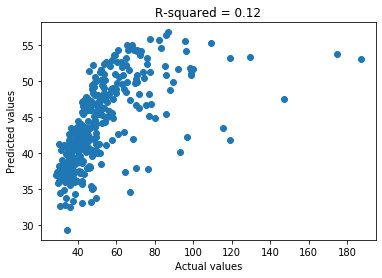

In [8]:
r_list = []
net.load_state_dict(torch.load('out/model_1714_0.6_0.1.ckpt'))
y_pred = net(x_test_0)
y_real = y_test_0
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_0 = MSELoss(y_pred, y_real)


t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())
plt.legend(['prediction', 'observation'])
plt.xlabel('DOE sample points')
plt.ylabel('HCOcl value')
plt.title('RMSE = %0.2f' % torch.sqrt(loss_0.data))
plt.savefig('DOE.png', dpi=400)
plt.close()

y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared = %0.2f' % r)
plt.savefig('DOE_r.png', dpi=400)
plt.close()

y_pred = net(x_test_1)
y_real = y_test_1
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_1 = MSELoss(y_pred, y_real)
t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())
plt.legend(['prediction', 'observation'])
plt.xlabel('TPA sample points')
plt.ylabel('HCOcl value')
plt.title('RMSE = %0.2f' % torch.sqrt(loss_1.data))
plt.savefig('TPA.png', dpi=400)
plt.close()


y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared = %0.2f' % r)
plt.savefig('TPA_r.png', dpi=400)
plt.close()

y_pred = net(x_target)
y_real = y_target
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_2 = MSELoss(y_pred, y_real)
t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())

plt.xlabel('altitude sample points')
plt.ylabel('HCOcl value')
plt.legend(['prediction', 'observation'])
plt.title('RMSE = %0.2f' % torch.sqrt(loss_2.data))
plt.savefig('altitude.png', dpi=400)
plt.close()

y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.plot(np.unique(y_real), np.poly1d(np.polyfit(y_real, y_pred, 1))(np.unique(y_real)))
plt.title('R-squared = %0.2f' % r)
plt.savefig('altitude_r.png', dpi=400)

print('epoch: %d || DOE: %f || TPA: %f || Target: %f' % (step, torch.sqrt(loss_0.data), torch.sqrt(loss_1.data), torch.sqrt(loss_2.data)))
print(r_list)

[tensor([[1.0289e-01, 1.9803e-02, 2.1453e-01,  ..., 4.4249e-01, 9.0963e-02,
          2.1475e-05],
         [1.9876e-01, 1.0217e-01, 3.1624e-01,  ..., 6.3983e-01, 8.7762e-02,
          5.0918e-03],
         [2.5116e-01, 1.8638e-01, 2.9381e-01,  ..., 4.6306e-03, 5.0820e-02,
          1.5725e-03],
         ...,
         [1.3923e-01, 5.4118e-02, 2.4987e-01,  ..., 2.3979e-01, 9.2570e-02,
          2.2948e-05],
         [1.1015e-01, 3.2328e-02, 1.0598e-01,  ..., 3.8260e-01, 9.7773e-02,
          1.7290e-06],
         [9.5444e-02, 4.1794e-02, 1.8311e-01,  ..., 4.5850e-02, 8.9365e-02,
          7.4954e-05]])]

In [50]:
from sklearn import mixture
from sklearn.cluster import KMeans

num_list_new = [num_list[1]-num_list[0], num_list[2]-num_list[1]]
data_1 = data.to_numpy()
data_1 = data_1[:, 1:]
data_1 = data_1[num_list[0]:, :]
estimator = mixture.BayesianGaussianMixture(
    n_components=2, covariance_type='full', weight_concentration_prior=0.1,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-6, init_params="random", max_iter=1000)

kmeans = KMeans(n_clusters=2, random_state=0).fit(data_1)
estimator.fit(data_1)
a = kmeans.predict(data_1)
print(a)
np.savetxt("foo.csv", a, delimiter=",")

[1 1 1 ... 1 1 0]


In [52]:
l0 = np.sum(a[:num_list_new[0]])
l1 = np.sum(a[num_list_new[0]:])
print(l0/num_list_new[0])
print(l1/num_list_new[1])


0.3999285203716941
0.5363790186125211


In [23]:
class ab:
    def __init__(self, b):
        self.a = b
    def f(self, c):
        self.a = c
        self.d = 1

In [15]:
columns

['xHCOcI',
 'HRRmax',
 'HeatreleaseCA50',
 'PCA01',
 'PCA25',
 'Swirl3CA99',
 'TBCA70',
 'TempCA05',
 'TempCA50',
 'TO2CA50',
 'VolCA99',
 'chartimems',
 'fuelburntrate',
 'blowthrufracCyl']